# 전체

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0. import

In [ ]:
# 패키지 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from IPython.display import Image
from numpy import interp
import scipy.stats

from IPython.display import Image
from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

!apt-get -qq install fonts-nanum

import os
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.font_manager as fm

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 원하는 폰트 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가

plt.rcParams.update({'font.size': 9, 'font.family': 'NanumGothic'}) # 폰트 설정

# 컬럼명 변환을 위한 리스트 할당
train_df_col = ['num', 'date_time', 'power', 'temp', 'wind', 'hum', 'prec', 'sun', 'non_elec', 'solar']
test_df_col = ['num', 'date_time', 'temp', 'wind', 'hum', 'prec', 'sun', 'non_elec', 'solar']


# vs code 로 실행 시 주석 해제
# train_df = pd.read_csv(r"C:\Users\USER\Downloads\electricity_data\train.csv", encoding='cp949', names=train_df_col, header=0)
# test_df = pd.read_csv(r"C:\Users\USER\Downloads\electricity_data\test.csv", encoding='cp949', names=test_df_col, header=0)
# submission = pd.read_csv(r"C:\Users\USER\Downloads\electricity_data\sample_submission.csv", encoding='cp949')

# 구글 코랩으로 실행 시 주석 해제
train_df = pd.read_csv("/content/drive/MyDrive/lsda02Project/train.csv", encoding='cp949', names=train_df_col, header=0)
test_df = pd.read_csv("/content/drive/MyDrive/lsda02Project/test.csv", encoding='cp949', names=test_df_col, header=0)
submission = pd.read_csv("/content/drive/MyDrive/lsda02Project/sample_submission.csv", encoding='cp949')

## 1. 전처리

In [ ]:
def make_time(train_df):
    """
    시간 관련 변수를 추가하기 위한 함수
    """
    train_df['date_time'] = pd.to_datetime(train_df.date_time)

    train_df['month'] = train_df.date_time.dt.month                    # 월(숫자)
    train_df['day'] = train_df.date_time.dt.day                        # 일(숫자)
    train_df['hour'] = train_df.date_time.dt.hour                      # 시(숫자)
    train_df['weekday'] = train_df.date_time.dt.weekday                # 요일(숫자)
    train_df['dayofyear'] = train_df.date_time.dt.dayofyear            # 연 기준 몇일째(숫자)

    return train_df


train_df = make_time(train_df)
# test_df = make_time(test_df)

# 6월 6일은 현충일, 8월 15일은 광복절, 8월 17일은 임시공휴일
# 휴일이 많지 않으니, 주말에 포함시키겠습니다.

train_df.loc[train_df.weekday >= 5, 'weekend'] = 1
train_df.loc[train_df.weekday < 5, 'weekend'] = 0
train_df.loc[(train_df.month == 8) & (train_df.day == 17), 'weekend'] = 1

# test_df.loc[test_df.weekday >= 5, 'weekend'] = 1
# test_df.loc[test_df.weekday < 5, 'weekend'] = 0

### 결측치 채우기

In [ ]:
# 건물 별 태양열, 비전기뭐시기 여부

non_elec_solar_info = train_df[['num','non_elec', 'solar']].drop_duplicates()

test_df.drop(columns=['non_elec', 'solar'], inplace = True)
test_df = pd.merge(test_df, non_elec_solar_info, on= 'num')


# 강수량 다항식 보간 적용
test_df['prec'] = test_df['prec'].interpolate(method='quadratic')
test_df.loc[test_df['prec'] < 0, 'prec'] = 0
test_df['prec'] = test_df['prec'].round(1)

# 강수량 마지막 결측치 채우기
test_df['prec'] = test_df['prec'].interpolate(method='linear')
test_df['prec'].iloc[40:60]


# 이건 그냥 하연(강)이랑 얘기했던 앞 뒤 값으로 채우는 방법
# test_df['sun'] = test_df['sun'].fillna(method='ffill').fillna(method='bfill')
# test_df['sun'].head(30)


# 온도, 풍속, 습도, 일조량은 선형 보간법으로 결측치 채움
test_df['temp'] = test_df['temp'].interpolate(method='linear')
test_df['wind'] = test_df['wind'].interpolate(method='linear')
test_df['hum'] = test_df['hum'].interpolate(method='linear')
test_df['sun'] = test_df['sun'].interpolate(method='linear')

# 반올림
test_df['temp'] = test_df['temp'].round(2)
test_df['wind'] = test_df['wind'].round(2)
test_df['hum'] = test_df['hum'].round(2)
test_df['sun'] = test_df['sun'].round(2)


# 일조량이 3.0까지는 나오는 문제점 발견 -> mixmax 로 최대를 1.0으로 바꿔줌
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
test_df[['sun']] = scaler.fit_transform(test_df[['sun']])


# 맨 아래에 안 채워진 부분 잘 채워졌나 확인

test_df = make_time(test_df)

test_df.loc[test_df.weekday >= 5, 'weekend'] = 1
test_df.loc[test_df.weekday < 5, 'weekend'] = 0

test_df.tail(10)

num           date_time  temp  wind   hum  prec  sun  non_elec  solar  \
10070   60 2020-08-31 14:00:00 28.83  2.53 65.67  0.00 0.22      1.00   1.00   
10071   60 2020-08-31 15:00:00 29.40  2.30 65.00  0.00 0.33      1.00   1.00   
10072   60 2020-08-31 16:00:00 29.27  2.63 65.00  0.00 0.31      1.00   1.00   
10073   60 2020-08-31 17:00:00 29.13  2.97 65.00  0.00 0.29      1.00   1.00   
10074   60 2020-08-31 18:00:00 29.00  3.30 65.00  0.00 0.27      1.00   1.00   
10075   60 2020-08-31 19:00:00 28.63  3.57 66.00  0.00 0.18      1.00   1.00   
10076   60 2020-08-31 20:00:00 28.27  3.83 67.00  0.00 0.09      1.00   1.00   
10077   60 2020-08-31 21:00:00 27.90  4.10 68.00  0.00 0.00      1.00   1.00   
10078   60 2020-08-31 22:00:00 27.90  4.10 68.00  0.00 0.00      1.00   1.00   
10079   60 2020-08-31 23:00:00 27.90  4.10 68.00  0.00 0.00      1.00   1.00   

       month  day  hour  weekday  dayofyear  weekend  
10070      8   31    14        0        244     0.00  
10071      8   31    15        0        244     0.00  
10072      8   31    16        0        244     0.00  
10073      8   31    17        0        244     0.00  
10074      8   31    18        0        244     0.00  
10075      8   31    19        0        244     0.00  
10076      8   31    20        0        244     0.00  
10077      8   31    21        0        244     0.00  
10078      8   31    22        0        244     0.00  
10079      8   31    23        0        244     0.00

In [ ]:
test_df['sun'].value_counts()

sun
0.00    4716
0.07     219
0.13     202
0.02     200
0.03     192
        ... 
0.86       7
0.66       7
0.52       6
0.81       4
0.94       3
Name: count, Length: 91, dtype: int64

In [ ]:
# 결측치 보간한 test 파일 저장하기 (일단 주석 처리함)
# test_df.to_csv('test_filled.csv', index=False, encoding='utf-8')

test_copy = test_df.copy()

## 2. EDA

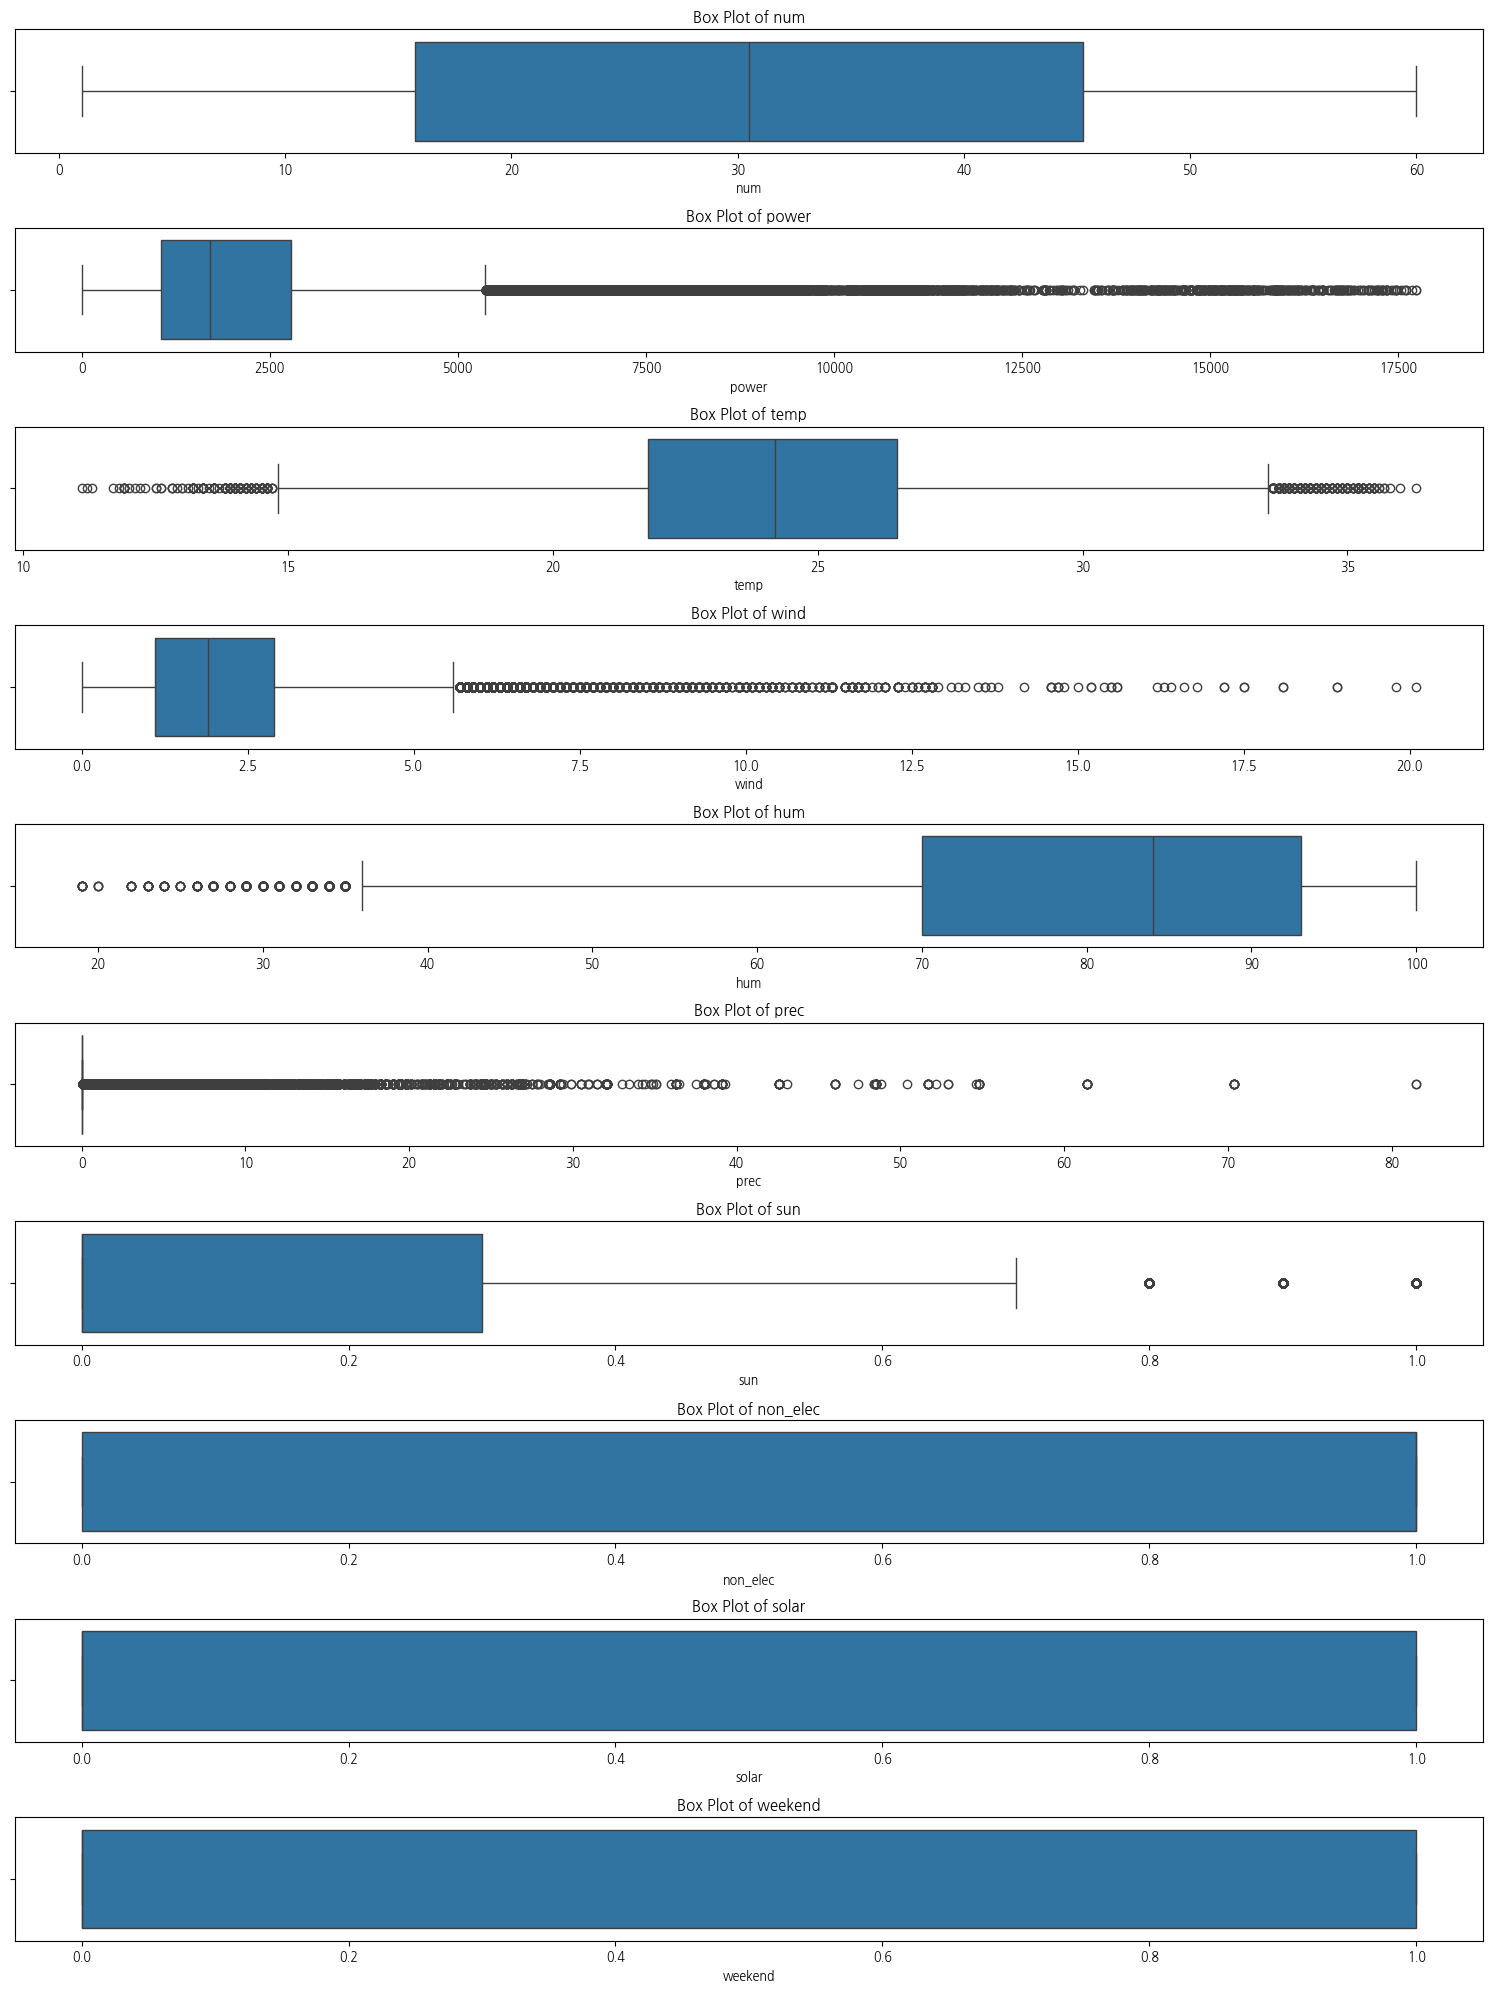

In [ ]:
# 수치형 변수 선택
numeric_columns = train_df.select_dtypes(include=['float64', 'int64']).columns

# 상자수염 그래프 그리기
plt.figure(figsize=(15, 20))  # 그래프 전체 크기 설정
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns), 1, i)  # 각 변수를 위한 서브플롯 설정
    sns.boxplot(x = train_df[column])
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)

plt.tight_layout()  # 레이아웃 조정
plt.show()

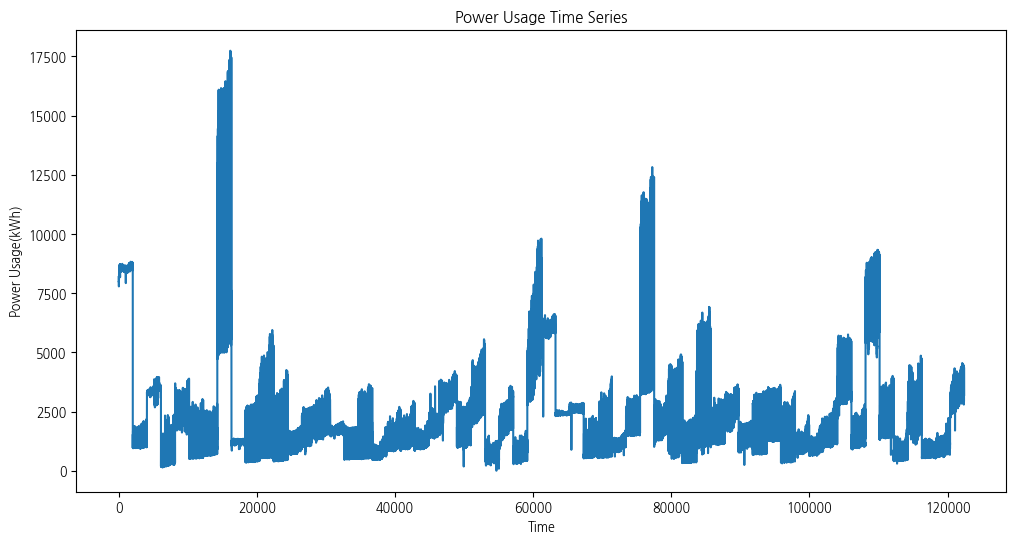

In [ ]:
import matplotlib.pyplot as plt


# 전력 사용량 시각화
plt.figure(figsize=(12, 6))
plt.plot(train_df['power'])
plt.title('Power Usage Time Series')
plt.xlabel('Time')
plt.ylabel('Power Usage(kWh)')
plt.show()

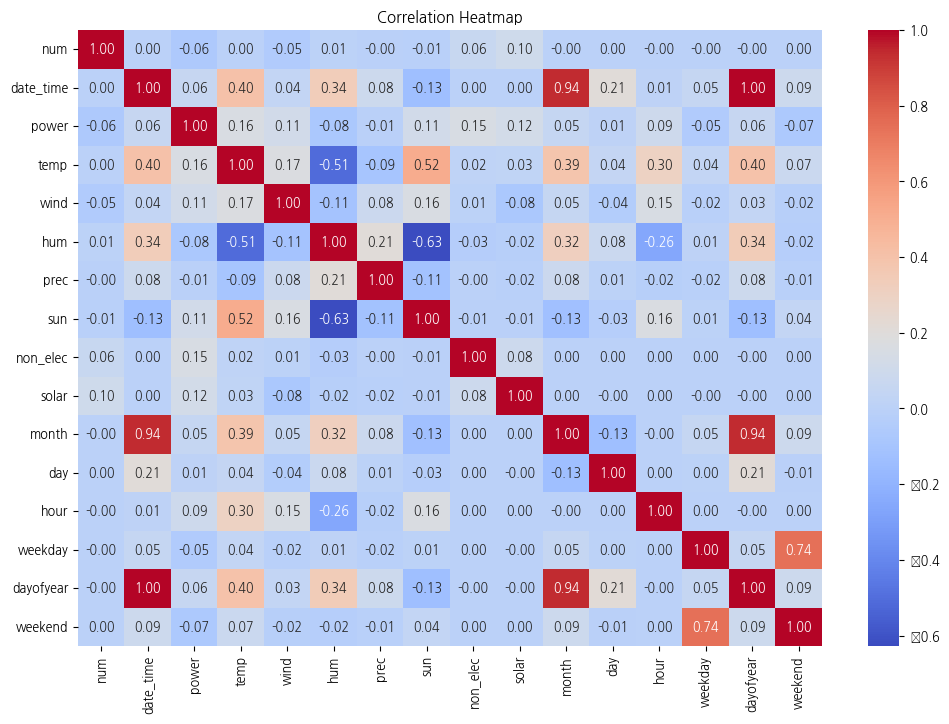

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 상관 행렬 계산
corr_matrix = train_df.corr()

# 히트맵 그리기
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

   num           date_time   power  temp  wind   hum  prec  sun  non_elec  \
0    1 2020-06-01 00:00:00 8179.06 17.60  2.50 92.00  0.80 0.00      0.00   
1    1 2020-06-01 01:00:00 8135.64 17.70  2.90 91.00  0.30 0.00      0.00   
2    1 2020-06-01 02:00:00 8107.13 17.50  3.20 91.00  0.00 0.00      0.00   
3    1 2020-06-01 03:00:00 8048.81 17.10  3.20 91.00  0.00 0.00      0.00   
4    1 2020-06-01 04:00:00 8043.62 17.00  3.30 92.00  0.00 0.00      0.00   

   solar  month  day  hour  weekday  dayofyear  weekend  
0   0.00      6    1     0        0        153     0.00  
1   0.00      6    1     1        0        153     0.00  
2   0.00      6    1     2        0        153     0.00  
3   0.00      6    1     3        0        153     0.00  
4   0.00      6    1     4        0        153     0.00  


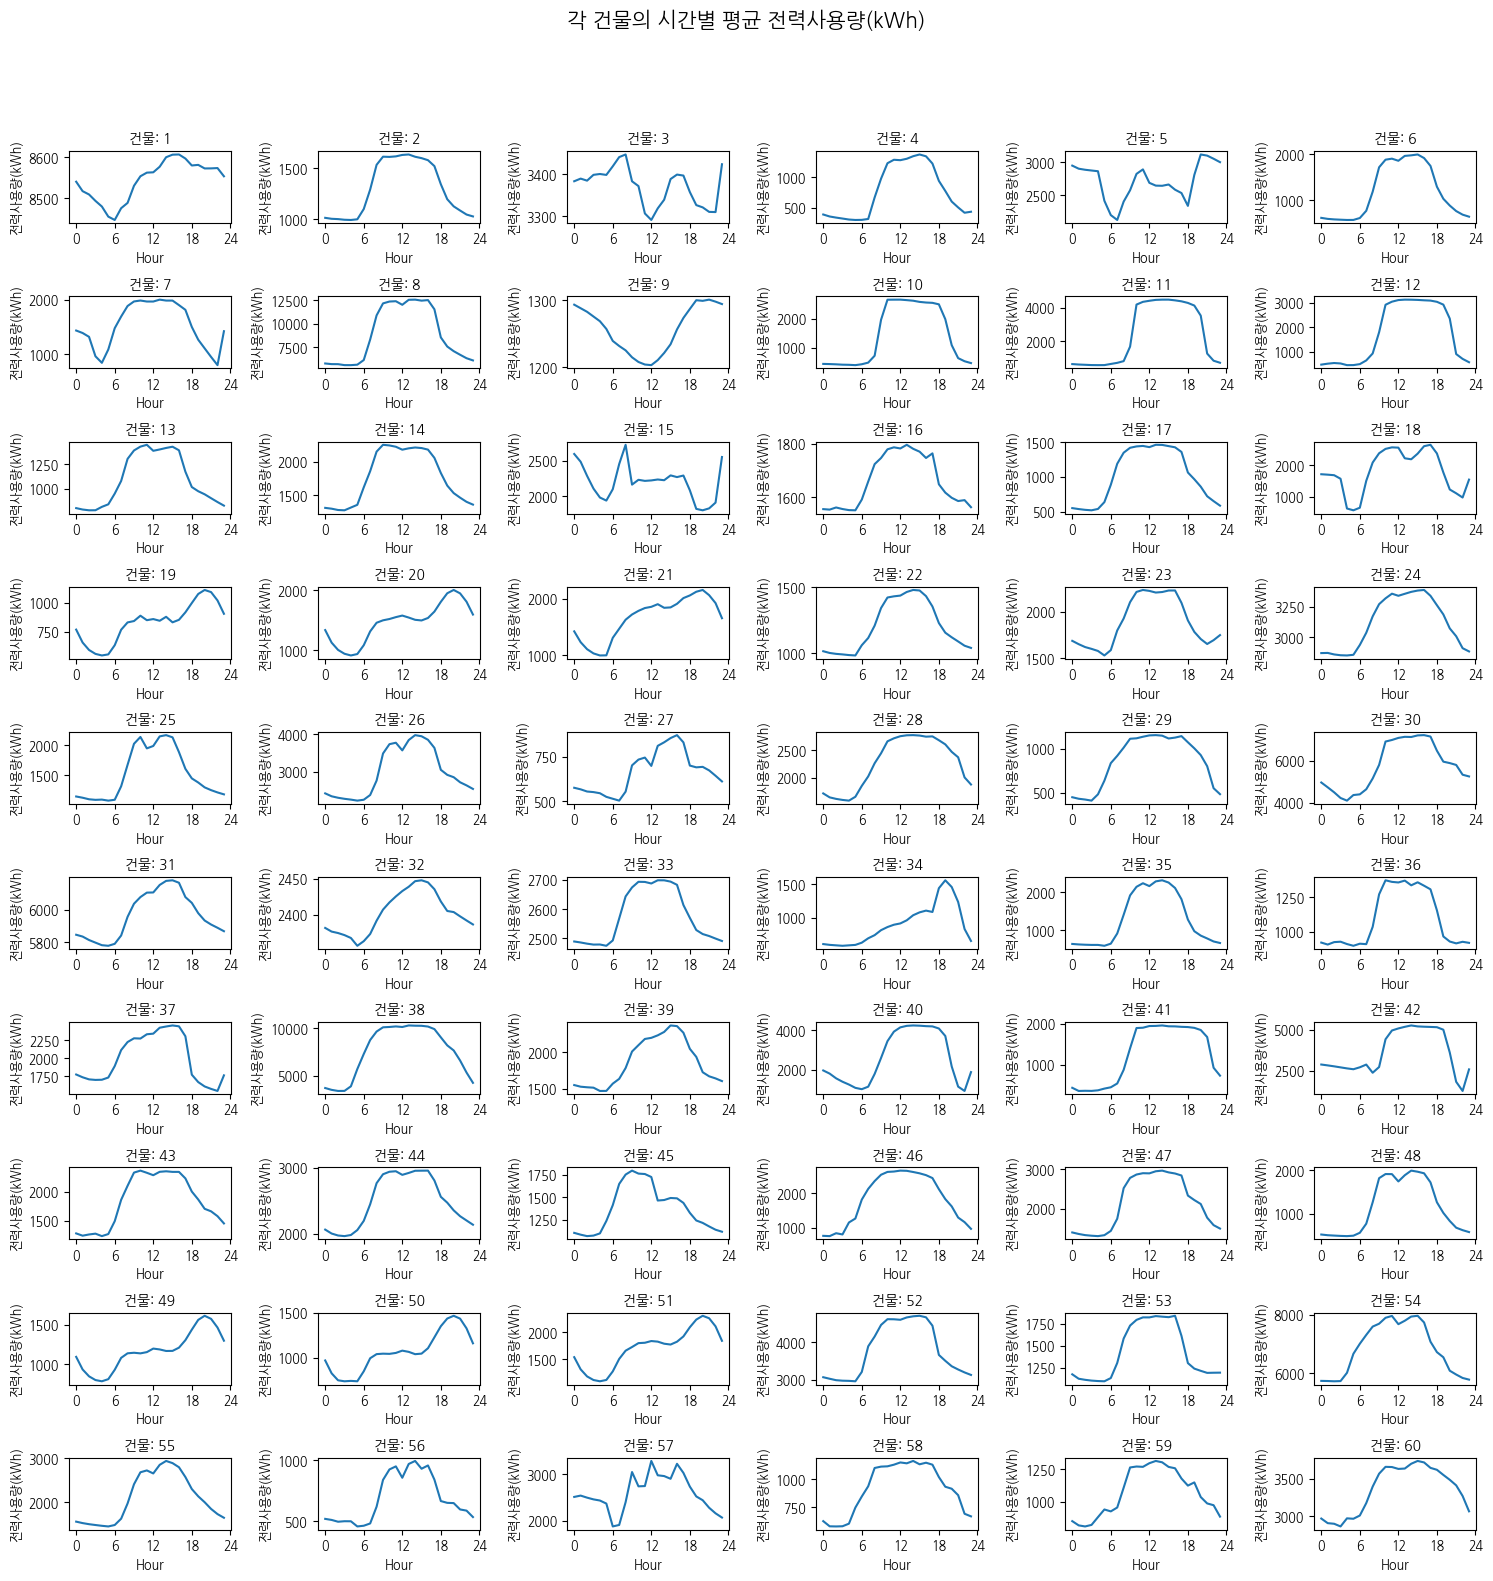

In [ ]:
# # non_elec와 solar 열을 int 타입으로 변환
# train_df['non_elec'] = train_df['non_elec'].astype(int)
# train_df['solar'] = train_df['solar'].astype(int)


# # weekday 열 추가
# train_df['weekday'] = train_df['date_time'].dt.day_name()

# # weekend 열 추가 (Saturday, Sunday)
# train_df['weekend'] = train_df['weekday'].isin(['Saturday', 'Sunday'])

# 결과 출력
print(train_df.head())



# 시각화
fig = plt.figure(figsize=(15, 15))
plt.suptitle("각 건물의 시간별 평균 전력사용량(kWh)", fontsize=15, y=1.05)
plt.axis('off')

for num in range(1, 61):
    df = train_df[train_df.num == num]
    ax = fig.add_subplot(10, 6, num)
    hourly_avg = df.groupby('hour')['power'].mean()
    ax.plot(hourly_avg.index, hourly_avg.values)
    ax.set_title(f'건물: {num}', fontsize=10)
    ax.set_xticks([0, 6, 12, 18, 24])
    ax.set_xlabel('Hour')
    ax.set_ylabel('전력사용량(kWh)')

plt.tight_layout()
plt.show()

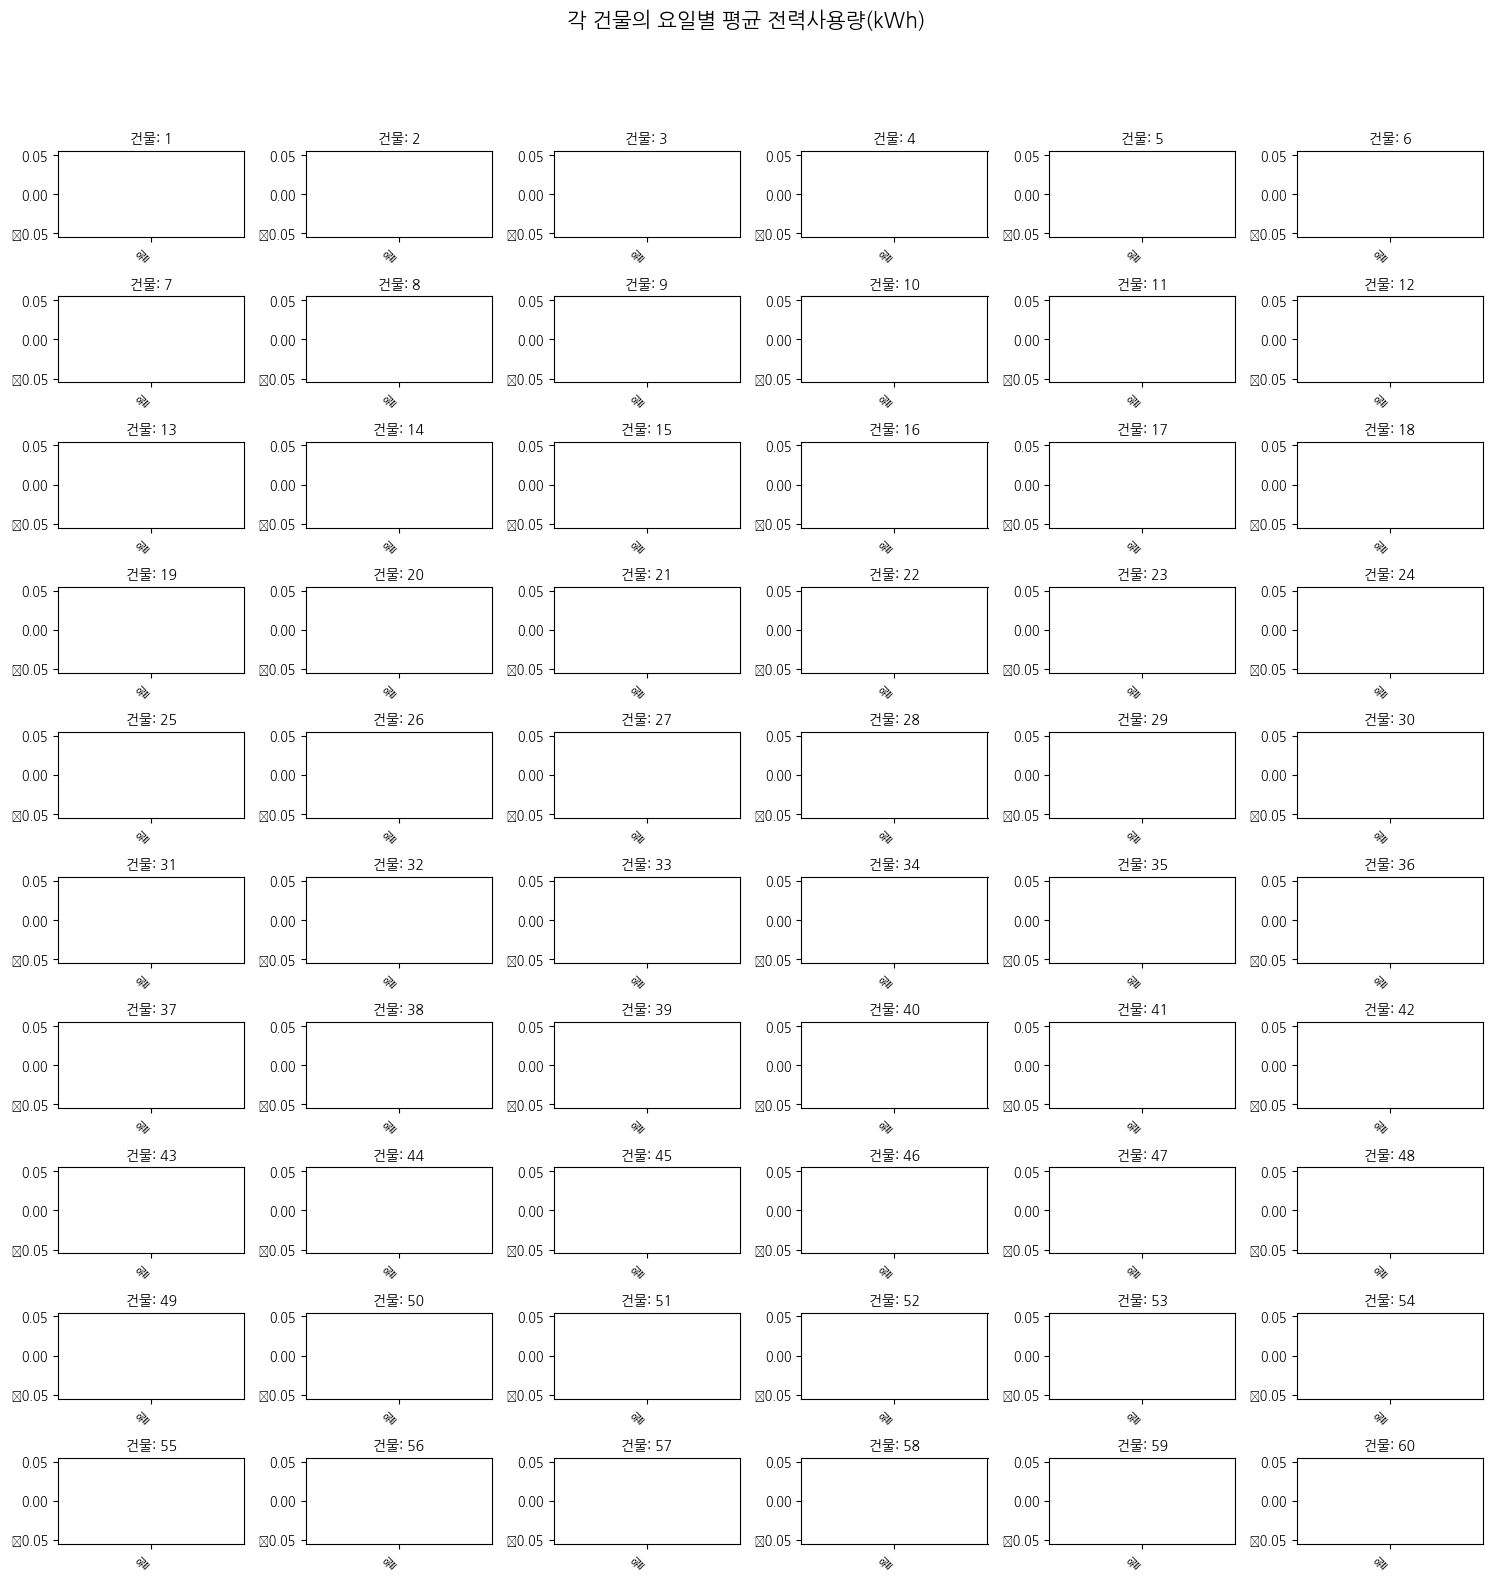

In [ ]:
# # 요일을 한글로 변경하기 위한 사전
# weekday_map = {
#     'Monday': '월',
#     'Tuesday': '화',
#     'Wednesday': '수',
#     'Thursday': '목',
#     'Friday': '금',
#     'Saturday': '토',
#     'Sunday': '일'
# }

# # 요일 열 추가 및 한글로 변경

# train_df['weekday'] = train_df['weekday'].map(weekday_map)

# 시각화
fig = plt.figure(figsize=(15, 15))
plt.suptitle("각 건물의 요일별 평균 전력사용량(kWh)", fontsize=15, y=1.05)
plt.axis('off')

weekday = ['월', '화', '수', '목', '금', '토', '일']
colors = ['skyblue', 'skyblue', 'skyblue', 'skyblue', 'skyblue', 'pink', 'pink']

for num in range(1, 61):
    df = train_df[train_df.num == num]
    df_counts = df.groupby('weekday')['power'].mean()
    df_counts = df_counts.reindex(weekday)
    ax = fig.add_subplot(10, 6, num)
    ax.bar(df_counts.index, df_counts.values, color=colors)
    ax.set_title(f'건물: {num}', fontsize=10)
    ax.set_xticklabels(weekday, rotation=45, ha='right')

plt.tight_layout()
plt.show()

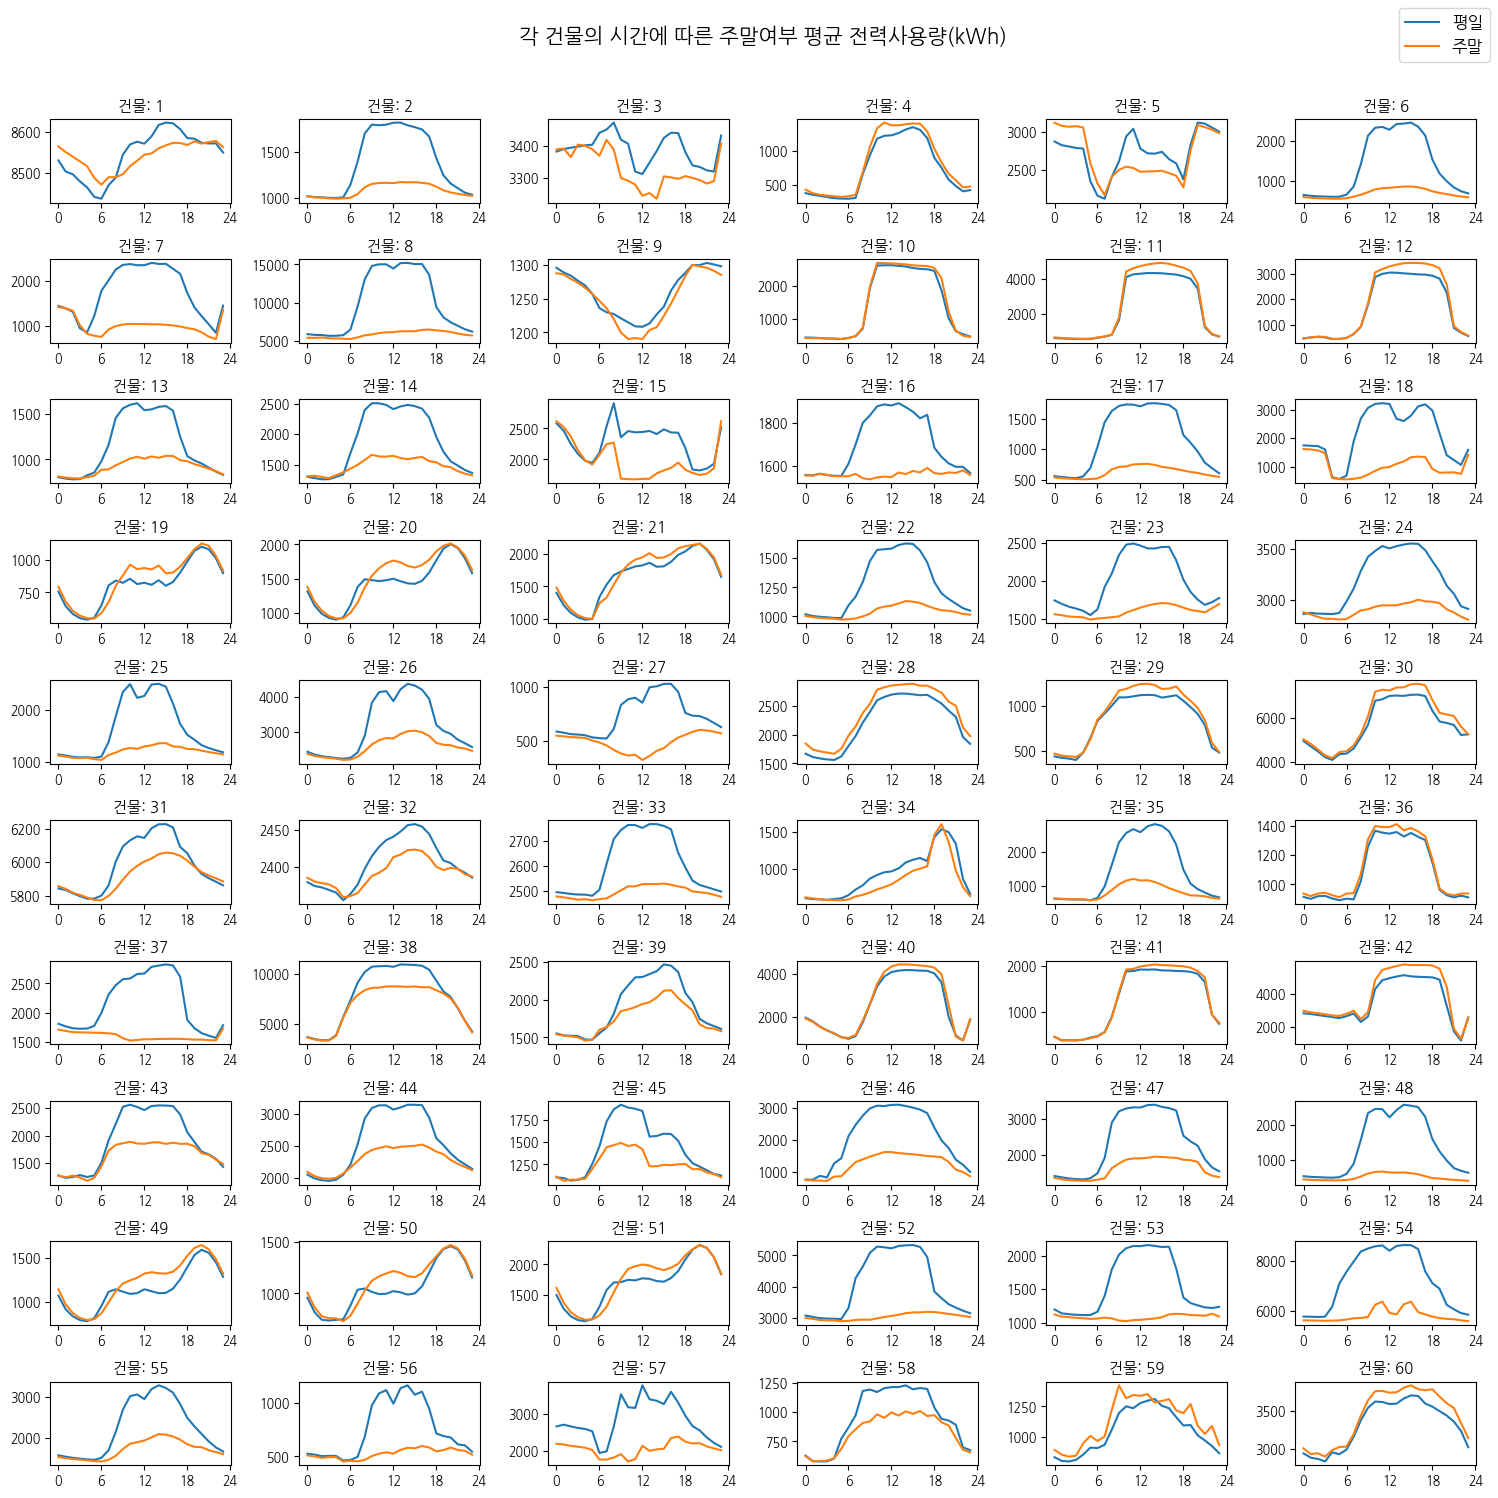

In [ ]:
fig = plt.figure(figsize=(15, 15))
plt.title("각 건물의 시간에 따른 주말여부 평균 전력사용량(kWh)", fontsize=15, y=1.05)
plt.axis('off')

for num in range(1, 61):
    df = train_df[train_df.num == num]
    ax = fig.add_subplot(10, 6, num)

    weekday_avg = df[df.weekend == False].groupby('hour')['power'].mean()
    weekend_avg = df[df.weekend == True].groupby('hour')['power'].mean()

    if not weekday_avg.empty:
        ax.plot(weekday_avg.index, weekday_avg.values, label='평일')
    if not weekend_avg.empty:
        ax.plot(weekend_avg.index, weekend_avg.values, label='주말')

    ax.set_title(f'건물: {num}')
    ax.set_xticks([0, 6, 12, 18, 24])

# 범례 추가
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper right', prop={'size': 12})
plt.tight_layout()
plt.show()

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   num        122400 non-null  int64         
 1   date_time  122400 non-null  datetime64[ns]
 2   power      122400 non-null  float64       
 3   temp       122400 non-null  float64       
 4   wind       122400 non-null  float64       
 5   hum        122400 non-null  float64       
 6   prec       122400 non-null  float64       
 7   sun        122400 non-null  float64       
 8   non_elec   122400 non-null  float64       
 9   solar      122400 non-null  float64       
 10  month      122400 non-null  int32         
 11  day        122400 non-null  int32         
 12  hour       122400 non-null  int32         
 13  weekday    122400 non-null  int32         
 14  dayofyear  122400 non-null  int32         
 15  weekend    122400 non-null  float64       
dtypes: datetime64[ns](1)

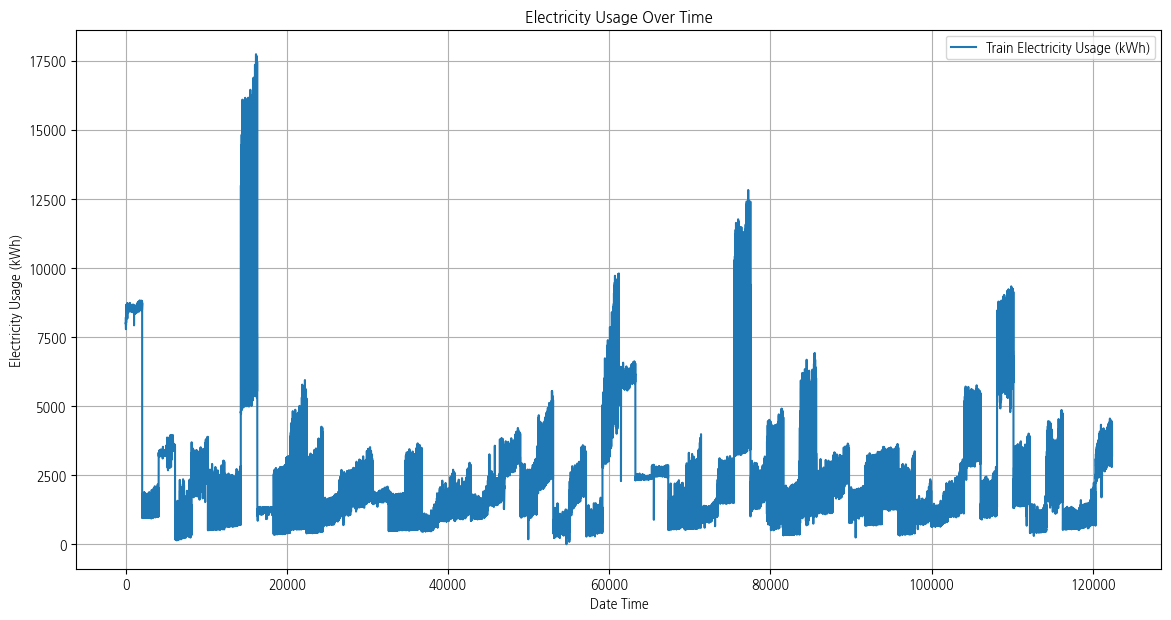

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# 전력 사용량 열 이름을 확인 후 사용 (여기서는 예시로 'electricity_usage_kWh' 사용)
electricity_usage_column = 'power'

# 시계열 그래프 그리기
plt.figure(figsize=(14, 7))
plt.plot(train_df.index, train_df[electricity_usage_column], label='Train Electricity Usage (kWh)')
plt.xlabel('Date Time')
plt.ylabel('Electricity Usage (kWh)')
plt.title('Electricity Usage Over Time')
plt.legend()
plt.grid(True)
plt.show()

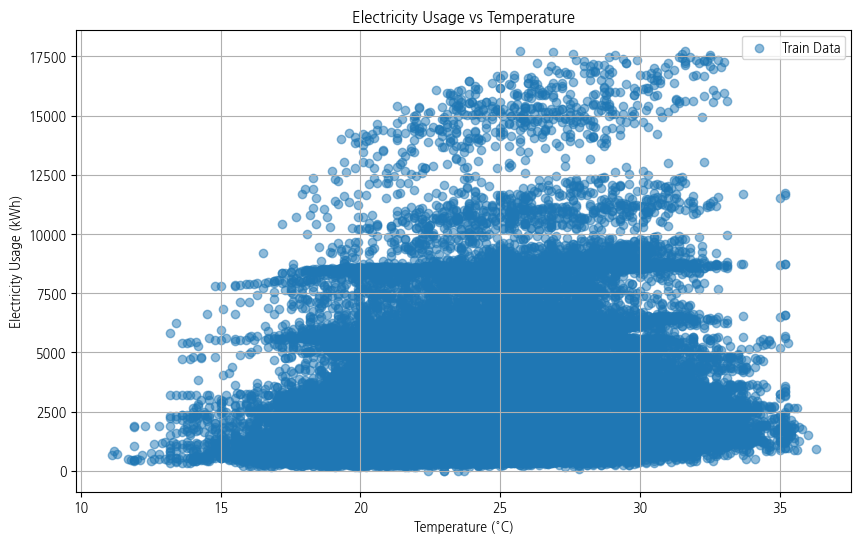

In [ ]:



# 열 이름을 사용하여 산점도 그리기
electricity_usage_column = 'power'  # 전력 사용량 열 이름
temperature_column = 'temp' # 기온 열 이름

# 산점도 그리기
plt.figure(figsize=(10, 6))
plt.scatter(train_df[temperature_column], train_df[electricity_usage_column], alpha=0.5, label='Train Data')
plt.xlabel('Temperature (°C)')
plt.ylabel('Electricity Usage (kWh)')
plt.title('Electricity Usage vs Temperature')
plt.legend()
plt.grid(True)
plt.show()



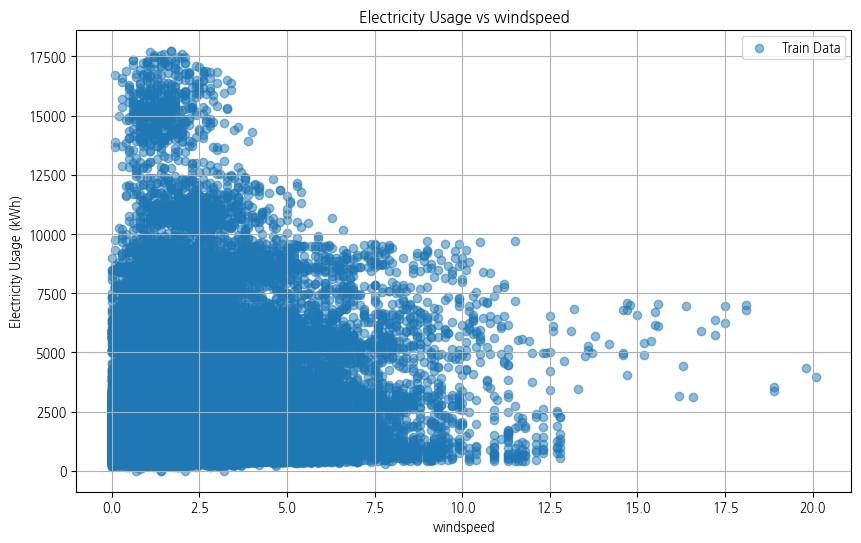

In [ ]:
# 열 이름을 사용하여 산점도 그리기
electricity_usage_column = 'power'  # 전력 사용량 열 이름
temperature_column = 'wind'  # 기온 열 이름

# 산점도 그리기
plt.figure(figsize=(10, 6))
plt.scatter(train_df[temperature_column], train_df[electricity_usage_column], alpha=0.5, label='Train Data')
plt.xlabel('windspeed')
plt.ylabel('Electricity Usage (kWh)')
plt.title('Electricity Usage vs windspeed')
plt.legend()
plt.grid(True)
plt.show()

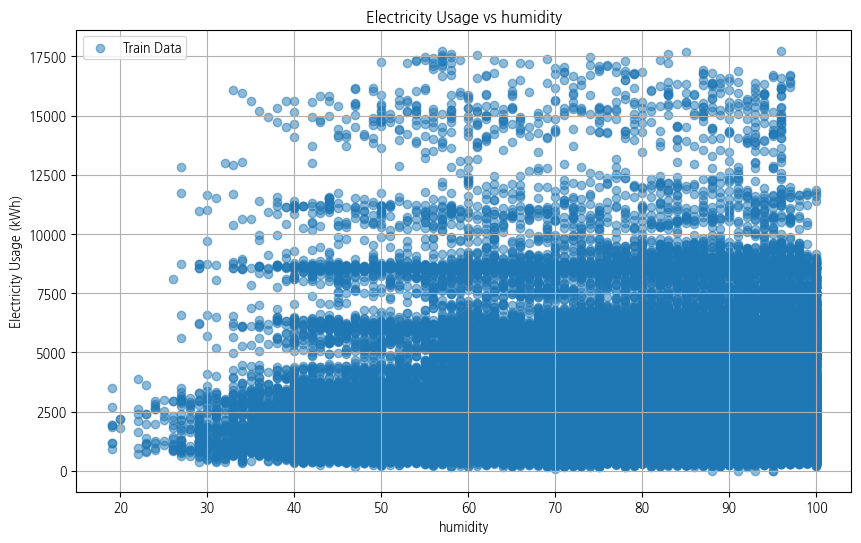

In [ ]:
# 열 이름을 사용하여 산점도 그리기
electricity_usage_column = 'power'  # 전력 사용량 열 이름
temperature_column = 'hum'  # 기온 열 이름

# 산점도 그리기
plt.figure(figsize=(10, 6))
plt.scatter(train_df[temperature_column], train_df[electricity_usage_column], alpha=0.5, label='Train Data')
plt.xlabel('humidity')
plt.ylabel('Electricity Usage (kWh)')
plt.title('Electricity Usage vs humidity')
plt.legend()
plt.grid(True)
plt.show()

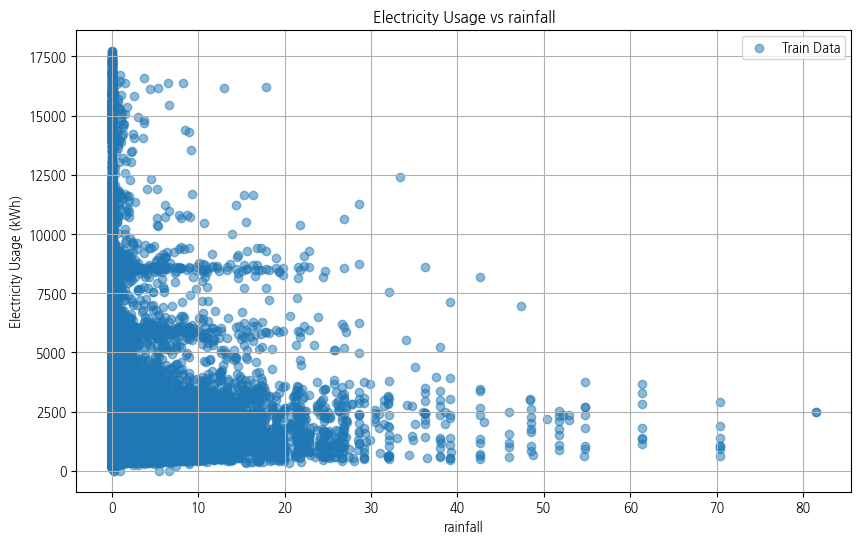

In [ ]:
# 열 이름을 사용하여 산점도 그리기
electricity_usage_column = 'power'  # 전력 사용량 열 이름
temperature_column = 'prec'  # 기온 열 이름

# 산점도 그리기
plt.figure(figsize=(10, 6))
plt.scatter(train_df[temperature_column], train_df[electricity_usage_column], alpha=0.5, label='Train Data')
plt.xlabel('rainfall')
plt.ylabel('Electricity Usage (kWh)')
plt.title('Electricity Usage vs rainfall')
plt.legend()
plt.grid(True)
plt.show()

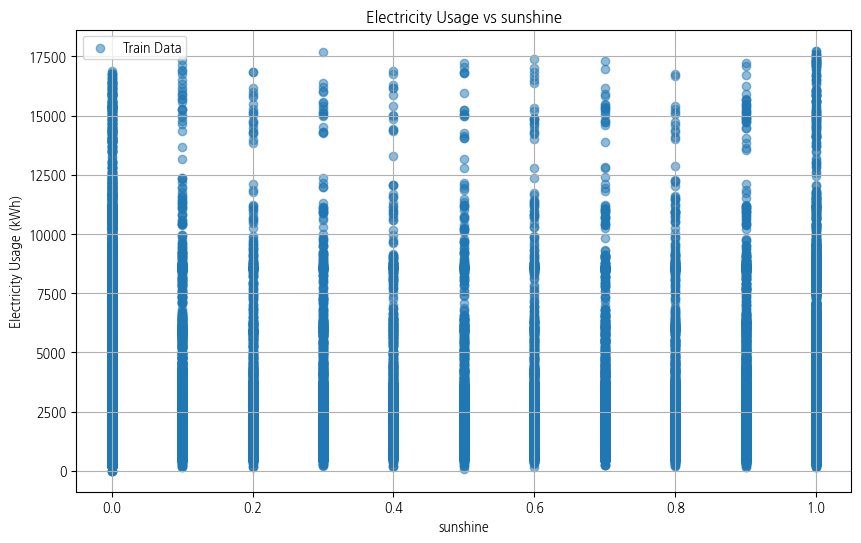

In [ ]:
# 열 이름을 사용하여 산점도 그리기
electricity_usage_column = 'power'  # 전력 사용량 열 이름
temperature_column = 'sun'  # 기온 열 이름

# 산점도 그리기
plt.figure(figsize=(10, 6))
plt.scatter(train_df[temperature_column], train_df[electricity_usage_column], alpha=0.5, label='Train Data')
plt.xlabel('sunshine')
plt.ylabel('Electricity Usage (kWh)')
plt.title('Electricity Usage vs sunshine')
plt.legend()
plt.grid(True)
plt.show()

## 3. 군집화

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 데이터 로드
file_path = file_path = '/content/drive/MyDrive/lsda02/data/train.csv'  # 로컬 파일 경로
data = pd.read_csv(file_path, encoding='cp949')

# 필요한 열 추출 및 전처리
energy_data = data[['date_time', 'num', '전력사용량(kWh)']]
energy_data['date_time'] = pd.to_datetime(energy_data['date_time'])
energy_data['hour'] = energy_data['date_time'].dt.hour
energy_data['weekday'] = energy_data['date_time'].dt.weekday
energy_data['weekend'] = energy_data['weekday'].isin([5,6]).astype(int)

# 시간대별 평균 전력 사용량 계산
hourly_consumption_weekday = energy_data[energy_data['weekend']==0].groupby(['num', 'hour']).mean().reset_index()

# 시간대별 평균 전력 사용량 계산
hourly_consumption_weekend = energy_data[energy_data['weekend']==1].groupby(['num', 'hour']).mean().reset_index()

hourly_consumption_combined = pd.concat([hourly_consumption_weekday, hourly_consumption_weekend], ignore_index=True)


hourly_consumption_combined['hour'] = hourly_consumption_combined['hour'].astype(str)


# if weekend=1 이면 hour명을 _end 추가
hourly_consumption_combined.loc[hourly_consumption_combined['weekend'] == 1, 'hour'] = 'e' + hourly_consumption_combined.loc[hourly_consumption_combined['weekend'] == 1, 'hour']

# 건물번호별로 그룹화
buildings = hourly_consumption_combined['num'].unique()

# 정규화된 데이터를 저장할 데이터프레임
normalized_data_combined = pd.DataFrame()

# 각 건물별로 정규화 수행
for building in buildings:
    building_data = hourly_consumption_combined[hourly_consumption_combined['num'] == building]
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(building_data[['전력사용량(kWh)']])

    # 정규화된 값을 원래 데이터프레임에 추가
    building_data['Normalized'] = scaled_values
    normalized_data_combined = pd.concat([normalized_data_combined, building_data], ignore_index=True)




# 정규화된 데이터를 저장할 데이터프레임
normalized_data_combined = pd.DataFrame()

# 각 건물별로 정규화 수행
for building in buildings:
    building_data = hourly_consumption_combined[hourly_consumption_combined['num'] == building]
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(building_data[['전력사용량(kWh)']])

    # 정규화된 값을 원래 데이터프레임에 추가
    building_data['Normalized'] = scaled_values
    normalized_data_combined = pd.concat([normalized_data_combined, building_data], ignore_index=True)

# 정규화된 데이터 확인
print(normalized_data_combined.head())

# 데이터피벗 (시간별로 다시 변형)
normalized_pivot_combined = normalized_data_combined.pivot(index='num', columns='hour', values='Normalized').fillna(0)

# 정규화된 데이터 확인
normalized_pivot_combined.head()

   num hour                     date_time  전력사용량(kWh)  weekday  weekend  \
0    1    0 2020-07-12 05:06:53.114754048     8532.41     1.97     0.00   
1    1    1 2020-07-12 06:06:53.114754048     8505.08     1.97     0.00   
2    1    2 2020-07-12 07:06:53.114754048     8498.56     1.97     0.00   
3    1    3 2020-07-12 08:06:53.114754304     8481.27     1.97     0.00   
4    1    4 2020-07-12 09:06:53.114754048     8466.73     1.97     0.00   

   Normalized  
0        0.50  
1        0.36  
2        0.32  
3        0.23  
4        0.15  


hour    0    1   10   11   12   13   14   15   16   17  ...  e21  e22  e23  \
num                                                     ...                  
1    0.50 0.36 0.71 0.74 0.72 0.82 0.97 1.00 0.99 0.92  ... 0.71 0.72 0.64   
2    0.04 0.03 0.96 0.97 1.00 1.00 0.96 0.94 0.91 0.82  ... 0.06 0.05 0.04   
3    0.64 0.67 0.73 0.38 0.36 0.50 0.64 0.81 0.87 0.87  ... 0.20 0.23 0.73   
4    0.07 0.05 0.77 0.81 0.82 0.85 0.89 0.92 0.89 0.78  ... 0.24 0.15 0.16   
5    0.76 0.70 0.81 0.92 0.66 0.60 0.59 0.62 0.52 0.46  ... 0.93 0.90 0.85   

hour   e3   e4   e5   e6   e7   e8   e9  
num                                      
1    0.46 0.39 0.24 0.15 0.25 0.24 0.28  
2    0.00 0.00 0.00 0.01 0.06 0.15 0.19  
3    0.72 0.69 0.66 0.57 0.78 0.65 0.28  
4    0.04 0.03 0.02 0.03 0.06 0.35 0.68  
5    0.95 0.93 0.45 0.19 0.04 0.28 0.37  

[5 rows x 48 columns]

### Elbow 와 Silhouette 계수를 통한 최적의 k 찾기

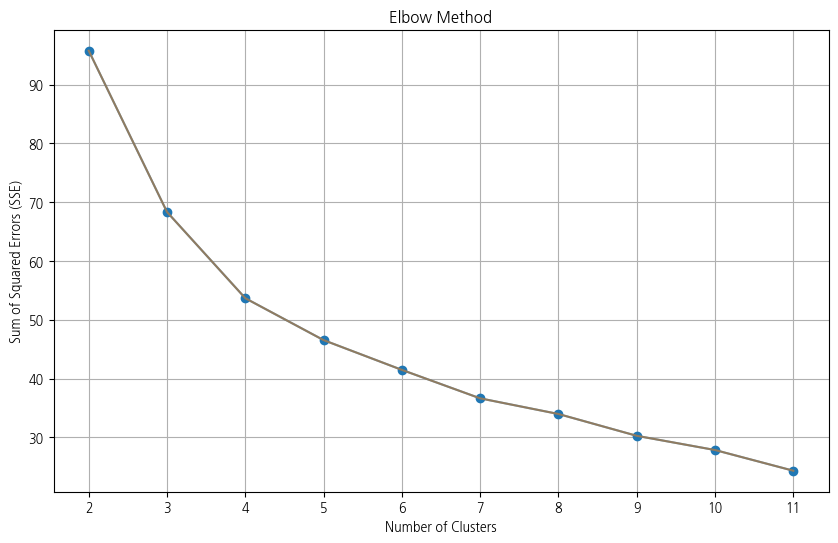

In [ ]:
new_order = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       'e0', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8', 'e9', 'e10',
       'e11', 'e12', 'e13', 'e14', 'e15', 'e16', 'e17', 'e18', 'e19',
       'e20', 'e21', 'e22', 'e23']
normalized_pivot_combined = normalized_pivot_combined[new_order]


### Elbow 기법을 통한 최적의 k 값 찾기

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# SSE 값을 저장할 빈 리스트 생성
sse = []

# KMeans 클러스터링을 위한 클러스터 수 범위 설정 (예: 1부터 15까지)
cluster_range = range(2, 12)

# 각 클러스터 수에 대해 KMeans 모델 생성 및 SSE 계산
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(normalized_pivot_combined)
    sse.append(kmeans.inertia_)

# Elbow Method를 위한 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, sse, marker='o')
plt.plot(cluster_range, sse, '-' , alpha = 0.5)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

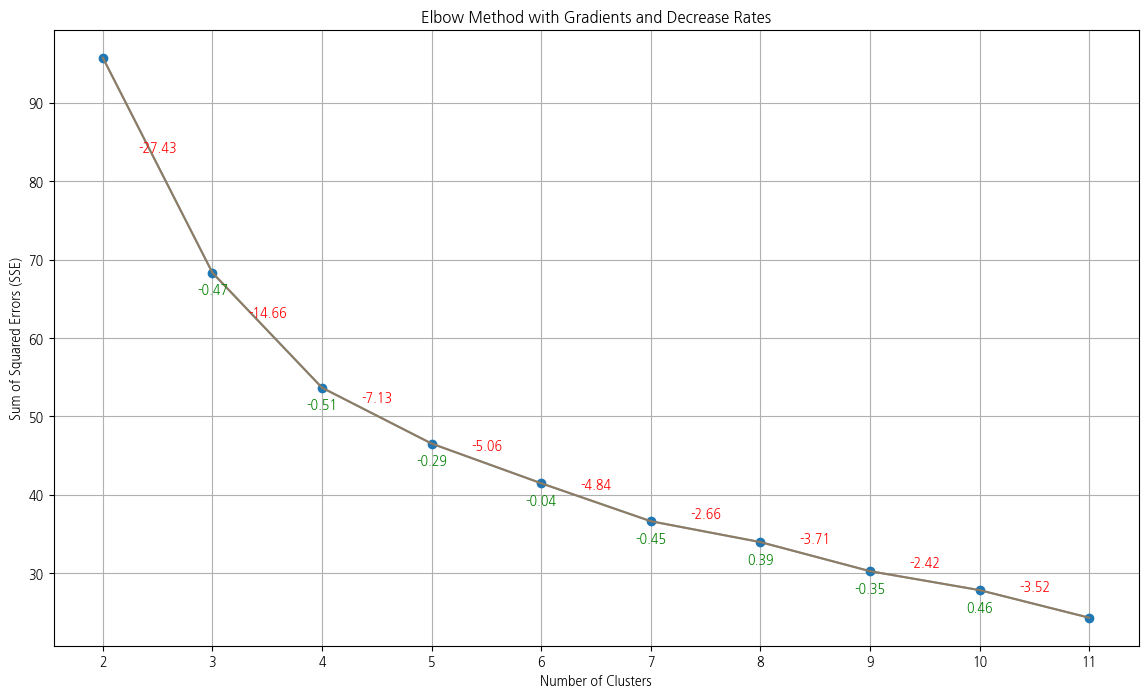

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# SSE 값을 저장할 빈 리스트 생성
sse = []

# KMeans 클러스터링을 위한 클러스터 수 범위 설정 (예: 2부터 11까지)
cluster_range = range(2, 12)

# 각 클러스터 수에 대해 KMeans 모델 생성 및 SSE 계산
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(normalized_pivot_combined)
    sse.append(kmeans.inertia_)

# 기울기 계산 (차분)
gradients = np.diff(sse)

# 기울기의 절대값을 씌운 후 감소율 계산
abs_gradients = np.abs(gradients)
decrease_rates = np.diff(abs_gradients) / abs_gradients[:-1]

# 그래프 그리기
plt.figure(figsize=(14, 8))

# Elbow Method 그래프
plt.plot(cluster_range, sse, marker='o')
plt.plot(cluster_range, sse, '-', alpha=0.5)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method with Gradients and Decrease Rates')
plt.xticks(cluster_range)
plt.grid(True)

# 각 선분 위에 기울기 값 표시
for i in range(len(cluster_range) - 1):
    x1, y1 = cluster_range[i], sse[i]
    x2, y2 = cluster_range[i + 1], sse[i + 1]
    gradient = gradients[i]
    plt.annotate(f'{gradient:.2f}', ((x1 + x2) / 2, (y1 + y2) / 2), textcoords="offset points", xytext=(0,10), ha='center', color='red')

# 각 점 위에 기울기 절대값의 감소율 표시
for i in range(len(decrease_rates)):
    x = cluster_range[i + 1]
    y = sse[i + 1]
    decrease_rate = decrease_rates[i]
    plt.annotate(f'{decrease_rate:.2f}', (x, y), textcoords="offset points", xytext=(0,-15), ha='center', color='green')

plt.show()

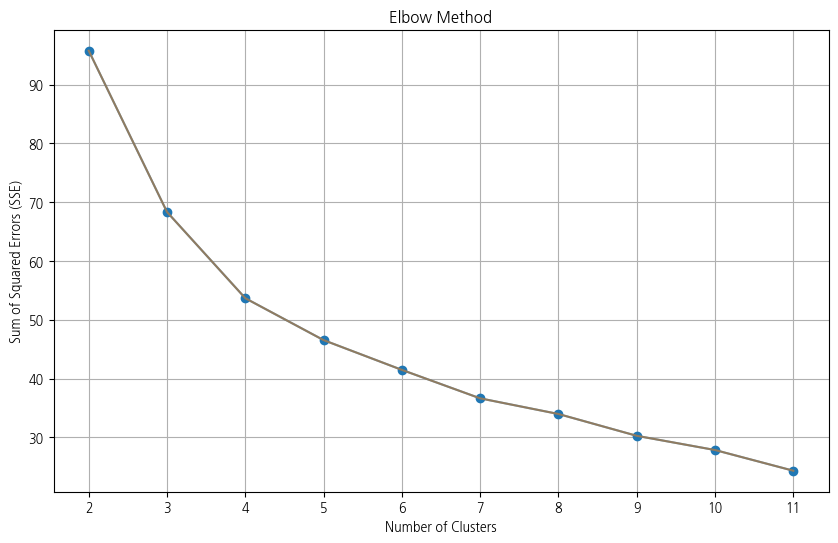

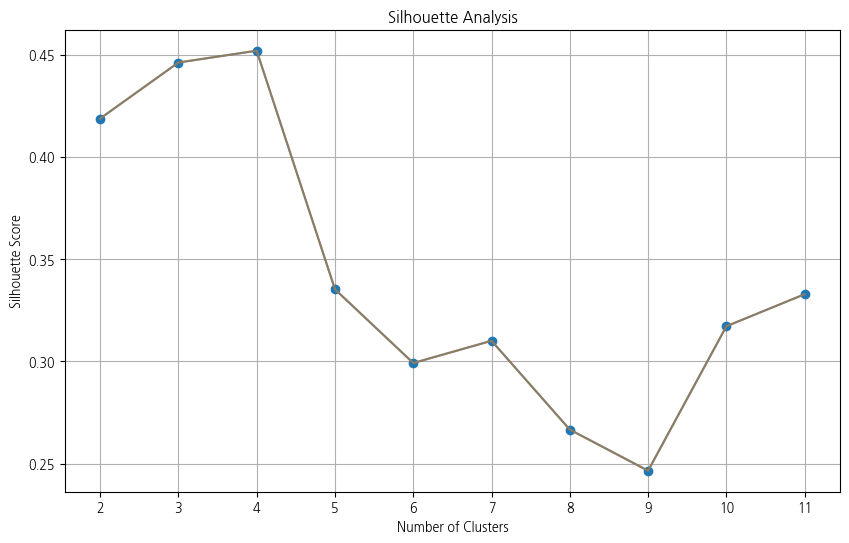

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# SSE 값을 저장할 빈 리스트 생성
sse = []

# KMeans 클러스터링을 위한 클러스터 수 범위 설정 (예: 2부터 11까지)
cluster_range = range(2, 12)

# 각 클러스터 수에 대해 KMeans 모델 생성 및 SSE 계산
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(normalized_pivot_combined)
    sse.append(kmeans.inertia_)

# Elbow Method를 위한 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, sse, marker='o')
plt.plot(cluster_range, sse, '-', alpha=0.5)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

# 실루엣 분석을 사용하여 최적의 K값 탐색
silhouette_scores = []
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(normalized_pivot_combined)
    score = silhouette_score(normalized_pivot_combined, kmeans.labels_)
    silhouette_scores.append(score)

# 실루엣 분석 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.plot(cluster_range, silhouette_scores, '-', alpha=0.5)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np

# SSE 값을 저장할 빈 리스트 생성
sse = []

# KMeans 클러스터링을 위한 클러스터 수 범위 설정 (예: 2부터 11까지)
cluster_range = range(2, 12)

# 각 클러스터 수에 대해 KMeans 모델 생성 및 SSE 계산
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(normalized_pivot_combined)
    sse.append(kmeans.inertia_)

import pandas as pd

# 각 클러스터 수에 대한 기울기(변화율) 계산
gradient = [sse[i] - sse[i-1] for i in range(1, len(sse))]

# 데이터프레임 생성
gradient_df = pd.DataFrame({
    'Number of Clusters': list(cluster_range)[1:],  # 클러스터 수
    'Gradient': gradient  # SSE 변화율
})

# 클러스터 수, SSE, 기울기, 감소율을 데이터프레임으로 정리
results_df = pd.DataFrame({
    'Number of Clusters': list(cluster_range[:-2]),
    'SSE': sse[:-2],
    'Gradient of SSE': gradients[:-1],
    'Decrease Rate': decrease_rates
})

# 감소율 결과를 포함한 표 출력
print(results_df)


   Number of Clusters   SSE  Gradient of SSE  Decrease Rate
0                   2 95.76           -27.43          -0.47
1                   3 68.33           -14.66          -0.51
2                   4 53.67            -7.13          -0.29
3                   5 46.54            -5.06          -0.04
4                   6 41.48            -4.84          -0.45
5                   7 36.64            -2.66           0.39
6                   8 33.98            -3.71          -0.35
7                   9 30.27            -2.42           0.46


### 클러스터링 및 시각화(n=4)

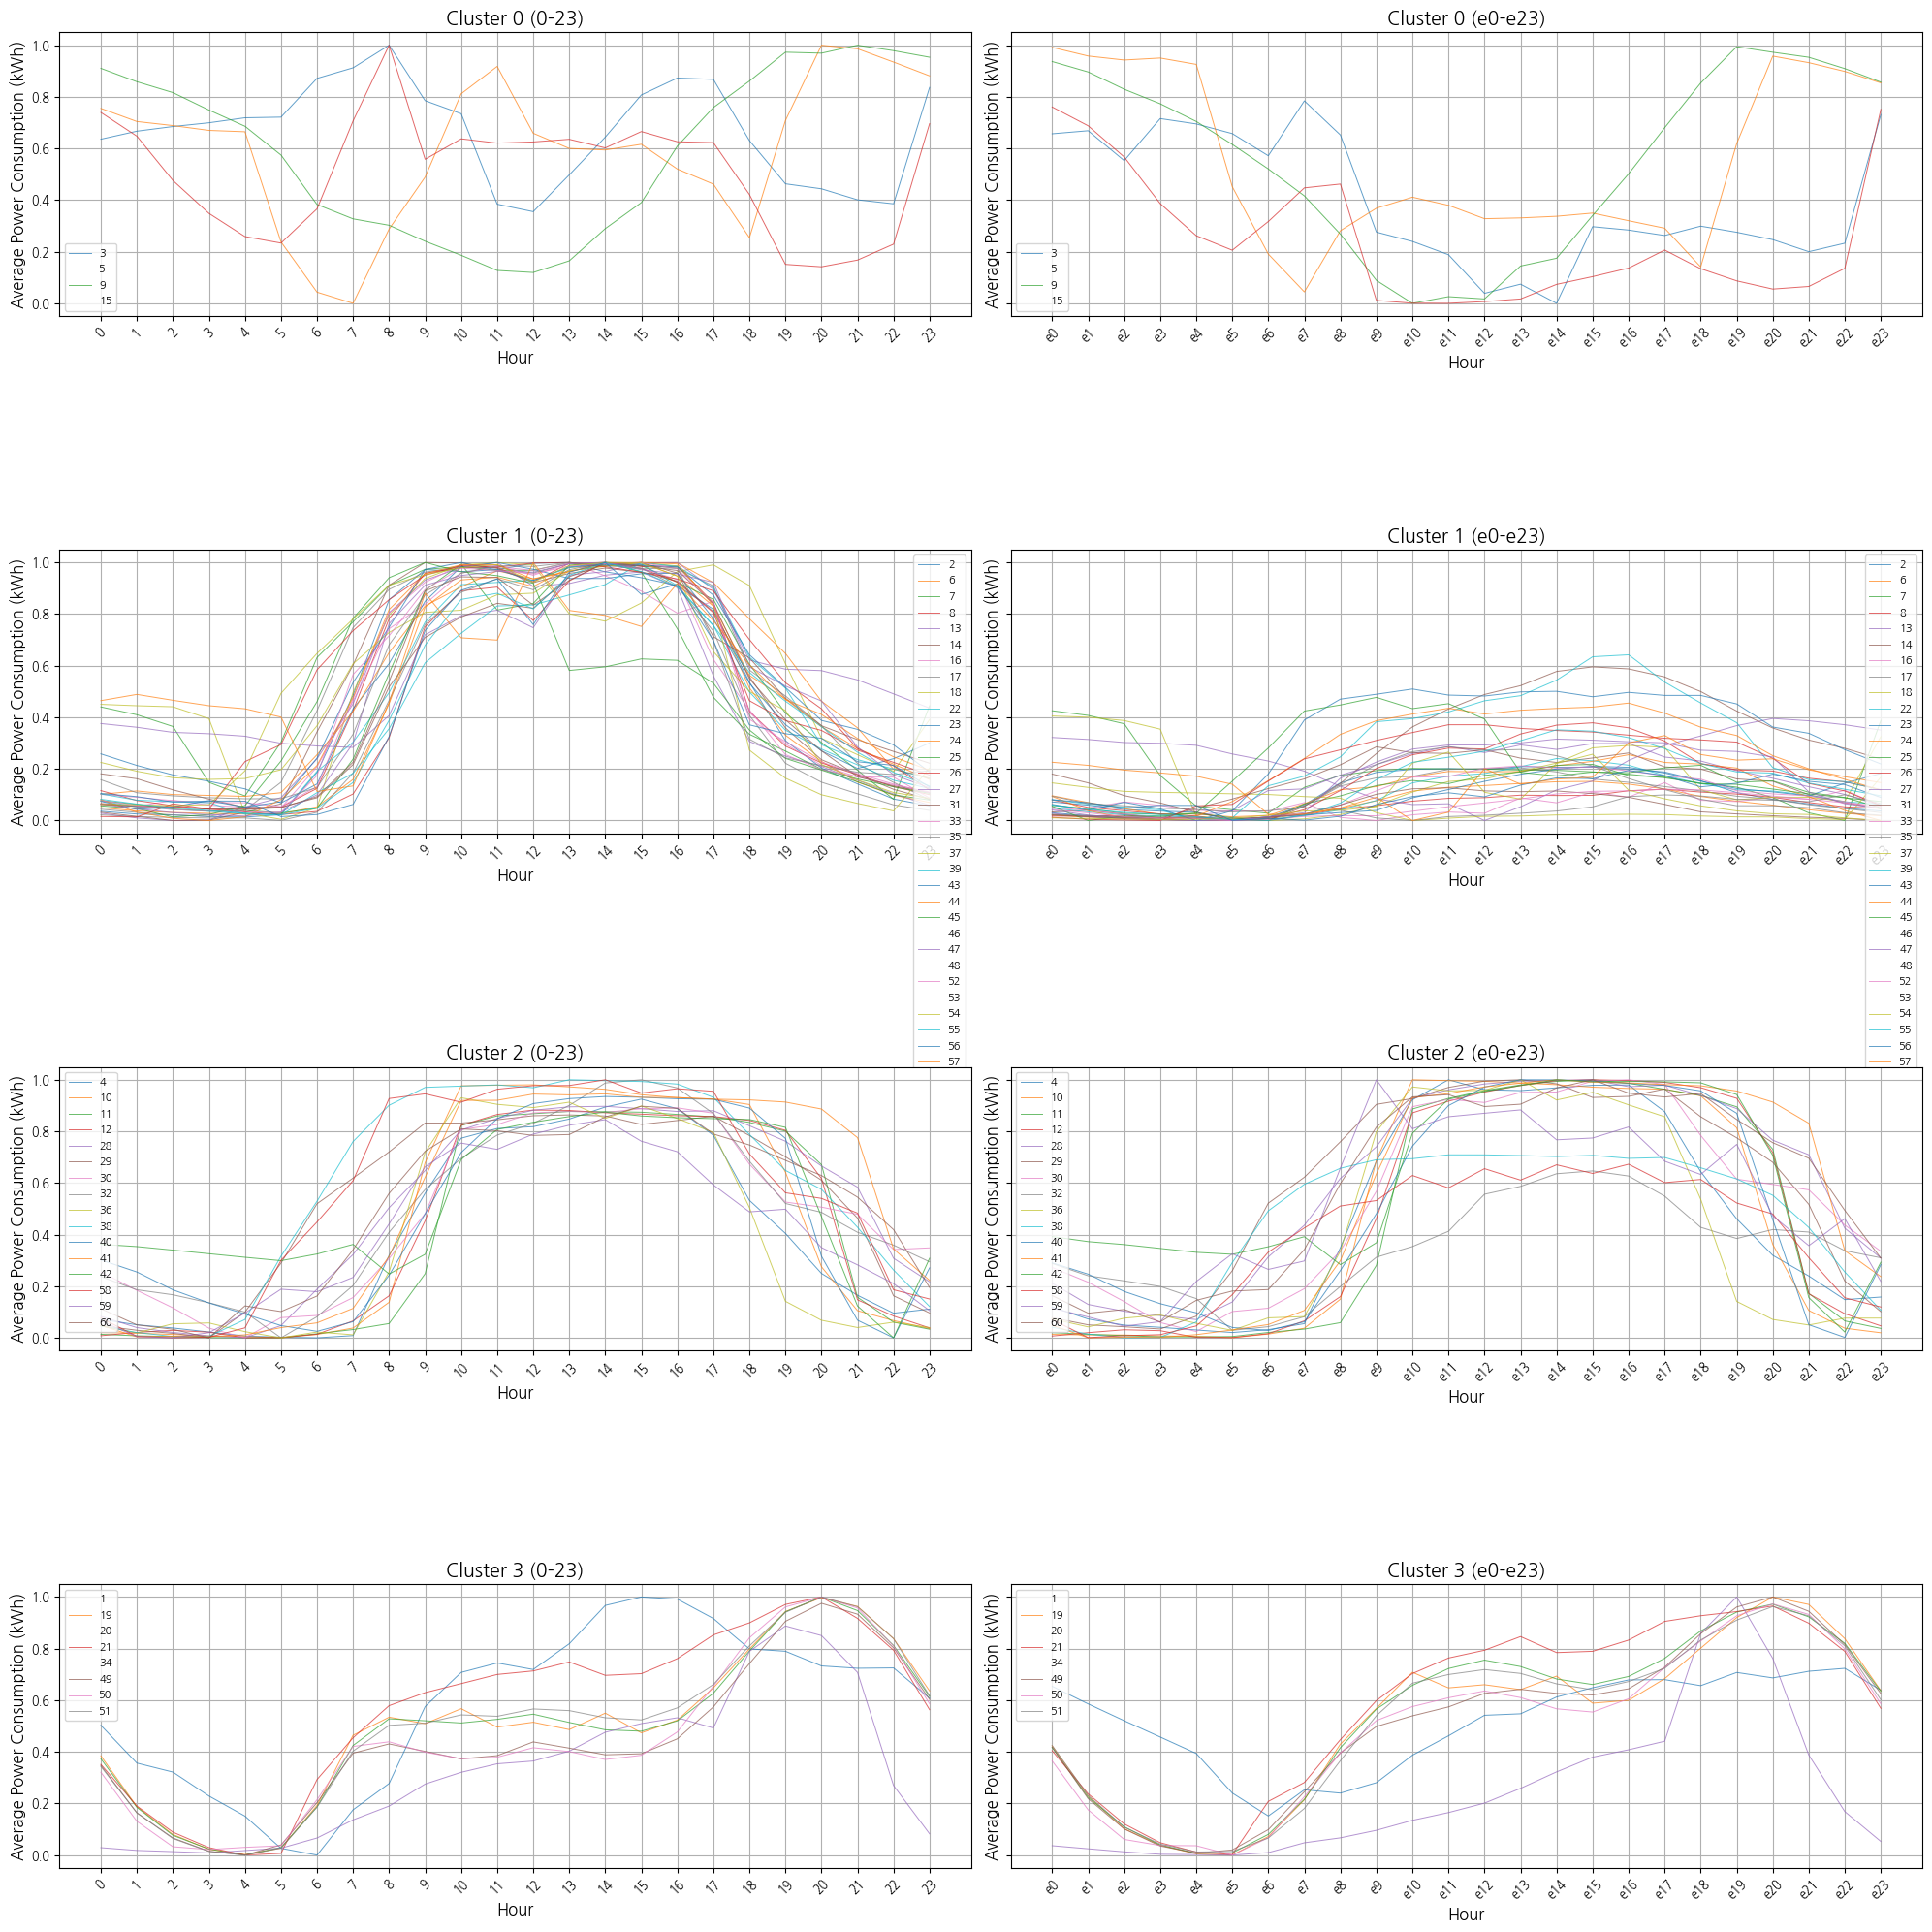

Cluster distribution_final:
Cluster
1    32
2    16
3     8
0     4
Name: count, dtype: int64

Buildings in Cluster 0:
[3, 5, 9, 15]

Buildings in Cluster 1:
[2, 6, 7, 8, 13, 14, 16, 17, 18, 22, 23, 24, 25, 26, 27, 31, 33, 35, 37, 39, 43, 44, 45, 46, 47, 48, 52, 53, 54, 55, 56, 57]

Buildings in Cluster 2:
[4, 10, 11, 12, 28, 29, 30, 32, 36, 38, 40, 41, 42, 58, 59, 60]

Buildings in Cluster 3:
[1, 19, 20, 21, 34, 49, 50, 51]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 난수 고정
np.random.seed(42)

# 정규화
scaler = StandardScaler()
normalized_pivot_combined_scaled = scaler.fit_transform(normalized_pivot_combined)

# K-평균 군집화 적용
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(normalized_pivot_combined_scaled)
labels = kmeans.labels_

# 군집화 결과를 데이터프레임에 추가
normalized_pivot_combined['Cluster'] = labels

# 0부터 23까지의 시간 데이터와 e0부터 e23까지의 데이터로 나누기
time_columns = [str(i) for i in range(24)]
e_time_columns = ['e' + str(i) for i in range(24)]

# 각 군집의 평균 전력 사용량 시각화 (subplot으로)
fig, axes = plt.subplots(4, 2, figsize=(20, 20), sharey=True)
axes = axes.flatten()

# 0부터 23까지의 시간 데이터
for i in range(4):
    cluster_data_final = normalized_pivot_combined[normalized_pivot_combined['Cluster'] == i][time_columns]
    for num in cluster_data_final.index:
        axes[2*i].plot(cluster_data_final.columns, cluster_data_final.loc[num], label=f'{num}', alpha=0.7, linewidth=0.7)
    axes[2*i].set_title(f'Cluster {i} (0-23)', fontsize=14)
    axes[2*i].set_xlabel('Hour', fontsize=12)
    axes[2*i].set_ylabel('Average Power Consumption (kWh)', fontsize=12)
    axes[2*i].tick_params(axis='x', rotation=45)
    axes[2*i].legend(fontsize=8)
    axes[2*i].grid(True)

# e0부터 e23까지의 시간 데이터
for i in range(4):
    cluster_data_final = normalized_pivot_combined[normalized_pivot_combined['Cluster'] == i][e_time_columns]
    for num in cluster_data_final.index:
        axes[2*i+1].plot(cluster_data_final.columns, cluster_data_final.loc[num], label=f'{num}', alpha=0.7, linewidth=0.7)
    axes[2*i+1].set_title(f'Cluster {i} (e0-e23)', fontsize=14)
    axes[2*i+1].set_xlabel('Hour', fontsize=12)
    axes[2*i+1].set_ylabel('Average Power Consumption (kWh)', fontsize=12)
    axes[2*i+1].tick_params(axis='x', rotation=45)
    axes[2*i+1].legend(fontsize=8)
    axes[2*i+1].grid(True)

plt.tight_layout()
plt.show()

# 군집별 건물 수 출력
cluster_distribution_final = normalized_pivot_combined['Cluster'].value_counts()
print("Cluster distribution_final:")
print(cluster_distribution_final)

# 군집별 건물 리스트 출력
for cluster_num in range(4):
    buildings_in_cluster_final = normalized_pivot_combined[normalized_pivot_combined['Cluster'] == cluster_num].index.tolist()
    print(f"\nBuildings in Cluster {cluster_num}:")
    print(buildings_in_cluster_final)

# 군집별 데이터프레임 저장
normalized_pivot_combined.reset_index().to_csv('clustered_buildings.csv', index=False)


In [ ]:
normalized_pivot_combined

hour    0    1    2    3    4    5    6    7    8    9  ...  e15  e16  e17  \
num                                                     ...                  
1    0.50 0.36 0.32 0.23 0.15 0.03 0.00 0.18 0.28 0.58  ... 0.65 0.68 0.68   
2    0.04 0.03 0.02 0.02 0.01 0.02 0.19 0.49 0.86 0.97  ... 0.21 0.20 0.19   
3    0.64 0.67 0.68 0.70 0.72 0.72 0.87 0.91 1.00 0.79  ... 0.30 0.28 0.26   
4    0.07 0.05 0.04 0.02 0.01 0.00 0.00 0.01 0.32 0.56  ... 0.98 0.98 0.88   
5    0.76 0.70 0.69 0.67 0.66 0.24 0.04 0.00 0.29 0.49  ... 0.35 0.32 0.29   
6    0.05 0.04 0.03 0.03 0.03 0.03 0.05 0.16 0.45 0.83  ... 0.15 0.14 0.12   
7    0.44 0.41 0.36 0.15 0.10 0.30 0.63 0.77 0.91 0.97  ... 0.19 0.18 0.17   
8    0.07 0.06 0.05 0.04 0.04 0.05 0.12 0.43 0.78 0.96  ... 0.10 0.12 0.12   
9    0.91 0.86 0.82 0.75 0.69 0.57 0.38 0.33 0.30 0.24  ... 0.34 0.50 0.68   
10   0.02 0.02 0.01 0.01 0.00 0.00 0.01 0.04 0.14 0.68  ... 0.97 0.97 0.96   
11   0.01 0.01 0.00 0.00 0.00 0.00 0.02 0.03 0.06 0.25  ... 1.00 0.99 0.96   
12   0.01 0.02 0.03 0.02 0.00 0.00 0.01 0.07 0.16 0.45  ... 1.00 1.00 0.99   
13   0.03 0.01 0.00 0.00 0.05 0.09 0.24 0.45 0.81 0.93  ... 0.30 0.30 0.25   
14   0.03 0.02 0.00 0.00 0.03 0.06 0.34 0.60 0.91 1.00  ... 0.24 0.26 0.21   
15   0.74 0.65 0.48 0.35 0.26 0.23 0.37 0.71 1.00 0.56  ... 0.10 0.14 0.21   
16   0.06 0.06 0.08 0.06 0.05 0.05 0.21 0.46 0.74 0.84  ... 0.11 0.09 0.15   
17   0.04 0.03 0.02 0.02 0.04 0.15 0.43 0.75 0.90 0.96  ... 0.16 0.15 0.13   
18   0.45 0.44 0.44 0.39 0.03 0.00 0.05 0.50 0.80 0.94  ... 0.28 0.29 0.28   
19   0.38 0.19 0.08 0.02 0.00 0.03 0.19 0.46 0.53 0.51  ... 0.59 0.60 0.68   
20   0.37 0.18 0.08 0.02 0.00 0.03 0.19 0.42 0.53 0.52  ... 0.66 0.69 0.76   
21   0.35 0.19 0.09 0.03 0.00 0.01 0.29 0.45 0.58 0.63  ... 0.79 0.83 0.91   
22   0.08 0.05 0.04 0.04 0.03 0.03 0.19 0.30 0.50 0.77  ... 0.23 0.21 0.17   
23   0.26 0.21 0.18 0.15 0.12 0.07 0.14 0.43 0.61 0.85  ... 0.21 0.21 0.18   
24   0.10 0.11 0.10 0.10 0.09 0.11 0.26 0.42 0.65 0.83  ... 0.23 0.26 0.23   
25   0.08 0.06 0.04 0.04 0.04 0.03 0.05 0.24 0.57 0.89  ... 0.22 0.17 0.17   
26   0.12 0.08 0.06 0.04 0.03 0.02 0.04 0.10 0.32 0.75  ... 0.38 0.36 0.31   
27   0.38 0.36 0.34 0.34 0.33 0.30 0.29 0.28 0.41 0.72  ... 0.15 0.23 0.29   
28   0.08 0.04 0.02 0.01 0.00 0.05 0.19 0.32 0.50 0.65  ... 1.00 0.97 0.98   
29   0.05 0.03 0.02 0.00 0.10 0.29 0.52 0.62 0.72 0.83  ... 0.93 0.94 0.96   
30   0.26 0.18 0.12 0.04 0.00 0.08 0.09 0.16 0.31 0.48  ... 0.99 1.00 0.98   
31   0.18 0.16 0.12 0.08 0.05 0.05 0.09 0.22 0.52 0.71  ... 0.60 0.59 0.56   
32   0.24 0.19 0.17 0.14 0.10 0.00 0.08 0.20 0.41 0.57  ... 0.65 0.63 0.55   
33   0.10 0.09 0.08 0.07 0.07 0.05 0.13 0.47 0.80 0.92  ... 0.21 0.19 0.17   
34   0.03 0.02 0.01 0.01 0.02 0.03 0.07 0.14 0.19 0.28  ... 0.38 0.41 0.44   
35   0.02 0.02 0.01 0.01 0.01 0.00 0.03 0.18 0.47 0.76  ... 0.21 0.16 0.12   
36   0.05 0.02 0.05 0.06 0.02 0.00 0.02 0.01 0.26 0.72  ... 0.95 0.90 0.86   
37   0.23 0.19 0.17 0.16 0.16 0.20 0.37 0.61 0.73 0.81  ... 0.02 0.02 0.02   
38   0.05 0.02 0.01 0.01 0.07 0.32 0.53 0.76 0.90 0.97  ... 0.71 0.70 0.70   
39   0.10 0.08 0.07 0.07 0.02 0.02 0.11 0.18 0.36 0.61  ... 0.63 0.64 0.54   
40   0.30 0.26 0.19 0.14 0.09 0.05 0.03 0.06 0.24 0.48  ... 0.99 0.99 0.98   
41   0.05 0.00 0.01 0.00 0.01 0.04 0.06 0.11 0.32 0.62  ... 0.99 0.99 0.98   
42   0.36 0.35 0.34 0.33 0.31 0.30 0.32 0.36 0.25 0.32  ... 0.99 0.99 0.99   
43   0.07 0.04 0.05 0.08 0.05 0.07 0.24 0.53 0.75 0.97  ... 0.48 0.50 0.48   
44   0.08 0.03 0.01 0.00 0.01 0.08 0.21 0.48 0.82 0.96  ... 0.44 0.46 0.42   
45   0.06 0.05 0.01 0.02 0.06 0.23 0.46 0.78 0.94 1.00  ... 0.19 0.19 0.20   
46   0.02 0.01 0.06 0.04 0.23 0.29 0.58 0.74 0.86 0.95  ... 0.34 0.33 0.32   
47   0.06 0.05 0.03 0.02 0.02 0.03 0.10 0.30 0.76 0.91  ... 0.31 0.31 0.30   
48   0.06 0.05 0.05 0.05 0.04 0.05 0.09 0.23 0.54 0.89  ... 0.10 0.09 0.06   
49   0.35 0.16 0.07 0.01 0.00 0.04 0.20 0.39 0.43 0.40  ... 0.62 0.64 0.73   
50   0.32 0.13 0.03 0.

#### 실루엣 계수

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
silhouette_avg = silhouette_score(normalized_pivot_combined.iloc[:,:-1], normalized_pivot_combined.iloc[:,-1])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.4519121761129534


In [ ]:
print(silhouette_score(normalized_pivot_combined.iloc[:,:-1], normalized_pivot_combined.iloc[:,-1], metric='euclidean'))

0.4519121761129534


In [ ]:
normalized_pivot_combined.iloc[:,:-1]

hour    0    1    2    3    4    5    6    7    8    9  ...  e14  e15  e16  \
num                                                     ...                  
1    0.50 0.36 0.32 0.23 0.15 0.03 0.00 0.18 0.28 0.58  ... 0.61 0.65 0.68   
2    0.04 0.03 0.02 0.02 0.01 0.02 0.19 0.49 0.86 0.97  ... 0.21 0.21 0.20   
3    0.64 0.67 0.68 0.70 0.72 0.72 0.87 0.91 1.00 0.79  ... 0.00 0.30 0.28   
4    0.07 0.05 0.04 0.02 0.01 0.00 0.00 0.01 0.32 0.56  ... 0.97 0.98 0.98   
5    0.76 0.70 0.69 0.67 0.66 0.24 0.04 0.00 0.29 0.49  ... 0.34 0.35 0.32   
6    0.05 0.04 0.03 0.03 0.03 0.03 0.05 0.16 0.45 0.83  ... 0.15 0.15 0.14   
7    0.44 0.41 0.36 0.15 0.10 0.30 0.63 0.77 0.91 0.97  ... 0.19 0.19 0.18   
8    0.07 0.06 0.05 0.04 0.04 0.05 0.12 0.43 0.78 0.96  ... 0.10 0.10 0.12   
9    0.91 0.86 0.82 0.75 0.69 0.57 0.38 0.33 0.30 0.24  ... 0.17 0.34 0.50   
10   0.02 0.02 0.01 0.01 0.00 0.00 0.01 0.04 0.14 0.68  ... 0.98 0.97 0.97   
11   0.01 0.01 0.00 0.00 0.00 0.00 0.02 0.03 0.06 0.25  ... 0.99 1.00 0.99   
12   0.01 0.02 0.03 0.02 0.00 0.00 0.01 0.07 0.16 0.45  ... 1.00 1.00 1.00   
13   0.03 0.01 0.00 0.00 0.05 0.09 0.24 0.45 0.81 0.93  ... 0.28 0.30 0.30   
14   0.03 0.02 0.00 0.00 0.03 0.06 0.34 0.60 0.91 1.00  ... 0.23 0.24 0.26   
15   0.74 0.65 0.48 0.35 0.26 0.23 0.37 0.71 1.00 0.56  ... 0.07 0.10 0.14   
16   0.06 0.06 0.08 0.06 0.05 0.05 0.21 0.46 0.74 0.84  ... 0.07 0.11 0.09   
17   0.04 0.03 0.02 0.02 0.04 0.15 0.43 0.75 0.90 0.96  ... 0.19 0.16 0.15   
18   0.45 0.44 0.44 0.39 0.03 0.00 0.05 0.50 0.80 0.94  ... 0.22 0.28 0.29   
19   0.38 0.19 0.08 0.02 0.00 0.03 0.19 0.46 0.53 0.51  ... 0.69 0.59 0.60   
20   0.37 0.18 0.08 0.02 0.00 0.03 0.19 0.42 0.53 0.52  ... 0.68 0.66 0.69   
21   0.35 0.19 0.09 0.03 0.00 0.01 0.29 0.45 0.58 0.63  ... 0.78 0.79 0.83   
22   0.08 0.05 0.04 0.04 0.03 0.03 0.19 0.30 0.50 0.77  ... 0.24 0.23 0.21   
23   0.26 0.21 0.18 0.15 0.12 0.07 0.14 0.43 0.61 0.85  ... 0.20 0.21 0.21   
24   0.10 0.11 0.10 0.10 0.09 0.11 0.26 0.42 0.65 0.83  ... 0.21 0.23 0.26   
25   0.08 0.06 0.04 0.04 0.04 0.03 0.05 0.24 0.57 0.89  ... 0.21 0.22 0.17   
26   0.12 0.08 0.06 0.04 0.03 0.02 0.04 0.10 0.32 0.75  ... 0.37 0.38 0.36   
27   0.38 0.36 0.34 0.34 0.33 0.30 0.29 0.28 0.41 0.72  ... 0.12 0.15 0.23   
28   0.08 0.04 0.02 0.01 0.00 0.05 0.19 0.32 0.50 0.65  ... 1.00 1.00 0.97   
29   0.05 0.03 0.02 0.00 0.10 0.29 0.52 0.62 0.72 0.83  ... 0.98 0.93 0.94   
30   0.26 0.18 0.12 0.04 0.00 0.08 0.09 0.16 0.31 0.48  ... 0.95 0.99 1.00   
31   0.18 0.16 0.12 0.08 0.05 0.05 0.09 0.22 0.52 0.71  ... 0.58 0.60 0.59   
32   0.24 0.19 0.17 0.14 0.10 0.00 0.08 0.20 0.41 0.57  ... 0.64 0.65 0.63   
33   0.10 0.09 0.08 0.07 0.07 0.05 0.13 0.47 0.80 0.92  ... 0.20 0.21 0.19   
34   0.03 0.02 0.01 0.01 0.02 0.03 0.07 0.14 0.19 0.28  ... 0.32 0.38 0.41   
35   0.02 0.02 0.01 0.01 0.01 0.00 0.03 0.18 0.47 0.76  ... 0.25 0.21 0.16   
36   0.05 0.02 0.05 0.06 0.02 0.00 0.02 0.01 0.26 0.72  ... 0.92 0.95 0.90   
37   0.23 0.19 0.17 0.16 0.16 0.20 0.37 0.61 0.73 0.81  ... 0.02 0.02 0.02   
38   0.05 0.02 0.01 0.01 0.07 0.32 0.53 0.76 0.90 0.97  ... 0.70 0.71 0.70   
39   0.10 0.08 0.07 0.07 0.02 0.02 0.11 0.18 0.36 0.61  ... 0.54 0.63 0.64   
40   0.30 0.26 0.19 0.14 0.09 0.05 0.03 0.06 0.24 0.48  ... 1.00 0.99 0.99   
41   0.05 0.00 0.01 0.00 0.01 0.04 0.06 0.11 0.32 0.62  ... 1.00 0.99 0.99   
42   0.36 0.35 0.34 0.33 0.31 0.30 0.32 0.36 0.25 0.32  ... 1.00 0.99 0.99   
43   0.07 0.04 0.05 0.08 0.05 0.07 0.24 0.53 0.75 0.97  ... 0.50 0.48 0.50   
44   0.08 0.03 0.01 0.00 0.01 0.08 0.21 0.48 0.82 0.96  ... 0.43 0.44 0.46   
45   0.06 0.05 0.01 0.02 0.06 0.23 0.46 0.78 0.94 1.00  ... 0.17 0.19 0.19   
46   0.02 0.01 0.06 0.04 0.23 0.29 0.58 0.74 0.86 0.95  ... 0.35 0.34 0.33   
47   0.06 0.05 0.03 0.02 0.02 0.03 0.10 0.30 0.76 0.91  ... 0.32 0.31 0.31   
48   0.06 0.05 0.05 0.05 0.04 0.05 0.09 0.23 0.54 0.89  ... 0.11 0.10 0.09   
49   0.35 0.16 0.07 0.01 0.00 0.04 0.20 0.39 0.43 0.40  ... 0.63 0.62 0.64   
50   0.32 0.13 0.03 0.

In [ ]:
normalized_pivot_combined.iloc[:,-1]

num
1     3
2     1
3     0
4     2
5     0
6     1
7     1
8     1
9     0
10    2
11    2
12    2
13    1
14    1
15    0
16    1
17    1
18    1
19    3
20    3
21    3
22    1
23    1
24    1
25    1
26    1
27    1
28    2
29    2
30    2
31    1
32    2
33    1
34    3
35    1
36    2
37    1
38    2
39    1
40    2
41    2
42    2
43    1
44    1
45    1
46    1
47    1
48    1
49    3
50    3
51    3
52    1
53    1
54    1
55    1
56    1
57    1
58    2
59    2
60    2
Name: Cluster, dtype: int32

### 클러스터링 및 시각화(n=5)

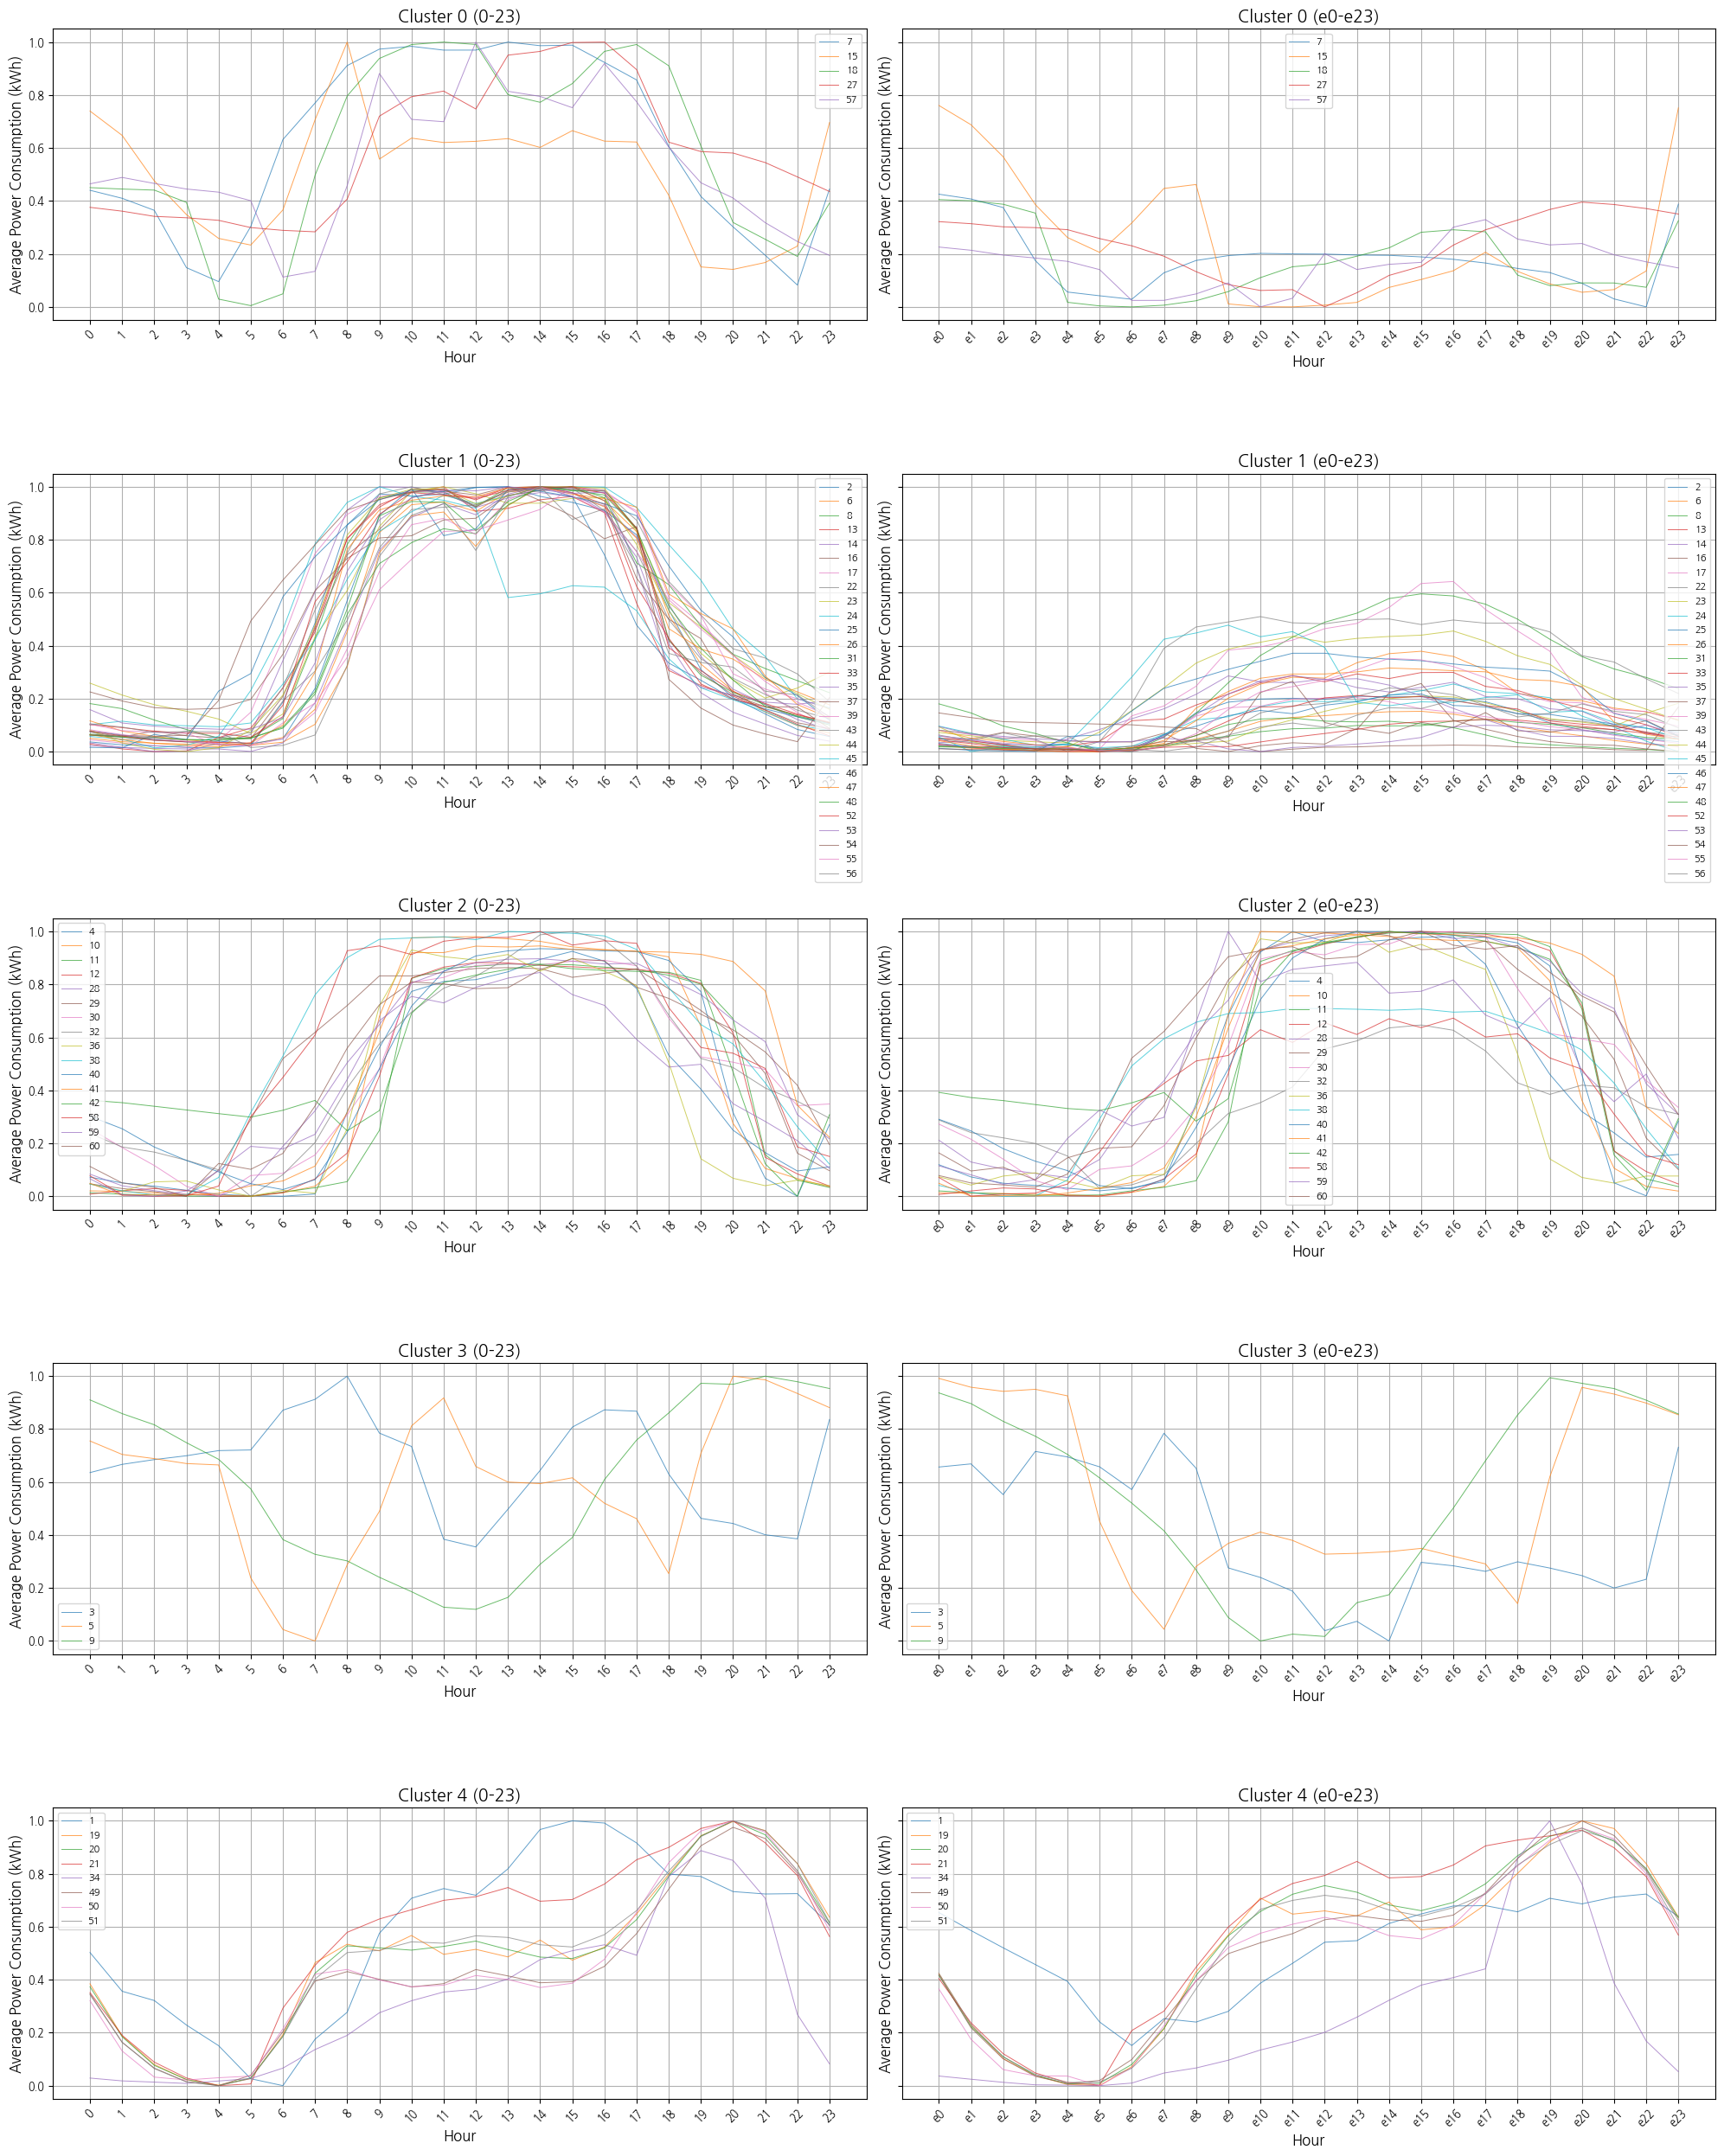

Cluster distribution_final:
Cluster
1    28
2    16
4     8
0     5
3     3
Name: count, dtype: int64

Buildings in Cluster 0:
[7, 15, 18, 27, 57]

Buildings in Cluster 1:
[2, 6, 8, 13, 14, 16, 17, 22, 23, 24, 25, 26, 31, 33, 35, 37, 39, 43, 44, 45, 46, 47, 48, 52, 53, 54, 55, 56]

Buildings in Cluster 2:
[4, 10, 11, 12, 28, 29, 30, 32, 36, 38, 40, 41, 42, 58, 59, 60]

Buildings in Cluster 3:
[3, 5, 9]

Buildings in Cluster 4:
[1, 19, 20, 21, 34, 49, 50, 51]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 데이터 불러오기 (예시 데이터 로드)
# normalized_pivot_combined = pd.read_csv('your_data.csv')

# 난수 고정
np.random.seed(42)

# 데이터 섞기 (필요한 경우)
# normalized_pivot_combined = normalized_pivot_combined.sample(frac=1, random_state=42).reset_index(drop=True)

# 정규화
scaler = StandardScaler()
normalized_pivot_combined_scaled = scaler.fit_transform(normalized_pivot_combined)

# K-평균 군집화 적용
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans.fit(normalized_pivot_combined_scaled)
labels = kmeans.labels_

# 군집화 결과를 데이터프레임에 추가
normalized_pivot_combined['Cluster'] = labels

# 0부터 23까지의 시간 데이터와 e0부터 e23까지의 데이터로 나누기
time_columns = [str(i) for i in range(24)]
e_time_columns = ['e' + str(i) for i in range(24)]

# 각 군집의 평균 전력 사용량 시각화 (subplot으로)
fig, axes = plt.subplots(5, 2, figsize=(20, 25), sharey=True)
axes = axes.flatten()

# 0부터 23까지의 시간 데이터
for i in range(5):
    cluster_data_final = normalized_pivot_combined[normalized_pivot_combined['Cluster'] == i][time_columns]
    for num in cluster_data_final.index:
        axes[2*i].plot(cluster_data_final.columns, cluster_data_final.loc[num], label=f'{num}', alpha=0.7, linewidth=0.7)
    axes[2*i].set_title(f'Cluster {i} (0-23)', fontsize=14)
    axes[2*i].set_xlabel('Hour', fontsize=12)
    axes[2*i].set_ylabel('Average Power Consumption (kWh)', fontsize=12)
    axes[2*i].tick_params(axis='x', rotation=45)
    axes[2*i].legend(fontsize=8)
    axes[2*i].grid(True)

# e0부터 e23까지의 시간 데이터
for i in range(5):
    cluster_data_final = normalized_pivot_combined[normalized_pivot_combined['Cluster'] == i][e_time_columns]
    for num in cluster_data_final.index:
        axes[2*i+1].plot(cluster_data_final.columns, cluster_data_final.loc[num], label=f'{num}', alpha=0.7, linewidth=0.7)
    axes[2*i+1].set_title(f'Cluster {i} (e0-e23)', fontsize=14)
    axes[2*i+1].set_xlabel('Hour', fontsize=12)
    axes[2*i+1].set_ylabel('Average Power Consumption (kWh)', fontsize=12)
    axes[2*i+1].tick_params(axis='x', rotation=45)
    axes[2*i+1].legend(fontsize=8)
    axes[2*i+1].grid(True)

plt.tight_layout()
plt.show()

# 군집별 건물 수 출력
cluster_distribution_final = normalized_pivot_combined['Cluster'].value_counts()
print("Cluster distribution_final:")
print(cluster_distribution_final)

# 군집별 건물 리스트 출력
for cluster_num in range(5):
    buildings_in_cluster_final = normalized_pivot_combined[normalized_pivot_combined['Cluster'] == cluster_num].index.tolist()
    print(f"\nBuildings in Cluster {cluster_num}:")
    print(buildings_in_cluster_final)

# 군집별 데이터프레임 저장
normalized_pivot_combined.reset_index().to_csv('clustered_buildings.csv', index=False)


In [ ]:
normalized_pivot_combined

hour    0    1    2    3    4    5    6    7    8    9  ...  e15  e16  e17  \
num                                                     ...                  
1    0.50 0.36 0.32 0.23 0.15 0.03 0.00 0.18 0.28 0.58  ... 0.65 0.68 0.68   
2    0.04 0.03 0.02 0.02 0.01 0.02 0.19 0.49 0.86 0.97  ... 0.21 0.20 0.19   
3    0.64 0.67 0.68 0.70 0.72 0.72 0.87 0.91 1.00 0.79  ... 0.30 0.28 0.26   
4    0.07 0.05 0.04 0.02 0.01 0.00 0.00 0.01 0.32 0.56  ... 0.98 0.98 0.88   
5    0.76 0.70 0.69 0.67 0.66 0.24 0.04 0.00 0.29 0.49  ... 0.35 0.32 0.29   
6    0.05 0.04 0.03 0.03 0.03 0.03 0.05 0.16 0.45 0.83  ... 0.15 0.14 0.12   
7    0.44 0.41 0.36 0.15 0.10 0.30 0.63 0.77 0.91 0.97  ... 0.19 0.18 0.17   
8    0.07 0.06 0.05 0.04 0.04 0.05 0.12 0.43 0.78 0.96  ... 0.10 0.12 0.12   
9    0.91 0.86 0.82 0.75 0.69 0.57 0.38 0.33 0.30 0.24  ... 0.34 0.50 0.68   
10   0.02 0.02 0.01 0.01 0.00 0.00 0.01 0.04 0.14 0.68  ... 0.97 0.97 0.96   
11   0.01 0.01 0.00 0.00 0.00 0.00 0.02 0.03 0.06 0.25  ... 1.00 0.99 0.96   
12   0.01 0.02 0.03 0.02 0.00 0.00 0.01 0.07 0.16 0.45  ... 1.00 1.00 0.99   
13   0.03 0.01 0.00 0.00 0.05 0.09 0.24 0.45 0.81 0.93  ... 0.30 0.30 0.25   
14   0.03 0.02 0.00 0.00 0.03 0.06 0.34 0.60 0.91 1.00  ... 0.24 0.26 0.21   
15   0.74 0.65 0.48 0.35 0.26 0.23 0.37 0.71 1.00 0.56  ... 0.10 0.14 0.21   
16   0.06 0.06 0.08 0.06 0.05 0.05 0.21 0.46 0.74 0.84  ... 0.11 0.09 0.15   
17   0.04 0.03 0.02 0.02 0.04 0.15 0.43 0.75 0.90 0.96  ... 0.16 0.15 0.13   
18   0.45 0.44 0.44 0.39 0.03 0.00 0.05 0.50 0.80 0.94  ... 0.28 0.29 0.28   
19   0.38 0.19 0.08 0.02 0.00 0.03 0.19 0.46 0.53 0.51  ... 0.59 0.60 0.68   
20   0.37 0.18 0.08 0.02 0.00 0.03 0.19 0.42 0.53 0.52  ... 0.66 0.69 0.76   
21   0.35 0.19 0.09 0.03 0.00 0.01 0.29 0.45 0.58 0.63  ... 0.79 0.83 0.91   
22   0.08 0.05 0.04 0.04 0.03 0.03 0.19 0.30 0.50 0.77  ... 0.23 0.21 0.17   
23   0.26 0.21 0.18 0.15 0.12 0.07 0.14 0.43 0.61 0.85  ... 0.21 0.21 0.18   
24   0.10 0.11 0.10 0.10 0.09 0.11 0.26 0.42 0.65 0.83  ... 0.23 0.26 0.23   
25   0.08 0.06 0.04 0.04 0.04 0.03 0.05 0.24 0.57 0.89  ... 0.22 0.17 0.17   
26   0.12 0.08 0.06 0.04 0.03 0.02 0.04 0.10 0.32 0.75  ... 0.38 0.36 0.31   
27   0.38 0.36 0.34 0.34 0.33 0.30 0.29 0.28 0.41 0.72  ... 0.15 0.23 0.29   
28   0.08 0.04 0.02 0.01 0.00 0.05 0.19 0.32 0.50 0.65  ... 1.00 0.97 0.98   
29   0.05 0.03 0.02 0.00 0.10 0.29 0.52 0.62 0.72 0.83  ... 0.93 0.94 0.96   
30   0.26 0.18 0.12 0.04 0.00 0.08 0.09 0.16 0.31 0.48  ... 0.99 1.00 0.98   
31   0.18 0.16 0.12 0.08 0.05 0.05 0.09 0.22 0.52 0.71  ... 0.60 0.59 0.56   
32   0.24 0.19 0.17 0.14 0.10 0.00 0.08 0.20 0.41 0.57  ... 0.65 0.63 0.55   
33   0.10 0.09 0.08 0.07 0.07 0.05 0.13 0.47 0.80 0.92  ... 0.21 0.19 0.17   
34   0.03 0.02 0.01 0.01 0.02 0.03 0.07 0.14 0.19 0.28  ... 0.38 0.41 0.44   
35   0.02 0.02 0.01 0.01 0.01 0.00 0.03 0.18 0.47 0.76  ... 0.21 0.16 0.12   
36   0.05 0.02 0.05 0.06 0.02 0.00 0.02 0.01 0.26 0.72  ... 0.95 0.90 0.86   
37   0.23 0.19 0.17 0.16 0.16 0.20 0.37 0.61 0.73 0.81  ... 0.02 0.02 0.02   
38   0.05 0.02 0.01 0.01 0.07 0.32 0.53 0.76 0.90 0.97  ... 0.71 0.70 0.70   
39   0.10 0.08 0.07 0.07 0.02 0.02 0.11 0.18 0.36 0.61  ... 0.63 0.64 0.54   
40   0.30 0.26 0.19 0.14 0.09 0.05 0.03 0.06 0.24 0.48  ... 0.99 0.99 0.98   
41   0.05 0.00 0.01 0.00 0.01 0.04 0.06 0.11 0.32 0.62  ... 0.99 0.99 0.98   
42   0.36 0.35 0.34 0.33 0.31 0.30 0.32 0.36 0.25 0.32  ... 0.99 0.99 0.99   
43   0.07 0.04 0.05 0.08 0.05 0.07 0.24 0.53 0.75 0.97  ... 0.48 0.50 0.48   
44   0.08 0.03 0.01 0.00 0.01 0.08 0.21 0.48 0.82 0.96  ... 0.44 0.46 0.42   
45   0.06 0.05 0.01 0.02 0.06 0.23 0.46 0.78 0.94 1.00  ... 0.19 0.19 0.20   
46   0.02 0.01 0.06 0.04 0.23 0.29 0.58 0.74 0.86 0.95  ... 0.34 0.33 0.32   
47   0.06 0.05 0.03 0.02 0.02 0.03 0.10 0.30 0.76 0.91  ... 0.31 0.31 0.30   
48   0.06 0.05 0.05 0.05 0.04 0.05 0.09 0.23 0.54 0.89  ... 0.10 0.09 0.06   
49   0.35 0.16 0.07 0.01 0.00 0.04 0.20 0.39 0.43 0.40  ... 0.62 0.64 0.73   
50   0.32 0.13 0.03 0.

#### 실루엣 계수

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
silhouette_avg = silhouette_score(normalized_pivot_combined.iloc[:,:-1], normalized_pivot_combined.iloc[:,-1])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.3543299224103745


In [ ]:
normalized_pivot_combined.iloc[:,:-1]

hour    0    1    2    3    4    5    6    7    8    9  ...  e14  e15  e16  \
num                                                     ...                  
1    0.50 0.36 0.32 0.23 0.15 0.03 0.00 0.18 0.28 0.58  ... 0.61 0.65 0.68   
2    0.04 0.03 0.02 0.02 0.01 0.02 0.19 0.49 0.86 0.97  ... 0.21 0.21 0.20   
3    0.64 0.67 0.68 0.70 0.72 0.72 0.87 0.91 1.00 0.79  ... 0.00 0.30 0.28   
4    0.07 0.05 0.04 0.02 0.01 0.00 0.00 0.01 0.32 0.56  ... 0.97 0.98 0.98   
5    0.76 0.70 0.69 0.67 0.66 0.24 0.04 0.00 0.29 0.49  ... 0.34 0.35 0.32   
6    0.05 0.04 0.03 0.03 0.03 0.03 0.05 0.16 0.45 0.83  ... 0.15 0.15 0.14   
7    0.44 0.41 0.36 0.15 0.10 0.30 0.63 0.77 0.91 0.97  ... 0.19 0.19 0.18   
8    0.07 0.06 0.05 0.04 0.04 0.05 0.12 0.43 0.78 0.96  ... 0.10 0.10 0.12   
9    0.91 0.86 0.82 0.75 0.69 0.57 0.38 0.33 0.30 0.24  ... 0.17 0.34 0.50   
10   0.02 0.02 0.01 0.01 0.00 0.00 0.01 0.04 0.14 0.68  ... 0.98 0.97 0.97   
11   0.01 0.01 0.00 0.00 0.00 0.00 0.02 0.03 0.06 0.25  ... 0.99 1.00 0.99   
12   0.01 0.02 0.03 0.02 0.00 0.00 0.01 0.07 0.16 0.45  ... 1.00 1.00 1.00   
13   0.03 0.01 0.00 0.00 0.05 0.09 0.24 0.45 0.81 0.93  ... 0.28 0.30 0.30   
14   0.03 0.02 0.00 0.00 0.03 0.06 0.34 0.60 0.91 1.00  ... 0.23 0.24 0.26   
15   0.74 0.65 0.48 0.35 0.26 0.23 0.37 0.71 1.00 0.56  ... 0.07 0.10 0.14   
16   0.06 0.06 0.08 0.06 0.05 0.05 0.21 0.46 0.74 0.84  ... 0.07 0.11 0.09   
17   0.04 0.03 0.02 0.02 0.04 0.15 0.43 0.75 0.90 0.96  ... 0.19 0.16 0.15   
18   0.45 0.44 0.44 0.39 0.03 0.00 0.05 0.50 0.80 0.94  ... 0.22 0.28 0.29   
19   0.38 0.19 0.08 0.02 0.00 0.03 0.19 0.46 0.53 0.51  ... 0.69 0.59 0.60   
20   0.37 0.18 0.08 0.02 0.00 0.03 0.19 0.42 0.53 0.52  ... 0.68 0.66 0.69   
21   0.35 0.19 0.09 0.03 0.00 0.01 0.29 0.45 0.58 0.63  ... 0.78 0.79 0.83   
22   0.08 0.05 0.04 0.04 0.03 0.03 0.19 0.30 0.50 0.77  ... 0.24 0.23 0.21   
23   0.26 0.21 0.18 0.15 0.12 0.07 0.14 0.43 0.61 0.85  ... 0.20 0.21 0.21   
24   0.10 0.11 0.10 0.10 0.09 0.11 0.26 0.42 0.65 0.83  ... 0.21 0.23 0.26   
25   0.08 0.06 0.04 0.04 0.04 0.03 0.05 0.24 0.57 0.89  ... 0.21 0.22 0.17   
26   0.12 0.08 0.06 0.04 0.03 0.02 0.04 0.10 0.32 0.75  ... 0.37 0.38 0.36   
27   0.38 0.36 0.34 0.34 0.33 0.30 0.29 0.28 0.41 0.72  ... 0.12 0.15 0.23   
28   0.08 0.04 0.02 0.01 0.00 0.05 0.19 0.32 0.50 0.65  ... 1.00 1.00 0.97   
29   0.05 0.03 0.02 0.00 0.10 0.29 0.52 0.62 0.72 0.83  ... 0.98 0.93 0.94   
30   0.26 0.18 0.12 0.04 0.00 0.08 0.09 0.16 0.31 0.48  ... 0.95 0.99 1.00   
31   0.18 0.16 0.12 0.08 0.05 0.05 0.09 0.22 0.52 0.71  ... 0.58 0.60 0.59   
32   0.24 0.19 0.17 0.14 0.10 0.00 0.08 0.20 0.41 0.57  ... 0.64 0.65 0.63   
33   0.10 0.09 0.08 0.07 0.07 0.05 0.13 0.47 0.80 0.92  ... 0.20 0.21 0.19   
34   0.03 0.02 0.01 0.01 0.02 0.03 0.07 0.14 0.19 0.28  ... 0.32 0.38 0.41   
35   0.02 0.02 0.01 0.01 0.01 0.00 0.03 0.18 0.47 0.76  ... 0.25 0.21 0.16   
36   0.05 0.02 0.05 0.06 0.02 0.00 0.02 0.01 0.26 0.72  ... 0.92 0.95 0.90   
37   0.23 0.19 0.17 0.16 0.16 0.20 0.37 0.61 0.73 0.81  ... 0.02 0.02 0.02   
38   0.05 0.02 0.01 0.01 0.07 0.32 0.53 0.76 0.90 0.97  ... 0.70 0.71 0.70   
39   0.10 0.08 0.07 0.07 0.02 0.02 0.11 0.18 0.36 0.61  ... 0.54 0.63 0.64   
40   0.30 0.26 0.19 0.14 0.09 0.05 0.03 0.06 0.24 0.48  ... 1.00 0.99 0.99   
41   0.05 0.00 0.01 0.00 0.01 0.04 0.06 0.11 0.32 0.62  ... 1.00 0.99 0.99   
42   0.36 0.35 0.34 0.33 0.31 0.30 0.32 0.36 0.25 0.32  ... 1.00 0.99 0.99   
43   0.07 0.04 0.05 0.08 0.05 0.07 0.24 0.53 0.75 0.97  ... 0.50 0.48 0.50   
44   0.08 0.03 0.01 0.00 0.01 0.08 0.21 0.48 0.82 0.96  ... 0.43 0.44 0.46   
45   0.06 0.05 0.01 0.02 0.06 0.23 0.46 0.78 0.94 1.00  ... 0.17 0.19 0.19   
46   0.02 0.01 0.06 0.04 0.23 0.29 0.58 0.74 0.86 0.95  ... 0.35 0.34 0.33   
47   0.06 0.05 0.03 0.02 0.02 0.03 0.10 0.30 0.76 0.91  ... 0.32 0.31 0.31   
48   0.06 0.05 0.05 0.05 0.04 0.05 0.09 0.23 0.54 0.89  ... 0.11 0.10 0.09   
49   0.35 0.16 0.07 0.01 0.00 0.04 0.20 0.39 0.43 0.40  ... 0.63 0.62 0.64   
50   0.32 0.13 0.03 0.

## 4. 군집 별 예측 모델 구축

In [ ]:
train_df_origin = train_df.copy()

# 군집 정의
clusters = {
    0: [3, 5, 9, 15],
    1: [2, 6, 7, 8, 13, 14, 16, 17, 18, 22, 23, 24, 25, 26, 27, 31, 32, 33, 35, 37, 39, 43, 44, 45, 46, 47, 48, 52, 53, 54, 55, 56, 57],
    2: [4, 10, 11, 12, 28, 29, 30, 36, 38, 40, 41, 42, 58, 59, 60],
    3: [1, 19, 20, 21, 34, 49, 50, 51]
}



# 'cluster' 변수 추가
train_df['cluster'] = np.nan
train_df.loc[train_df['num'].isin([3, 5, 9, 15]), 'cluster'] = 0
train_df.loc[train_df['num'].isin([2, 6, 7, 8, 13, 14, 16, 17, 18, 22, 23, 24, 25, 26, 27, 31, 32, 33, 35, 37, 39, 43, 44, 45, 46, 47, 48, 52, 53, 54, 55, 56, 57]), 'cluster'] = 1
train_df.loc[train_df['num'].isin([4, 10, 11, 12, 28, 29, 30, 36, 38, 40, 41, 42, 58, 59, 60]), 'cluster'] = 2
train_df.loc[train_df['num'].isin([1, 19, 20, 21, 34, 49, 50, 51]), 'cluster'] = 3

train_df['cluster'] = train_df['cluster'].astype(int)

train_df_cl = train_df.copy()

# 'cluster' 변수 추가
test_df['cluster'] = np.nan
test_df.loc[test_df['num'].isin([3, 5, 9, 15]), 'cluster'] = 0
test_df.loc[test_df['num'].isin([2, 6, 7, 8, 13, 14, 16, 17, 18, 22, 23, 24, 25, 26, 27, 31, 32, 33, 35, 37, 39, 43, 44, 45, 46, 47, 48, 52, 53, 54, 55, 56, 57]), 'cluster'] = 1
test_df.loc[test_df['num'].isin([4, 10, 11, 12, 28, 29, 30, 36, 38, 40, 41, 42, 58, 59, 60]), 'cluster'] = 2
test_df.loc[test_df['num'].isin([1, 19, 20, 21, 34, 49, 50, 51]), 'cluster'] = 3

test_df['cluster'] = test_df['cluster'].astype(int)

test_df_cl = test_df.copy()

train_df_cl

# 엘보우 포인트를 통해 kmeans 클러스터링
# model = KMeans(n_clusters = 4, random_state = 42)
# pred = model.fit_predict(cl_df.iloc[:, 1:])


# # 값 할당
# cl_df['cluster'] = pred

# # 기존 train_df set과 merge
# train_df_cl = pd.merge(train_df, cl_df[['num', 'cluster']], how='left', on='num')


# test_df_cl = test_df.copy()

# # test_df set에도 클러스터 값 할당
# for i in range(1, 61):
#     test_df_cl.loc[test_df_cl.num == i, 'cluster'] = (
#         train_df_cl.loc[train_df_cl.num == i, 'cluster'].max()
#     )



# train_df_origin = train_df.copy()

# # 정확한 군집화를 위한 스케일링
# for i in range(1, 61):
#     mean_ = train_df.loc[train_df.num == i].power.mean()
#     std_ = train_df.loc[train_df.num == i].power.std()
#     train_df.loc[train_df.num == i, 'power'] = ((train_df.loc[train_df.num == i, 'power']) - mean_) / std_

# # 요일에 따른 평균 값 산출
# weekday_mean = (
#     train_df.groupby(['num', 'weekday'])['power'].mean()
#     .reset_index()
#     .pivot(index='num', columns='weekday', values='power')
#     .reset_index()
# )

# # 시간에 따른 평균 값 산출
# hour_mean = (
#     train_df.groupby(['num', 'hour'])['power'].mean()
#     .reset_index()
#     .pivot(index='num', columns='hour', values='power')
#     .reset_index()
#     .drop('num', axis=1)
# )

# # 요일별, 시간별 평균 전력 사용량 테이블 구축
# cl_df = pd.concat([weekday_mean, hour_mean], axis=1)

# # 보기 편하게 컬럼 이름 지정
# columns = (
#     ['num']
#     + ['day_mean_' + str(i) for i in range(7)]
#     + ['hour_mean_' + str(i) for i in range(24)]
# )

# cl_df.columns = columns


# # elbow method를 통해 군집의 개수 결정
# def change_n_clusters(n_clusters, data):
#     sum_of_squared_distance = []
#     for n_cluster in n_clusters:
#         kmeans = KMeans(n_clusters=n_cluster)
#         kmeans.fit(data)
#         sum_of_squared_distance.append(kmeans.inertia_)

#     plt.figure(1 , figsize = (12, 6))
#     plt.plot(n_clusters , sum_of_squared_distance , 'o')
#     plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
#     plt.xlabel('Number of Clusters')
#     plt.ylabel('Inertia')

# change_n_clusters([2,3,4,5,6,7,8,9,10,11], cl_df.iloc[:,1:])


# # 엘보우 포인트를 통해 kmeans 클러스터링
# model = KMeans(n_clusters = 4, random_state = 42)
# pred = model.fit_predict(cl_df.iloc[:, 1:])

# # 값 할당
# cl_df['cluster'] = pred

# # 기존 train_df set과 merge
# train_df_cl = pd.merge(train_df, cl_df[['num', 'cluster']], how='left', on='num')


# test_df_cl = test_df.copy()

# # test_df set에도 클러스터 값 할당
# for i in range(1, 61):
#     test_df_cl.loc[test_df_cl.num == i, 'cluster'] = (
#         train_df_cl.loc[train_df_cl.num == i, 'cluster'].max()
#     )

# # 군집별 분석을 위한 4개의 데이터셋 할당
# km_0 = list(train_df_cl.loc[train_df_cl.cluster == 0].num.unique())
# km_1 = list(train_df_cl.loc[train_df_cl.cluster == 1].num.unique())
# km_2 = list(train_df_cl.loc[train_df_cl.cluster == 2].num.unique())
# km_3 = list(train_df_cl.loc[train_df_cl.cluster == 3].num.unique())

# train_df_cl.groupby(['cluster'])['num'].count().to_frame()/2040


# outlier_sample = [2, 4, 39, 32, 34]


# # 기상의 영향을 받지 않는 연예인형의 건물들과
# # 기상의 영향을 매우 많이 받으며, 외교관형의 건물인 32번 건물
# # 비교를 위한 전략가형의 2번 건물, 활동가형의 20번 건물
# weird_sample = [2, 20, 32, 1, 3, 5, 9, 15]

test_df_cl

num           date_time  temp  wind   hum  prec  sun  non_elec  solar  \
0        1 2020-08-25 00:00:00 27.80  1.50 74.00  0.00 0.00      0.00   0.00   
1        1 2020-08-25 01:00:00 27.63  1.37 75.33  0.00 0.00      0.00   0.00   
2        1 2020-08-25 02:00:00 27.47  1.23 76.67  0.00 0.00      0.00   0.00   
3        1 2020-08-25 03:00:00 27.30  1.10 78.00  0.00 0.00      0.00   0.00   
4        1 2020-08-25 04:00:00 26.90  1.17 79.67  0.00 0.00      0.00   0.00   
...    ...                 ...   ...   ...   ...   ...  ...       ...    ...   
10075   60 2020-08-31 19:00:00 28.63  3.57 66.00  0.00 0.18      1.00   1.00   
10076   60 2020-08-31 20:00:00 28.27  3.83 67.00  0.00 0.09      1.00   1.00   
10077   60 2020-08-31 21:00:00 27.90  4.10 68.00  0.00 0.00      1.00   1.00   
10078   60 2020-08-31 22:00:00 27.90  4.10 68.00  0.00 0.00      1.00   1.00   
10079   60 2020-08-31 23:00:00 27.90  4.10 68.00  0.00 0.00      1.00   1.00   

       month  day  hour  weekday  dayofyear  weekend  cluster  
0          8   25     0        1        238     0.00        3  
1          8   25     1        1        238     0.00        3  
2          8   25     2        1        238     0.00        3  
3          8   25     3        1        238     0.00        3  
4          8   25     4        1        238     0.00        3  
...      ...  ...   ...      ...        ...      ...      ...  
10075      8   31    19        0        244     0.00        2  
10076      8   31    20        0        244     0.00        2  
10077      8   31    21        0        244     0.00        2  
10078      8   31    22        0        244     0.00        2  
10079      8   31    23        0        244     0.00        2  

[10080 rows x 16 columns]

In [ ]:
test_df_cl

num           date_time  temp  wind   hum  prec  sun  non_elec  solar  \
0        1 2020-08-25 00:00:00 27.80  1.50 74.00  0.00 0.00      0.00   0.00   
1        1 2020-08-25 01:00:00 27.63  1.37 75.33  0.00 0.00      0.00   0.00   
2        1 2020-08-25 02:00:00 27.47  1.23 76.67  0.00 0.00      0.00   0.00   
3        1 2020-08-25 03:00:00 27.30  1.10 78.00  0.00 0.00      0.00   0.00   
4        1 2020-08-25 04:00:00 26.90  1.17 79.67  0.00 0.00      0.00   0.00   
...    ...                 ...   ...   ...   ...   ...  ...       ...    ...   
10075   60 2020-08-31 19:00:00 28.63  3.57 66.00  0.00 0.18      1.00   1.00   
10076   60 2020-08-31 20:00:00 28.27  3.83 67.00  0.00 0.09      1.00   1.00   
10077   60 2020-08-31 21:00:00 27.90  4.10 68.00  0.00 0.00      1.00   1.00   
10078   60 2020-08-31 22:00:00 27.90  4.10 68.00  0.00 0.00      1.00   1.00   
10079   60 2020-08-31 23:00:00 27.90  4.10 68.00  0.00 0.00      1.00   1.00   

       month  day  hour  weekday  dayofyear  weekend  cluster  
0          8   25     0        1        238     0.00        3  
1          8   25     1        1        238     0.00        3  
2          8   25     2        1        238     0.00        3  
3          8   25     3        1        238     0.00        3  
4          8   25     4        1        238     0.00        3  
...      ...  ...   ...      ...        ...      ...      ...  
10075      8   31    19        0        244     0.00        2  
10076      8   31    20        0        244     0.00        2  
10077      8   31    21        0        244     0.00        2  
10078      8   31    22        0        244     0.00        2  
10079      8   31    23        0        244     0.00        2  

[10080 rows x 16 columns]

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   num        122400 non-null  int64         
 1   date_time  122400 non-null  datetime64[ns]
 2   power      122400 non-null  float64       
 3   temp       122400 non-null  float64       
 4   wind       122400 non-null  float64       
 5   hum        122400 non-null  float64       
 6   prec       122400 non-null  float64       
 7   sun        122400 non-null  float64       
 8   non_elec   122400 non-null  float64       
 9   solar      122400 non-null  float64       
 10  month      122400 non-null  int32         
 11  day        122400 non-null  int32         
 12  hour       122400 non-null  int32         
 13  weekday    122400 non-null  int32         
 14  dayofyear  122400 non-null  int32         
 15  weekend    122400 non-null  float64       
 16  cluster    122400 no

In [ ]:
# # vs code 로 실행 시 주석 해제
# # train_df = pd.read_csv(r"C:\Users\USER\Downloads\electricity_data\train.csv", encoding='cp949', names=train_df_col, header=0)
# # test_df = pd.read_csv(r"C:\Users\USER\Downloads\electricity_data\test.csv", encoding='cp949', names=test_df_col, header=0)
# # submission = pd.read_csv(r"C:\Users\USER\Downloads\electricity_data\sample_submission.csv", encoding='cp949')

# # 구글 코랩으로 실행 시 주석 해제
# train_df = pd.read_csv("/content/drive/MyDrive/lsda02Project/train.csv", encoding='cp949', names=train_df_col, header=0)
# test_df = pd.read_csv("/content/drive/MyDrive/lsda02Project/test_filled.csv", encoding='cp949')
# submission = pd.read_csv("/content/drive/MyDrive/lsda02Project/sample_submission.csv", encoding='cp949')

# train_df = make_time(train_df)
# test_df = make_time(test_df)

# for i in range(1, 61):
#     test_df.loc[test_df.num == i, 'non_elec'] = train_df.loc[train_df.num == i, 'non_elec'].mean()
#     test_df.loc[test_df.num == i, 'solar'] = train_df.loc[train_df.num == i, 'solar'].mean()

# test_df[['temp', 'wind', 'hum', 'prec', 'sun']] = test_df[['temp', 'wind', 'hum', 'prec', 'sun']].interpolate(method='values').round(1)

# train_df.loc[train_df.weekday >= 5, 'weekend'] = True
# train_df.loc[train_df.weekday < 5, 'weekend'] = False
# train_df.loc[(train_df.month == 8) & (train_df.day == 17), 'weekend'] = True

# test_df.loc[test_df.weekday >= 5, 'weekend'] = True
# test_df.loc[test_df.weekday < 5, 'weekend'] = False

train_df.weekend = train_df.weekend.astype('bool')
test_df.weekend = test_df.weekend.astype('bool')

train_df.drop(['date_time'], axis=1, inplace=True)
test_df.drop(['date_time'], axis=1, inplace=True)

preds = []
oob_scores = []
for i in tqdm(range(1, 61)):
    # 건물별로 데이터 할당
    x_train_df_building = train_df.loc[train_df.num == i, ~train_df.columns.isin(['power', 'num', 'non_elec', 'solar'])]
    y_train_df_building = train_df.loc[train_df.num == i, 'power']
    x_test_df_building = test_df.loc[test_df.num == i, ~test_df.columns.isin(['num', 'non_elec', 'solar'])]

    # 학습 및 예측
    rf = RandomForestRegressor(random_state=42, oob_score=True, n_jobs=-1)
    rf.fit(x_train_df_building, y_train_df_building)
    pred = rf.predict(x_test_df_building)
    preds.append(pred.tolist())
    oob_scores.append(rf.oob_score_)


100%|██████████| 60/60 [01:00<00:00,  1.00s/it]


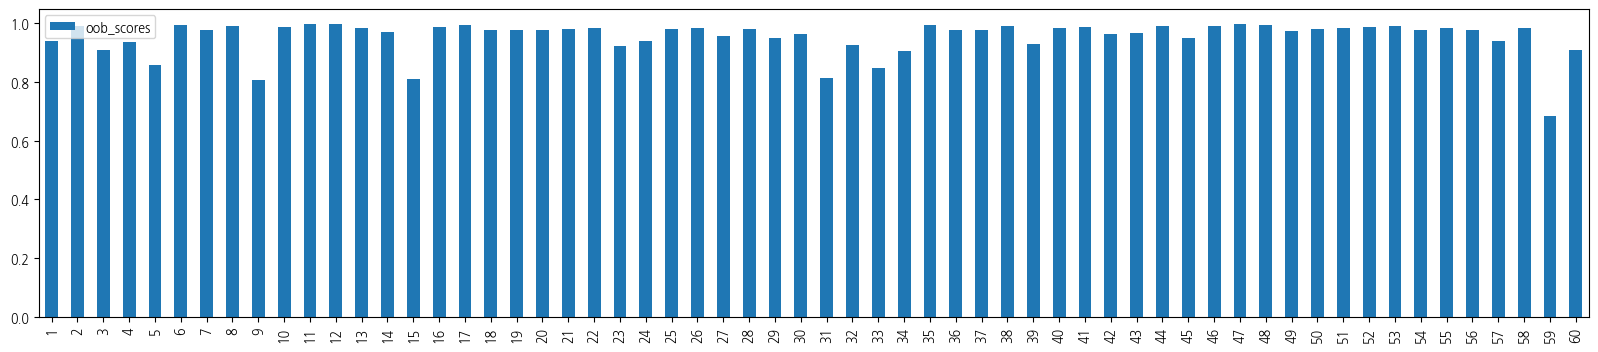

index  oob_scores
0      59        0.68
1       9        0.81
2      15        0.81
3      31        0.81
4      33        0.85
5       5        0.86
6      34        0.90
7      60        0.91
8       3        0.91
9      23        0.92
10     32        0.92
11     39        0.93

In [ ]:
# 건물별 oob_score 플롯팅
pd.DataFrame(data=oob_scores, index=list(range(1, 61)), columns=['oob_scores']).plot(kind='bar', figsize=(20, 4))
plt.show()

oob_df = pd.DataFrame(data=oob_scores, index=list(range(1, 61)), columns=['oob_scores']).reset_index()
oob_df.sort_values(by=['oob_scores']).reset_index(drop=True)[:12]

In [ ]:
train_df_cl

num           date_time   power  temp  wind   hum  prec  sun  \
0         1 2020-06-01 00:00:00 8179.06 17.60  2.50 92.00  0.80 0.00   
1         1 2020-06-01 01:00:00 8135.64 17.70  2.90 91.00  0.30 0.00   
2         1 2020-06-01 02:00:00 8107.13 17.50  3.20 91.00  0.00 0.00   
3         1 2020-06-01 03:00:00 8048.81 17.10  3.20 91.00  0.00 0.00   
4         1 2020-06-01 04:00:00 8043.62 17.00  3.30 92.00  0.00 0.00   
...     ...                 ...     ...   ...   ...   ...   ...  ...   
122395   60 2020-08-24 19:00:00 4114.37 27.80  2.30 68.00  0.00 0.70   
122396   60 2020-08-24 20:00:00 3975.70 27.30  1.20 71.00  0.00 0.00   
122397   60 2020-08-24 21:00:00 3572.21 27.30  1.80 71.00  0.00 0.00   
122398   60 2020-08-24 22:00:00 3299.18 27.10  1.80 74.00  0.00 0.00   
122399   60 2020-08-24 23:00:00 3204.58 27.10  2.60 75.00  0.00 0.00   

        non_elec  solar  month  day  hour  weekday  dayofyear  weekend  \
0           0.00   0.00      6    1     0        0        153     0.00   
1           0.00   0.00      6    1     1        0        153     0.00   
2           0.00   0.00      6    1     2        0        153     0.00   
3           0.00   0.00      6    1     3        0        153     0.00   
4           0.00   0.00      6    1     4        0        153     0.00   
...          ...    ...    ...  ...   ...      ...        ...      ...   
122395      1.00   1.00      8   24    19        0        237     0.00   
122396      1.00   1.00      8   24    20        0        237     0.00   
122397      1.00   1.00      8   24    21        0        237     0.00   
122398      1.00   1.00      8   24    22        0        237     0.00   
122399      1.00   1.00      8   24    23        0        237     0.00   

        cluster  
0             3  
1             3  
2             3  
3             3  
4             3  
...         ...  
122395        2  
122396        2  
122397        2  
122398        2  
122399        2  

[122400 rows x 17 columns]

In [ ]:
X = pd.concat([train_df_origin, train_df_cl['cluster']], axis=1)
# y = pd.concat([test_df, test_df_cl['cluster']], axis=1)
y = test_df.copy()
X

num           date_time   power  temp  wind   hum  prec  sun  \
0         1 2020-06-01 00:00:00 8179.06 17.60  2.50 92.00  0.80 0.00   
1         1 2020-06-01 01:00:00 8135.64 17.70  2.90 91.00  0.30 0.00   
2         1 2020-06-01 02:00:00 8107.13 17.50  3.20 91.00  0.00 0.00   
3         1 2020-06-01 03:00:00 8048.81 17.10  3.20 91.00  0.00 0.00   
4         1 2020-06-01 04:00:00 8043.62 17.00  3.30 92.00  0.00 0.00   
...     ...                 ...     ...   ...   ...   ...   ...  ...   
122395   60 2020-08-24 19:00:00 4114.37 27.80  2.30 68.00  0.00 0.70   
122396   60 2020-08-24 20:00:00 3975.70 27.30  1.20 71.00  0.00 0.00   
122397   60 2020-08-24 21:00:00 3572.21 27.30  1.80 71.00  0.00 0.00   
122398   60 2020-08-24 22:00:00 3299.18 27.10  1.80 74.00  0.00 0.00   
122399   60 2020-08-24 23:00:00 3204.58 27.10  2.60 75.00  0.00 0.00   

        non_elec  solar  month  day  hour  weekday  dayofyear  weekend  \
0           0.00   0.00      6    1     0        0        153     0.00   
1           0.00   0.00      6    1     1        0        153     0.00   
2           0.00   0.00      6    1     2        0        153     0.00   
3           0.00   0.00      6    1     3        0        153     0.00   
4           0.00   0.00      6    1     4        0        153     0.00   
...          ...    ...    ...  ...   ...      ...        ...      ...   
122395      1.00   1.00      8   24    19        0        237     0.00   
122396      1.00   1.00      8   24    20        0        237     0.00   
122397      1.00   1.00      8   24    21        0        237     0.00   
122398      1.00   1.00      8   24    22        0        237     0.00   
122399      1.00   1.00      8   24    23        0        237     0.00   

        cluster  
0             3  
1             3  
2             3  
3             3  
4             3  
...         ...  
122395        2  
122396        2  
122397        2  
122398        2  
122399        2  

[122400 rows x 17 columns]

In [ ]:
# 'cluster' 별로 'num' 값의 개수를 구하는 코드
num_counts = train_df_cl.groupby('cluster')['num'].size().reset_index(name='count')

print(num_counts)

   cluster  count
0        0   8160
1        1  67320
2        2  30600
3        3  16320


In [ ]:
train_df_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   num        122400 non-null  int64         
 1   date_time  122400 non-null  datetime64[ns]
 2   power      122400 non-null  float64       
 3   temp       122400 non-null  float64       
 4   wind       122400 non-null  float64       
 5   hum        122400 non-null  float64       
 6   prec       122400 non-null  float64       
 7   sun        122400 non-null  float64       
 8   non_elec   122400 non-null  float64       
 9   solar      122400 non-null  float64       
 10  month      122400 non-null  int32         
 11  day        122400 non-null  int32         
 12  hour       122400 non-null  int32         
 13  weekday    122400 non-null  int32         
 14  dayofyear  122400 non-null  int32         
 15  weekend    122400 non-null  float64       
 16  cluster    122400 no

In [ ]:
others = [3, 5, 9, 15]
for other, km_num in zip(others, range(4, len(others) + 4)):
    X.loc[X.num == other, 'cluster'] = km_num
    y.loc[y.num == other, 'cluster'] = km_num

train_df_cl_0 = X.loc[X.cluster == 0,
                          ~X.columns.isin(['power', 'cluster', 'date_time'])].reset_index(drop=True)
train_df_cl_1 = X.loc[X.cluster == 1,
                          ~X.columns.isin(['power', 'cluster', 'date_time'])].reset_index(drop=True)
train_df_cl_2 = X.loc[X.cluster == 2,
                          ~X.columns.isin(['power', 'cluster', 'date_time'])].reset_index(drop=True)
train_df_cl_3 = X.loc[X.cluster == 3,
                          ~X.columns.isin(['power', 'cluster', 'date_time'])].reset_index(drop=True)

train_df_cl_1

num  temp  wind   hum  prec  sun  non_elec  solar  month  day  hour  \
0        2 18.30  2.50 94.00  0.00 0.00      1.00   0.00      6    1     0   
1        2 18.80  2.30 89.00  0.00 0.00      1.00   0.00      6    1     1   
2        2 19.00  3.20 86.00  0.00 0.00      1.00   0.00      6    1     2   
3        2 19.00  4.10 85.00  0.00 0.00      1.00   0.00      6    1     3   
4        2 18.90  3.90 87.00  0.00 0.00      1.00   0.00      6    1     4   
...    ...   ...   ...   ...   ...  ...       ...    ...    ...  ...   ...   
67315   57 29.60  2.80 79.00  0.00 0.60      1.00   0.00      8   24    19   
67316   57 28.80  3.40 86.00  0.00 0.00      1.00   0.00      8   24    20   
67317   57 27.90  1.00 90.00  0.00 0.00      1.00   0.00      8   24    21   
67318   57 27.80  1.70 89.00  0.00 0.00      1.00   0.00      8   24    22   
67319   57 27.20  2.20 92.00  0.00 0.00      1.00   0.00      8   24    23   

       weekday  dayofyear  weekend  
0            0        153     0.00  
1            0        153     0.00  
2            0        153     0.00  
3            0        153     0.00  
4            0        153     0.00  
...        ...        ...      ...  
67315        0        237     0.00  
67316        0        237     0.00  
67317        0        237     0.00  
67318        0        237     0.00  
67319        0        237     0.00  

[67320 rows x 14 columns]

In [ ]:
y

num  temp  wind   hum  prec  sun  non_elec  solar  month  day  hour  \
0        1 27.80  1.50 74.00  0.00 0.00      0.00   0.00      8   25     0   
1        1 27.63  1.37 75.33  0.00 0.00      0.00   0.00      8   25     1   
2        1 27.47  1.23 76.67  0.00 0.00      0.00   0.00      8   25     2   
3        1 27.30  1.10 78.00  0.00 0.00      0.00   0.00      8   25     3   
4        1 26.90  1.17 79.67  0.00 0.00      0.00   0.00      8   25     4   
...    ...   ...   ...   ...   ...  ...       ...    ...    ...  ...   ...   
10075   60 28.63  3.57 66.00  0.00 0.18      1.00   1.00      8   31    19   
10076   60 28.27  3.83 67.00  0.00 0.09      1.00   1.00      8   31    20   
10077   60 27.90  4.10 68.00  0.00 0.00      1.00   1.00      8   31    21   
10078   60 27.90  4.10 68.00  0.00 0.00      1.00   1.00      8   31    22   
10079   60 27.90  4.10 68.00  0.00 0.00      1.00   1.00      8   31    23   

       weekday  dayofyear  weekend  cluster  
0            1        238    False        3  
1            1        238    False        3  
2            1        238    False        3  
3            1        238    False        3  
4            1        238    False        3  
...        ...        ...      ...      ...  
10075        0        244    False        2  
10076        0        244    False        2  
10077        0        244    False        2  
10078        0        244    False        2  
10079        0        244    False        2  

[10080 rows x 15 columns]

In [ ]:
# 별도 모델링
# 건물별로 모델링을 할 때는 단일 값인 non_elec, solar, num을 제거합니다.
for i in range(4, len(others) + 4):
    globals()['train_df_cl_{}'.format(i)] = X.loc[X.cluster == i,
                                               ~X.columns.isin(['power', 'cluster', 'date_time', 'non_elec', 'solar', 'num'])].reset_index(drop=True)

train_df_cl_0_y = X.loc[X.cluster == 0, 'power'].reset_index(drop=True)
train_df_cl_1_y = X.loc[X.cluster == 1, 'power'].reset_index(drop=True)
train_df_cl_2_y = X.loc[X.cluster == 2, 'power'].reset_index(drop=True)
train_df_cl_3_y = X.loc[X.cluster == 3, 'power'].reset_index(drop=True)

# 별도 모델링
for i in range(4, len(others) + 4):
    globals()['train_df_cl_{}_y'.format(i)] = X.loc[X.cluster == i, 'power'].reset_index(drop=True)

test_df_cl_0 = y.loc[y.cluster == 0, ~y.columns.isin(['cluster', 'date_time'])]
test_df_cl_1 = y.loc[y.cluster == 1, ~y.columns.isin(['cluster', 'date_time'])]
test_df_cl_2 = y.loc[y.cluster == 2, ~y.columns.isin(['cluster', 'date_time'])]
test_df_cl_3 = y.loc[y.cluster == 3, ~y.columns.isin(['cluster', 'date_time'])]

# 별도 모델링
# 건물별로 모델링을 할 때는 단일 값인 non_elec, solar, num을 제거합니다.
for i in range(4, len(others) + 4):
    globals()['test_df_cl_{}'.format(i)] = y.loc[y.cluster == i, ~y.columns.isin(['cluster', 'date_time', 'non_elec', 'solar', 'num'])]

train_df_x_sets = [train_df_cl_1, train_df_cl_2, train_df_cl_3,
               train_df_cl_4, train_df_cl_5, train_df_cl_6, train_df_cl_7]
train_df_y_sets = [train_df_cl_1_y, train_df_cl_2_y, train_df_cl_3_y,
               train_df_cl_4_y, train_df_cl_5_y, train_df_cl_6_y, train_df_cl_7_y]
test_df_x_sets = [test_df_cl_1, test_df_cl_2, test_df_cl_3,
              test_df_cl_4, test_df_cl_5, test_df_cl_6, test_df_cl_7]

In [ ]:
for x, y, t in zip(train_df_x_sets, train_df_y_sets, test_df_x_sets):
    print(x.shape, y.shape, t.shape)

(67320, 14) (67320,) (5544, 14)
(30600, 14) (30600,) (2520, 14)
(16320, 14) (16320,) (1344, 14)
(2040, 11) (2040,) (168, 11)
(2040, 11) (2040,) (168, 11)
(2040, 11) (2040,) (168, 11)
(2040, 11) (2040,) (168, 11)


In [ ]:
preds = []
fe = []
#oob = []
for x, y, t in zip(train_df_x_sets, train_df_y_sets, test_df_x_sets):
    rf = RandomForestRegressor(random_state=42,
                               #oob_score=True,
                               n_estimators=200,
                               n_jobs = -1)
    rf.fit(x, y)
    pred = rf.predict(t)
    preds.append(pred)
    fe.append(rf.feature_importances_)
    #oob.append(rf.oob_score_)

In [ ]:
fe

[array([5.88586638e-01, 8.11201856e-03, 6.03770631e-04, 1.10985341e-03,
        1.70224968e-04, 2.64275205e-04, 3.07341536e-02, 1.71944886e-01,
        5.42667425e-04, 1.26848032e-03, 1.30025138e-01, 2.75921636e-03,
        7.61765280e-03, 5.62610240e-02]),
 array([4.39936510e-01, 1.29106293e-02, 1.14001881e-03, 1.11029820e-03,
        2.42430351e-04, 2.40529151e-04, 1.44870200e-01, 1.69764433e-01,
        7.86198822e-04, 2.58893285e-03, 1.93831833e-01, 4.54055096e-03,
        2.58463879e-02, 2.19104766e-03]),
 array([9.80322439e-01, 8.91077944e-04, 1.35533997e-04, 2.56151665e-04,
        5.83576903e-05, 4.80398289e-05, 9.94953920e-04, 9.70388652e-04,
        6.00032845e-04, 2.14923446e-04, 1.13787509e-02, 3.73442084e-04,
        3.59362853e-03, 1.62279071e-04]),
 array([0.03229595, 0.01541674, 0.01418514, 0.00520212, 0.00548217,
        0.0009751 , 0.01938257, 0.32866588, 0.04892112, 0.50446744,
        0.02500578]),
 array([0.09196576, 0.04120054, 0.04122889, 0.01392987, 0.00944617,


In [ ]:
pred_set = []
for te, p in zip(test_df_x_sets, preds):
    te['pred'] = p
    pred_set.append(te)

pred_set = pd.concat(pred_set).sort_index()

submission.answer = pred_set.pred

submission

num_date_time  answer
0       1 2020-08-25 00 8676.26
1       1 2020-08-25 01 8670.66
2       1 2020-08-25 02 8666.59
3       1 2020-08-25 03 8660.96
4       1 2020-08-25 04 8651.82
...                 ...     ...
10075  60 2020-08-31 19 4168.80
10076  60 2020-08-31 20 3754.50
10077  60 2020-08-31 21 3662.57
10078  60 2020-08-31 22 3540.95
10079  60 2020-08-31 23 3361.73

[10080 rows x 2 columns]

In [ ]:
# 파일 저장
# submission.to_csv('submission.csv', index=False)

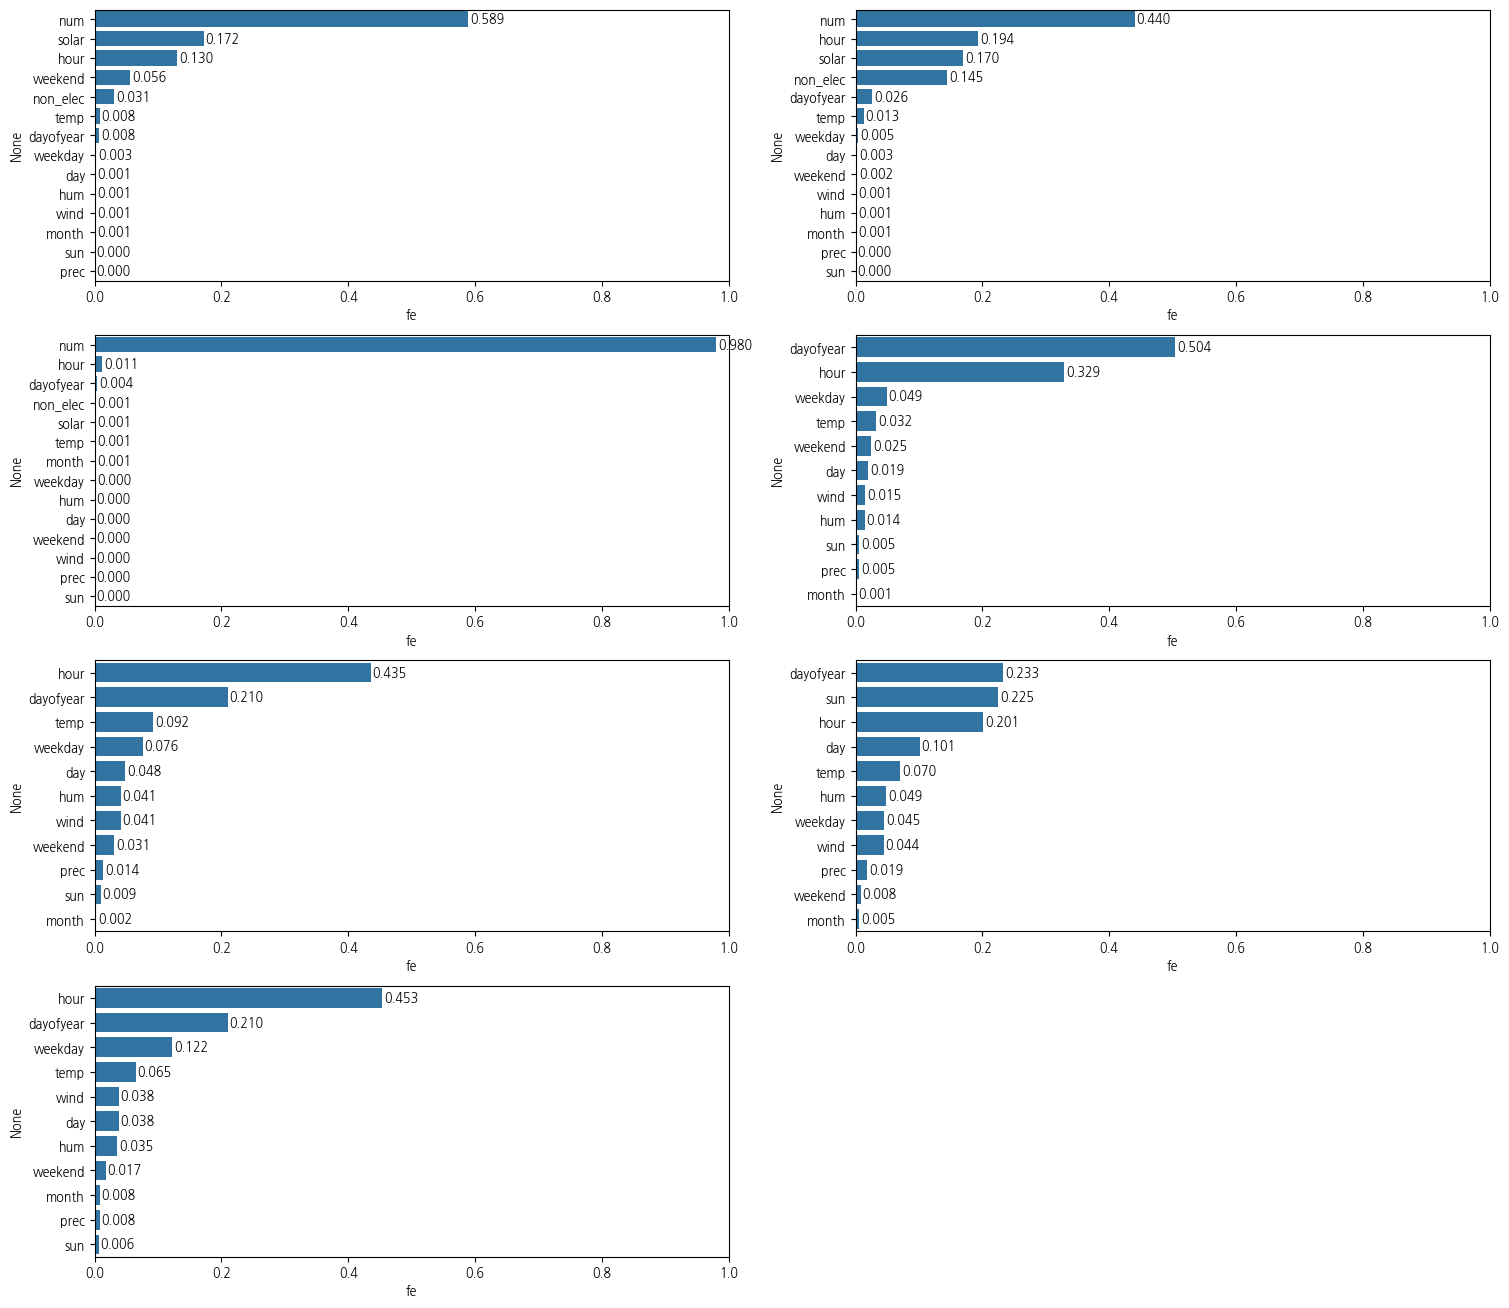

In [ ]:
import pandas as pd
import seaborn as sns

fig = plt.figure(figsize=(18, 50))
for i, n in enumerate(range(len(X.cluster.unique()))):
    plt.subplot(12, 2, i+1)
    if len(fe[i]) == 14:
        fe_avg = pd.DataFrame(fe[i], index=train_df_cl_0.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)
    else:
        fe_avg = pd.DataFrame(fe[i], index=train_df_cl_5.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

    plt.xlim(right=1)
    plots = sns.barplot(data=fe_avg, x='fe', y=fe_avg.index)

    # Annotate every single Bar with its value, based on it's width
    for bar in plots.patches:
        width = bar.get_width()
        plt.text(0.03 + bar.get_width(),
                 bar.get_y() + 0.5 * bar.get_height(),
                 '{:.3f}'.format(width),
                 ha='center', va='center')


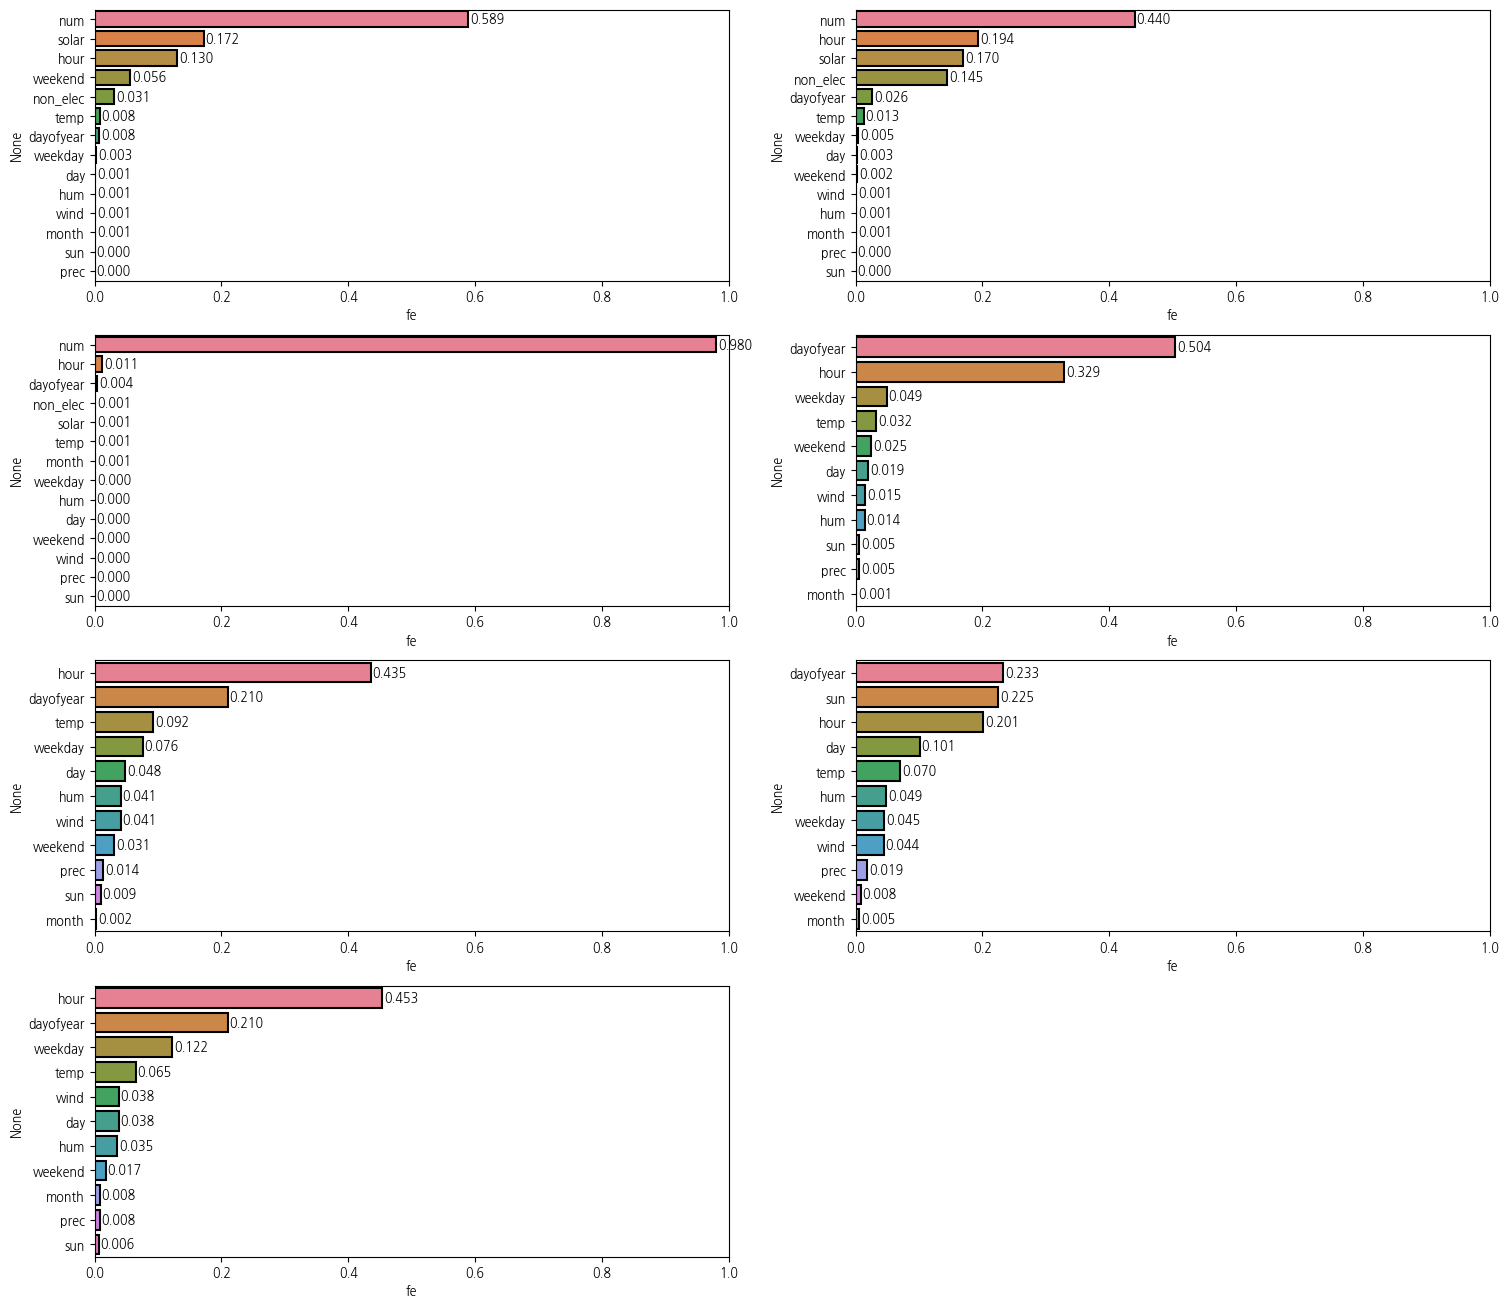

In [ ]:
import pandas as pd
import seaborn as sns

fig = plt.figure(figsize=(18, 50))
for i, n in enumerate(range(len(X.cluster.unique()))):
    plt.subplot(12, 2, i+1)
    if len(fe[i]) == 14:
        fe_avg = pd.DataFrame(fe[i], index=train_df_cl_0.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)
    else:
        fe_avg = pd.DataFrame(fe[i], index=train_df_cl_5.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

    plt.xlim(right=1)
    plots = sns.barplot(data=fe_avg, x='fe', y=fe_avg.index, palette='husl', edgecolor='black', linewidth=1.5)

    # Annotate every single Bar with its value, based on it's width
    for bar in plots.patches:
        width = bar.get_width()
        plt.text(0.03 + bar.get_width(),
                 bar.get_y() + 0.5 * bar.get_height(),
                 '{:.3f}'.format(width),
                 ha='center', va='center')


In [ ]:
import numpy as np

def calculate_smape(true, pred):
    """
    Calculate SMAPE (Symmetric Mean Absolute Percentage Error) between true and predicted values.
    """
    true = np.array(true)
    pred = np.array(pred)
    return 100/len(true) * np.sum(2 * np.abs(pred - true) / (np.abs(true) + np.abs(pred)))

# 각 군집별로 SMAPE 값을 계산하고 출력
for i, cluster_index in enumerate(range(len(X.cluster.unique()))):
    true_values = train_df_y_sets[i]
    pred_values = preds[i]
    smape_cluster = calculate_smape(true_values, pred_values)
    print(f'Cluster {cluster_index+1} SMAPE: {smape_cluster:.3f}')


ValueError: operands could not be broadcast together with shapes (5544,) (67320,) 

### 건물별 예측모델

#### 클러스터 0 - catboost

In [ ]:
### Cluster0 모델
## cluster_0_buildings = [3, 5, 9, 15]

#pip install scikit-learn catboost


import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# 파일 경로
train_file_path = '/content/drive/MyDrive/lsda02/data/electricity_data/train.csv'
test_file_path = '/content/drive/MyDrive/lsda02/data/test_filled.csv'

# 데이터 로드
train_df = pd.read_csv(train_file_path, encoding='cp949')

# 컬럼명 변경
cols = ['num', 'date_time', 'power', 'temp', 'wind', 'hum', 'prec', 'sun', 'non_elec', 'solar']
train_df.columns = cols

# 파생변수 생성
train_df['date_time'] = pd.to_datetime(train_df['date_time'])
train_df['month'] = train_df['date_time'].dt.month
train_df['day'] = train_df['date_time'].dt.day
train_df['hour'] = train_df['date_time'].dt.hour
train_df['weekday'] = train_df['date_time'].dt.weekday
train_df['weekend'] = train_df['weekday'].isin([5, 6]).astype(int)

# 사용하고자 하는 변수만 선택
train_df = train_df[['num', 'date_time', 'power', 'temp', 'wind', 'hum', 'sun', 'hour', 'weekday', 'weekend']]

# 데이터 전처리 함수
def preprocess_data(df):
    df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')
    df = df.dropna(subset=['date_time'])
    df = df.drop_duplicates()
    df.set_index('date_time', inplace=True)
    df['power'] = df['power'].interpolate(method='linear')
    df = df[~df.index.duplicated(keep='first')]
    return df

# SMAPE 함수 정의
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

# Cluster 0의 데이터 선택
building_num = [3]
building = train_df[train_df['num'].isin(building_num)]
building = preprocess_data(building)

# 래그 피처 생성 함수
def create_lag_features(df, lag=48):
    for i in range(1, lag+1):
        df[f'lag_{i}'] = df['power'].shift(i)
    df = df.dropna()
    return df

# 래그 피처 생성
building = create_lag_features(building)

# 학습 데이터 준비
X = building.drop(['power', 'num'], axis=1)
y = building['power']

# 훈련 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 모델 훈련
model = CatBoostRegressor(verbose=0)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
smape_value = smape(y_test, y_pred)
print(f'SMAPE(Cluster0): {smape_value:.2f}%(', smape_value, ')')

# 예측 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()



In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
from catboost import CatBoostRegressor
import numpy as np

# SMAPE 함수 정의
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

# 데이터 전처리 및 래그 피처 생성 함수
def preprocess_and_create_lag_features(df, lag=48):
    df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')
    df = df.dropna(subset=['date_time'])
    df = df.drop_duplicates()
    df.set_index('date_time', inplace=True)
    df['power'] = df['power'].interpolate(method='linear')
    df = df[~df.index.duplicated(keep='first')]
    for i in range(1, lag+1):
        df[f'lag_{i}'] = df['power'].shift(i)
    df = df.dropna()
    return df

# Cluster 0의 데이터 선택 및 전처리
building_num = [3]
building = train_df[train_df['num'].isin(building_num)]
building = preprocess_and_create_lag_features(building)

# 학습 데이터 준비
X = building.drop(['power', 'num'], axis=1)
y = building['power']

# K-겹 교차검증 설정 (TimeSeriesSplit을 사용하여 시간 순서를 유지)
tscv = TimeSeriesSplit(n_splits=5)

# 교차검증 수행
smape_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = CatBoostRegressor(verbose=0)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    smape_score = smape(y_test, y_pred)
    smape_scores.append(smape_score)
    print(f'SMAPE: {smape_score:.2f}%')

# 교차검증 결과 출력
print(f'Mean SMAPE: {np.mean(smape_scores):.2f}%')
print(f'Standard Deviation of SMAPE: {np.std(smape_scores):.2f}%')


In [ ]:
import pandas as pd

# 새로운 테스트 데이터 로드
test = test_df

# 파생변수 생성
test['date_time'] = pd.to_datetime(test['date_time'])
test['weekend'] = test['weekday'].isin([5, 6]).astype(int)

In [ ]:
import pandas as pd

# 사용하고자 하는 변수만 선택
test_data = test[['num', 'date_time', 'temp', 'wind', 'hum', 'sun', 'hour', 'weekday', 'weekend']]

# Cluster 0의 데이터 선택
building_num = [3]
test_data = test_data[test_data['num'].isin(building_num)]

# 데이터 전처리 함수
def preprocess_data(df):
    # date_time 열을 datetime 형식으로 변환
    #df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')


    # 인덱스 설정
    df.set_index('date_time', inplace=True)

    # 중복된 행 제거
    #df = df[~df.index.duplicated(keep='first')]

    return df

# lag 특성 생성 함수
def create_lag_features(df, lag=48):
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['temp'].shift(i)
    #df = df.dropna()  # 첫 lag 행은 결측치가 발생하므로 제거
    return df

# 데이터 전처리
test_data = preprocess_data(test_data)

# lag 특성 추가
test_data = create_lag_features(test_data)

# 예측에 사용할 데이터 준비 (훈련 데이터와 동일한 변수를 가진 데이터)
X_test = test_data.drop(columns=['num'])  # 'num' 열 제외

# 모델에 입력하여 예측
predicted_power = model.predict(X_test)

# 예측 결과 출력
print(predicted_power)

# 예측 결과를 새로운 열로 추가
test_data['predicted_power'] = predicted_power



# 예측 결과와 함께 데이터프레임 출력
print(test_data[['temp', 'wind', 'hum', 'sun', 'hour', 'weekday', 'weekend', 'predicted_power']])


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# CatBoostRegressor 초기화
model = CatBoostRegressor(verbose=0)

# 하이퍼파라미터 그리드 설정
param_dist = {
    'iterations': [100, 200],
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0.2, 0.5, 0.7]
}

# mean_absolute_error를 사용한 사용자 정의 스코어 함수
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# RandomizedSearchCV 초기화
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, scoring=scorer, cv=3, n_iter=20, n_jobs=-1, random_state=42)

# 모델 학습
random_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", random_search.best_params_)
print("Best CV Score:", -random_search.best_score_)


In [ ]:
import pandas as pd
from catboost import CatBoostRegressor

# 최적의 하이퍼파라미터
best_params = {
    'learning_rate': 0.05,
    'l2_leaf_reg': 5,
    'iterations': 200,
    'depth': 6,
    'bagging_temperature': 0.2
}

# 최적의 하이퍼파라미터를 사용하여 모델 초기화
best_model = CatBoostRegressor(**best_params, random_seed=42)

# 모델 학습
best_model.fit(X_train, y_train)

# 테스트 데이터에 대해 예측
predicted_power = best_model.predict(X_test)

# 예측 결과 출력
print(predicted_power)


In [ ]:
import matplotlib.pyplot as plt

# 예측 결과를 시각화
plt.figure(figsize=(15, 5))
plt.plot(test_data.index, predicted_power, label='Predicted Power', color='blue')
plt.title('Building 3 Predicted Power Usage')
plt.xlabel('Date')
plt.ylabel('Power Usage')
plt.legend()
plt.show()


In [ ]:
# 병합된 데이터프레임을 CSV 파일로 저장 (원하는 파일명으로 저장)
test_03.to_csv('test_03.csv', index=False, encoding='cp949')

In [ ]:
### Cluster0 모델
## cluster_0_buildings = [3, 5, 9, 15]

#pip install scikit-learn catboost


import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# 파일 경로
train_file_path = '/content/drive/MyDrive/lsda02/data/electricity_data/train.csv'
test_file_path = '/content/drive/MyDrive/lsda02/data/test_filled.csv'

# 데이터 로드
train_df = pd.read_csv(train_file_path, encoding='cp949')

# 컬럼명 변경
cols = ['num', 'date_time', 'power', 'temp', 'wind', 'hum', 'prec', 'sun', 'non_elec', 'solar']
train_df.columns = cols

# 파생변수 생성
train_df['date_time'] = pd.to_datetime(train_df['date_time'])
train_df['month'] = train_df['date_time'].dt.month
train_df['day'] = train_df['date_time'].dt.day
train_df['hour'] = train_df['date_time'].dt.hour
train_df['weekday'] = train_df['date_time'].dt.weekday
train_df['weekend'] = train_df['weekday'].isin([5, 6]).astype(int)

# 사용하고자 하는 변수만 선택
train_df = train_df[['num', 'date_time', 'power', 'temp', 'wind', 'hum', 'sun', 'hour', 'weekday', 'weekend']]

# 데이터 전처리 함수
def preprocess_data(df):
    df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')
    df = df.dropna(subset=['date_time'])
    df.set_index('date_time', inplace=True)
    df['power'] = df['power'].interpolate(method='linear')
    df = df[~df.index.duplicated(keep='first')]
    return df

# SMAPE 함수 정의
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

# Cluster 0의 데이터 선택
building_num = [5]
building = train_df[train_df['num'].isin(building_num)]
building = preprocess_data(building)

# 래그 피처 생성 함수
def create_lag_features(df, lag=48):
    for i in range(1, lag+1):
        df[f'lag_{i}'] = df['power'].shift(i)
    #df = df.dropna()
    return df

# 래그 피처 생성
building = create_lag_features(building)

# 학습 데이터 준비
X = building.drop(['power', 'num'], axis=1)
y = building['power']

# 훈련 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 모델 훈련
model = CatBoostRegressor(verbose=0)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
smape_value = smape(y_test, y_pred)
print(f'SMAPE(Cluster0): {smape_value:.2f}%(', smape_value, ')')

# 예측 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()



In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
from catboost import CatBoostRegressor
import numpy as np

# SMAPE 함수 정의
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

# 데이터 전처리 및 래그 피처 생성 함수
def preprocess_and_create_lag_features(df, lag=48):
    df.set_index('date_time', inplace=True)
    df['power'] = df['power'].interpolate(method='linear')
    df = df[~df.index.duplicated(keep='first')]
    for i in range(1, lag+1):
        df[f'lag_{i}'] = df['power'].shift(i)
    #df = df.dropna()
    return df

# Cluster 0의 데이터 선택 및 전처리
building_num = [5]
building = train_df[train_df['num'].isin(building_num)]
building = preprocess_and_create_lag_features(building)

# 학습 데이터 준비
X = building.drop(['power', 'num'], axis=1)
y = building['power']

# K-겹 교차검증 설정 (TimeSeriesSplit을 사용하여 시간 순서를 유지)
tscv = TimeSeriesSplit(n_splits=5)

# 교차검증 수행
smape_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = CatBoostRegressor(verbose=0)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    smape_score = smape(y_test, y_pred)
    smape_scores.append(smape_score)
    print(f'SMAPE: {smape_score:.2f}%')

# 교차검증 결과 출력
print(f'Mean SMAPE: {np.mean(smape_scores):.2f}%')
print(f'Standard Deviation of SMAPE: {np.std(smape_scores):.2f}%')


In [ ]:
import pandas as pd

# 사용하고자 하는 변수만 선택
test_data = test[['num', 'date_time', 'temp', 'wind', 'hum', 'sun', 'hour', 'weekday', 'weekend']]

# Cluster 0의 데이터 선택
building_num = [5]
test_data = test_data[test_data['num'].isin(building_num)]

# 데이터 전처리 함수
def preprocess_data(df):
    # date_time 열을 datetime 형식으로 변환
    df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')

    # 결측치 처리
    # df = df.dropna(subset=['date_time'])
    # df = df.drop_duplicates()

    # 인덱스 설정
    df.set_index('date_time', inplace=True)

    # 중복된 행 제거
    df = df[~df.index.duplicated(keep='first')]

    return df

# lag 특성 생성 함수
def create_lag_features(df, lag=48):
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['temp'].shift(i)
    return df

# 데이터 전처리
test_data = preprocess_data(test_data)

# lag 특성 추가
test_data = create_lag_features(test_data)

# 예측에 사용할 데이터 준비 (훈련 데이터와 동일한 변수를 가진 데이터)
X_test = test_data.drop(columns=['num'])  # 'num' 열 제외

# 모델에 입력하여 예측
predicted_power = model.predict(X_test)

# 예측 결과 출력
print(predicted_power)

# 예측 결과를 새로운 열로 추가
test_data['predicted_power'] = predicted_power



# 예측 결과와 함께 데이터프레임 출력
print(test_data[['temp', 'wind', 'hum', 'sun', 'hour', 'weekday', 'weekend', 'predicted_power']])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# CatBoostRegressor 초기화
model = CatBoostRegressor(verbose=0)

# 하이퍼파라미터 그리드 설정
param_dist = {
    'iterations': [100, 200],
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0.2, 0.5, 0.7]
}

# mean_absolute_error를 사용한 사용자 정의 스코어 함수
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# RandomizedSearchCV 초기화
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, scoring=scorer, cv=3, n_iter=20, n_jobs=-1, random_state=42)

# 모델 학습
random_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", random_search.best_params_)
print("Best CV Score:", -random_search.best_score_)


In [ ]:
import pandas as pd
from catboost import CatBoostRegressor

# 최적의 하이퍼파라미터
best_params = {
    'learning_rate': 0.05,
    'l2_leaf_reg': 5,
    'iterations': 200,
    'depth': 6,
    'bagging_temperature': 0.2
}

# 최적의 하이퍼파라미터를 사용하여 모델 초기화
best_model = CatBoostRegressor(**best_params, random_seed=42)

# 모델 학습
best_model.fit(X_train, y_train)

# 테스트 데이터에 대해 예측
predicted_power = best_model.predict(X_test)

# 예측 결과 출력
print(predicted_power)

In [ ]:
import matplotlib.pyplot as plt

# 예측 결과를 시각화
plt.figure(figsize=(15, 5))
plt.plot(test_data.index, predicted_power, label='Predicted Power', color='blue')
plt.title('Building 5 Predicted Power Usage')
plt.xlabel('Date')
plt.ylabel('Power Usage')
plt.legend()
plt.show()

In [ ]:
### Cluster0 모델
## cluster_0_buildings = [3, 5, 9, 15]

#pip install scikit-learn catboost


import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# 파일 경로
train_file_path = '/content/drive/MyDrive/lsda02/data/electricity_data/train.csv'
test_file_path = '/content/drive/MyDrive/lsda02/data/test_filled.csv'

# 데이터 로드
train_df = pd.read_csv(train_file_path, encoding='cp949')

# 컬럼명 변경
cols = ['num', 'date_time', 'power', 'temp', 'wind', 'hum', 'prec', 'sun', 'non_elec', 'solar']
train_df.columns = cols

# 파생변수 생성
train_df['date_time'] = pd.to_datetime(train_df['date_time'])
train_df['month'] = train_df['date_time'].dt.month
train_df['day'] = train_df['date_time'].dt.day
train_df['hour'] = train_df['date_time'].dt.hour
train_df['weekday'] = train_df['date_time'].dt.weekday
train_df['weekend'] = train_df['weekday'].isin([5, 6]).astype(int)

# 사용하고자 하는 변수만 선택
train_df = train_df[['num', 'date_time', 'power', 'temp', 'wind', 'hum', 'sun', 'hour', 'weekday', 'weekend']]

# 데이터 전처리 함수
def preprocess_data(df):
    df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')
    df.set_index('date_time', inplace=True)
    df['power'] = df['power'].interpolate(method='linear')
    df = df[~df.index.duplicated(keep='first')]
    return df

# SMAPE 함수 정의
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

# Cluster 0의 데이터 선택
building_num = [9]
building = train_df[train_df['num'].isin(building_num)]
building = preprocess_data(building)

# 래그 피처 생성 함수
def create_lag_features(df, lag=48):
    for i in range(1, lag+1):
        df[f'lag_{i}'] = df['power'].shift(i)
    df = df.dropna()
    return df

# 래그 피처 생성
building = create_lag_features(building)

# 학습 데이터 준비
X = building.drop(['power', 'num'], axis=1)
y = building['power']

# 훈련 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 모델 훈련
model = CatBoostRegressor(verbose=0)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
smape_value = smape(y_test, y_pred)
print(f'SMAPE(Cluster0): {smape_value:.2f}%(', smape_value, ')')

# 예측 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()



In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
from catboost import CatBoostRegressor
import numpy as np

# SMAPE 함수 정의
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

# 데이터 전처리 및 래그 피처 생성 함수
def preprocess_and_create_lag_features(df, lag=48):
    df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')

    df.set_index('date_time', inplace=True)
    df['power'] = df['power'].interpolate(method='linear')
    df = df[~df.index.duplicated(keep='first')]
    for i in range(1, lag+1):
        df[f'lag_{i}'] = df['power'].shift(i)
    return df

# Cluster 0의 데이터 선택 및 전처리
building_num = [9]
building = train_df[train_df['num'].isin(building_num)]
building = preprocess_and_create_lag_features(building)

# 학습 데이터 준비
X = building.drop(['power', 'num'], axis=1)
y = building['power']

# K-겹 교차검증 설정 (TimeSeriesSplit을 사용하여 시간 순서를 유지)
tscv = TimeSeriesSplit(n_splits=5)

# 교차검증 수행
smape_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = CatBoostRegressor(verbose=0)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    smape_score = smape(y_test, y_pred)
    smape_scores.append(smape_score)
    print(f'SMAPE: {smape_score:.2f}%')

# 교차검증 결과 출력
print(f'Mean SMAPE: {np.mean(smape_scores):.2f}%')
print(f'Standard Deviation of SMAPE: {np.std(smape_scores):.2f}%')

In [ ]:
import pandas as pd

# 사용하고자 하는 변수만 선택
test_data = test[['num', 'date_time', 'temp', 'wind', 'hum', 'sun', 'hour', 'weekday', 'weekend']]

# Cluster 0의 데이터 선택
building_num = [9]
test_data = test_data[test_data['num'].isin(building_num)]

# 데이터 전처리 함수
def preprocess_data(df):
    # date_time 열을 datetime 형식으로 변환
    df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')

    # 결측치 처리
    df = df.dropna(subset=['date_time'])
    df = df.drop_duplicates()

    # 인덱스 설정
    df.set_index('date_time', inplace=True)

    # 중복된 행 제거
    df = df[~df.index.duplicated(keep='first')]

    return df

# lag 특성 생성 함수
def create_lag_features(df, lag=48):
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['temp'].shift(i)
    return df

# 데이터 전처리
test_data = preprocess_data(test_data)

# lag 특성 추가
test_data = create_lag_features(test_data)

# 예측에 사용할 데이터 준비 (훈련 데이터와 동일한 변수를 가진 데이터)
X_test = test_data.drop(columns=['num'])  # 'num' 열 제외

# 모델에 입력하여 예측
predicted_power = model.predict(X_test)

# 예측 결과 출력
print(predicted_power)

# 예측 결과를 새로운 열로 추가
test_data['predicted_power'] = predicted_power



# 예측 결과와 함께 데이터프레임 출력
print(test_data[['temp', 'wind', 'hum', 'sun', 'hour', 'weekday', 'weekend', 'predicted_power']])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# CatBoostRegressor 초기화
model = CatBoostRegressor(verbose=0)

# 하이퍼파라미터 그리드 설정
param_dist = {
    'iterations': [100, 200],
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0.2, 0.5, 0.7]
}

# mean_absolute_error를 사용한 사용자 정의 스코어 함수
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# RandomizedSearchCV 초기화
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, scoring=scorer, cv=3, n_iter=20, n_jobs=-1, random_state=42)

# 모델 학습
random_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", random_search.best_params_)
print("Best CV Score:", -random_search.best_score_)


In [ ]:
import pandas as pd
from catboost import CatBoostRegressor

# 최적의 하이퍼파라미터
best_params = {
    'learning_rate': 0.05,
    'l2_leaf_reg': 1,
    'iterations': 100,
    'depth': 6,
    'bagging_temperature': 0.7
}

# 최적의 하이퍼파라미터를 사용하여 모델 초기화
best_model = CatBoostRegressor(**best_params, random_seed=42)

# 모델 학습
best_model.fit(X_train, y_train)

# 테스트 데이터에 대해 예측
predicted_power = best_model.predict(X_test)

# 예측 결과 출력
print(predicted_power)

In [ ]:
import matplotlib.pyplot as plt

# 예측 결과를 시각화
plt.figure(figsize=(15, 5))
plt.plot(test_data.index, predicted_power, label='Predicted Power', color='blue')
plt.title('Building 9 Predicted Power Usage')
plt.xlabel('Date')
plt.ylabel('Power Usage')
plt.legend()
plt.show()

In [ ]:
### Cluster0 모델
## cluster_0_buildings = [3, 5, 9, 15]

#pip install scikit-learn catboost


import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

train = pd.read_csv("C:/Users/USER/Downloads/electricity_data/train.csv", encoding='cp949')
test = pd.read_csv("C:/Users/USER/Downloads/test_filled.csv", encoding='cp949')

train_df = train

# 컬럼명 변경
cols = ['num', 'date_time', 'power', 'temp', 'wind', 'hum', 'prec', 'sun', 'non_elec', 'solar']
train_df.columns = cols

# 파생변수 생성
train_df['date_time'] = pd.to_datetime(train_df['date_time'])
train_df['month'] = train_df['date_time'].dt.month
train_df['day'] = train_df['date_time'].dt.day
train_df['hour'] = train_df['date_time'].dt.hour
train_df['weekday'] = train_df['date_time'].dt.weekday
train_df['weekend'] = train_df['weekday'].isin([5, 6]).astype(int)

# 사용하고자 하는 변수만 선택
train_df = train_df[['num', 'date_time', 'power', 'temp', 'wind', 'hum', 'sun', 'hour', 'weekday', 'weekend']]

# 데이터 전처리 함수
def preprocess_data(df):
    df.set_index('date_time', inplace=True)
    df['power'] = df['power'].interpolate(method='linear')
    df = df[~df.index.duplicated(keep='first')]
    return df

# SMAPE 함수 정의
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

# Cluster 0의 데이터 선택
building_num = [15]
building = train_df[train_df['num'].isin(building_num)]
building = preprocess_data(building)

# 래그 피처 생성 함수
def create_lag_features(df, lag=48):
    for i in range(1, lag+1):
        df[f'lag_{i}'] = df['power'].shift(i)
    df = df.dropna()
    return df

# 래그 피처 생성
building = create_lag_features(building)

# 학습 데이터 준비
X = building.drop(['power', 'num'], axis=1)
y = building['power']

# 훈련 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 모델 훈련
model = CatBoostRegressor(verbose=0)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
smape_value = smape(y_test, y_pred)
print(f'SMAPE(Cluster0): {smape_value:.2f}%(', smape_value, ')')

# 예측 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()



In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
from catboost import CatBoostRegressor
import numpy as np

# SMAPE 함수 정의
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

# 데이터 전처리 및 래그 피처 생성 함수
def preprocess_and_create_lag_features(df, lag=48):
    df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')
    df.set_index('date_time', inplace=True)
    df['power'] = df['power'].interpolate(method='linear')
    df = df[~df.index.duplicated(keep='first')]
    for i in range(1, lag+1):
        df[f'lag_{i}'] = df['power'].shift(i)
    return df

# Cluster 0의 데이터 선택 및 전처리
building_num = [15]
building = train_df[train_df['num'].isin(building_num)]
building = preprocess_and_create_lag_features(building)

# 학습 데이터 준비
X = building.drop(['power', 'num'], axis=1)
y = building['power']

# K-겹 교차검증 설정 (TimeSeriesSplit을 사용하여 시간 순서를 유지)
tscv = TimeSeriesSplit(n_splits=5)

# 교차검증 수행
smape_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = CatBoostRegressor(verbose=0)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    smape_score = smape(y_test, y_pred)
    smape_scores.append(smape_score)
    print(f'SMAPE: {smape_score:.2f}%')

# 교차검증 결과 출력
print(f'Mean SMAPE: {np.mean(smape_scores):.2f}%')
print(f'Standard Deviation of SMAPE: {np.std(smape_scores):.2f}%')

In [ ]:
import pandas as pd

# 파생변수 생성
test['date_time'] = pd.to_datetime(test['date_time'])
test['weekend'] = test['weekday'].isin([5, 6]).astype(int)

# 사용하고자 하는 변수만 선택
test_data = test[['num', 'date_time', 'temp', 'wind', 'hum', 'sun', 'hour', 'weekday', 'weekend']]

# Cluster 0의 데이터 선택
building_num = [15]
test_data = test_data[test_data['num'].isin(building_num)]

# 데이터 전처리 함수
def preprocess_data(df):
    # date_time 열을 datetime 형식으로 변환
    df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')
    
    # 결측치 처리
    # df = df.dropna(subset=['date_time'])
    # df = df.drop_duplicates()
    
    # 인덱스 설정
    df.set_index('date_time', inplace=True)
    
    # 중복된 행 제거
    df = df[~df.index.duplicated(keep='first')]
    
    return df

# lag 특성 생성 함수
def create_lag_features(df, lag=48):
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['temp'].shift(i)
    return df

# 데이터 전처리
test_data = preprocess_data(test_data)

# lag 특성 추가
test_data = create_lag_features(test_data)

# 예측에 사용할 데이터 준비 (훈련 데이터와 동일한 변수를 가진 데이터)
X_test = test_data.drop(columns=['num'])  # 'num' 열 제외

# 모델에 입력하여 예측
predicted_power = model.predict(X_test)

# 예측 결과 출력
print(predicted_power)

# 예측 결과를 새로운 열로 추가
test_data['predicted_power'] = predicted_power



# 예측 결과와 함께 데이터프레임 출력
print(test_data[['temp', 'wind', 'hum', 'sun', 'hour', 'weekday', 'weekend', 'predicted_power']])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# CatBoostRegressor 초기화
model = CatBoostRegressor(verbose=0)

# 하이퍼파라미터 그리드 설정
param_dist = {
    'iterations': [100, 200],
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0.2, 0.5, 0.7]
}

# mean_absolute_error를 사용한 사용자 정의 스코어 함수
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# RandomizedSearchCV 초기화
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, scoring=scorer, cv=3, n_iter=20, n_jobs=-1, random_state=42)

# 모델 학습
random_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", random_search.best_params_)
print("Best CV Score:", -random_search.best_score_)


In [ ]:
import pandas as pd
from catboost import CatBoostRegressor

# 최적의 하이퍼파라미터
best_params = {
    'learning_rate': 0.05,
    'l2_leaf_reg': 5,
    'iterations': 200,
    'depth': 6,
    'bagging_temperature': 0.2
}

# 최적의 하이퍼파라미터를 사용하여 모델 초기화
best_model = CatBoostRegressor(**best_params, random_seed=42)

# 모델 학습
best_model.fit(X_train, y_train)

# 테스트 데이터에 대해 예측
predicted_power = best_model.predict(X_test)

# 예측 결과 출력
print(predicted_power)

In [ ]:
import matplotlib.pyplot as plt

# 예측 결과를 시각화
plt.figure(figsize=(15, 5))
plt.plot(test_data.index, predicted_power, label='Predicted Power', color='blue')
plt.title('Building 15 Predicted Power Usage')
plt.xlabel('Date')
plt.ylabel('Power Usage')
plt.legend()
plt.show()

#### 클러스터 1 - Extra tree

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

train = pd.read_csv("C:/Users/USER/Downloads/electricity_data/train.csv", encoding='cp949')
test = pd.read_csv("C:/Users/USER/Downloads/test_filled.csv", encoding='cp949')

train_df = train

# 컬럼명 변경
cols = ['num', 'date_time', 'power', 'temp', 'wind', 'hum', 'prec', 'sun', 'non_elec', 'solar']
train_df.columns = cols

# 파생변수 생성
train_df['date_time'] = pd.to_datetime(train_df['date_time'])
train_df['month'] = train_df['date_time'].dt.month
train_df['day'] = train_df['date_time'].dt.day
train_df['hour'] = train_df['date_time'].dt.hour
train_df['weekday'] = train_df['date_time'].dt.weekday
train_df['weekend'] = train_df['weekday'].isin([5, 6]).astype(int)

# 사용하고자 하는 변수만 선택
train_df = train_df[['num', 'date_time', 'power', 'temp', 'wind', 'hum', 'hour', 'weekday', 'weekend']]


In [ ]:
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
import numpy as np


cluster1 = [ 2, 6, 7, 8, 13, 14, 16, 17, 18, 22, 23, 24, 25, 26, 27, 31, 33, 35, 37, 39, 43, 44, 45, 46, 47, 48, 52, 53, 54, 55, 56, 57]


# 데이터 전처리 함수
def preprocess_data(df):
    df.set_index('date_time', inplace=True)
    df['power'] = df['power'].interpolate(method='linear')
    df = df[~df.index.duplicated(keep='first')]
    return df

# SMAPE 함수 정의
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

# 데이터 불러오기


# test_final 파일 불러오기
test_final_1 = pd.read_csv("C:/Users/USER/Downloads/test_final_1.csv", encoding='cp949')

# 반복문으로 n을 변화시키며 실행
for n in cluster1:
    # Cluster 1의 데이터 선택
    building_num = [n]
    building = train_df[train_df['num'].isin(building_num)]
    building = preprocess_data(building)

    # 학습 데이터 준비
    X = building.drop(['power', 'num'], axis=1)
    y = building['power']

    # 훈련 데이터와 테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # 모델 훈련
    model = ExtraTreesRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # 예측
    y_pred = model.predict(X_test)

    # 평가
    smape_value = smape(y_test, y_pred)
    print(f'SMAPE building_{n}: {smape_value:.2f}%')

    # 사용자가 제공한 코드 수정

    test['date_time'] = pd.to_datetime(test['date_time'])
    test['weekend'] = test['weekday'].isin([5, 6]).astype(int)
    test_data = test[['num', 'date_time', 'temp', 'wind', 'hum', 'sun', 'hour', 'weekday', 'weekend']]
    building_num = [n]
    test_data = test_data[test_data['num'].isin(building_num)]

    def preprocess_data(df):
        df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')
        df.set_index('date_time', inplace=True)
        df = df[~df.index.duplicated(keep='first')]
        return df
    
    test_data = preprocess_data(test_data)
    X_test = test_data.drop(columns=['num'])
    predicted_power = model.predict(X_test)
    print(predicted_power)
    test_data['predicted_power'] = predicted_power
    test_final_1 = pd.concat([test_final_1, test_data[['num', 'predicted_power']]], ignore_index=True)

# 최종 결과를 CSV 파일로 저장
test_final_1.to_csv('test_final_1.csv', index=False, encoding='cp949')


#### 클러스터 2 - Extra tree

In [ ]:
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
import numpy as np


cluster2 = [4, 10, 11, 12, 28, 29, 30, 32, 36, 38, 40, 41, 42, 58, 59, 60]


# 데이터 전처리 함수
def preprocess_data(df):
    df.set_index('date_time', inplace=True)
    df['power'] = df['power'].interpolate(method='linear')
    df = df[~df.index.duplicated(keep='first')]
    return df

# SMAPE 함수 정의
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

# 데이터 불러오기


# test_final 파일 불러오기
test_final_2 = pd.read_csv("C:/Users/USER/Downloads/test_final_2.csv", encoding='cp949')

# 반복문으로 n을 변화시키며 실행
for n in cluster2:
    # Cluster 2의 데이터 선택
    building_num = [n]
    building = train_df[train_df['num'].isin(building_num)]
    building = preprocess_data(building)

    # 학습 데이터 준비
    X = building.drop(['power', 'num'], axis=1)
    y = building['power']

    # 훈련 데이터와 테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # 모델 훈련
    model = ExtraTreesRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # 예측
    y_pred = model.predict(X_test)

    # 평가
    smape_value = smape(y_test, y_pred)
    print(f'SMAPE building_{n}: {smape_value:.2f}%')

    # 사용자가 제공한 코드 수정

    test['date_time'] = pd.to_datetime(test['date_time'])
    test['weekend'] = test['weekday'].isin([5, 6]).astype(int)
    test_data = test[['num', 'date_time', 'temp', 'wind', 'hum', 'hour', 'weekday', 'weekend']]
    building_num = [n]
    test_data = test_data[test_data['num'].isin(building_num)]

    def preprocess_data(df):
        df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')
        df.set_index('date_time', inplace=True)
        df = df[~df.index.duplicated(keep='first')]
        return df
    
    test_data = preprocess_data(test_data)
    X_test = test_data.drop(columns=['num'])
    predicted_power = model.predict(X_test)
    print(predicted_power)
    test_data['predicted_power'] = predicted_power
    test_final_2 = pd.concat([test_final_2, test_data[['num', 'predicted_power']]], ignore_index=True)

# 최종 결과를 CSV 파일로 저장
test_final_2.to_csv('test_final_2.csv', index=False, encoding='cp949')


#### 클러스터 3 - Lightgbm

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import numpy as np

cluster3 = [1, 19, 20, 21, 34, 49, 50, 51]

# 데이터 전처리 함수
def preprocess_data(df):
    df.set_index('date_time', inplace=True)
    df['power'] = df['power'].interpolate(method='linear')
    df = df[~df.index.duplicated(keep='first')]
    return df

# SMAPE 함수 정의
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

# 데이터 불러오기
test_final_3 = pd.read_csv("C:/Users/USER/Downloads/test_final_3.csv", encoding='cp949')

for n in cluster3:
    # Cluster 3의 데이터 선택
    building_num = [n]
    building = train_df[train_df['num'].isin(building_num)]
    building = preprocess_data(building)

    # 학습 데이터 준비
    X = building.drop(['power', 'num'], axis=1)
    y = building['power']

    # 훈련 데이터와 테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # 모델 훈련
    model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # 예측
    y_pred = model.predict(X_test)

    # 평가
    smape_value = smape(y_test, y_pred)
    print(f'SMAPE building_{n}: {smape_value:.2f}%')

    # 사용자가 제공한 코드 수정
    test['date_time'] = pd.to_datetime(test['date_time'])
    test['weekend'] = test['weekday'].isin([5, 6]).astype(int)
    test_data = test[['num', 'date_time', 'temp', 'wind', 'hum', 'hour', 'weekday', 'weekend']]
    building_num = [n]
    test_data = test_data[test_data['num'].isin(building_num)]

    def preprocess_data(df):
        df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')
        df.set_index('date_time', inplace=True)
        df = df[~df.index.duplicated(keep='first')]
        return df
    
    test_data = preprocess_data(test_data)
    X_test = test_data.drop(columns=['num'])
    predicted_power = model.predict(X_test)
    print(predicted_power)
    test_data['predicted_power'] = predicted_power
    test_final_3 = pd.concat([test_final_3, test_data[['num', 'predicted_power']]], ignore_index=True)

# 최종 결과를 CSV 파일로 저장
test_final_3.to_csv('test_final_3.csv', index=False, encoding='cp949')


## 5. 청주공장

### 61번 데이터_part1

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# vs code 용!
# part1 = pd.read_csv("C:/Users/USER/Downloads/num61/61_part1.csv", encoding='cp949')
# part2 = pd.read_csv("C:/Users/USER/Downloads/num61/61_part2.csv", encoding = 'cp949')
# main = pd.read_csv("C:/Users/USER/Downloads/num61/61_MAIN.csv", encoding = 'cp949')

# 구글 코랩용!
part1 = pd.read_csv('/content/drive/MyDrive/lsda02/data/61_part1.csv',encoding = 'cp949')
part2 = pd.read_csv('/content/drive/MyDrive/lsda02/data/61_part2.csv',encoding = 'cp949')
main = pd.read_csv('/content/drive/MyDrive/lsda02/data/61_MAIN.csv',encoding = 'cp949')

In [ ]:
part1

일시      전력사용량
0                2021-10-20 9334835.00
1     2021-10-20 오전 1:00:00 9337298.00
2     2021-10-20 오전 2:00:00 9339817.00
3     2021-10-20 오전 3:00:00 9342287.00
4     2021-10-20 오전 4:00:00 9344706.00
..                      ...        ...
259   2021-10-30 오후 7:00:00  160361.69
260   2021-10-30 오후 8:00:00  162955.58
261   2021-10-30 오후 9:00:00  165454.84
262  2021-10-30 오후 10:00:00  167997.47
263  2021-10-30 오후 11:00:00  170529.80

[264 rows x 2 columns]

In [ ]:
'''#파생변수 생성
part1['month'] = part1['DateTime'].dt.month
part1['day'] = part1['DateTime'].dt.day
part1['hour'] = part1['DateTime'].dt.hour'''

"#파생변수 생성\npart1['month'] = part1['DateTime'].dt.month\npart1['day'] = part1['DateTime'].dt.day\npart1['hour'] = part1['DateTime'].dt.hour"

In [ ]:
part1

일시      전력사용량
0                2021-10-20 9334835.00
1     2021-10-20 오전 1:00:00 9337298.00
2     2021-10-20 오전 2:00:00 9339817.00
3     2021-10-20 오전 3:00:00 9342287.00
4     2021-10-20 오전 4:00:00 9344706.00
..                      ...        ...
259   2021-10-30 오후 7:00:00  160361.69
260   2021-10-30 오후 8:00:00  162955.58
261   2021-10-30 오후 9:00:00  165454.84
262  2021-10-30 오후 10:00:00  167997.47
263  2021-10-30 오후 11:00:00  170529.80

[264 rows x 2 columns]

In [ ]:
'''# '일시' 열을 datetime 형식으로 변환한 후, 오전 12시 형식으로 변경
part1['일시'] = pd.to_datetime(part1['일시'], errors='coerce')
part1['일시'] = part1['일시'].dt.strftime('%Y-%m-%d AM 00:00:00')

# 결과 확인
print(part1)'''

"# '일시' 열을 datetime 형식으로 변환한 후, 오전 12시 형식으로 변경\npart1['일시'] = pd.to_datetime(part1['일시'], errors='coerce')\npart1['일시'] = part1['일시'].dt.strftime('%Y-%m-%d AM 00:00:00')\n\n# 결과 확인\nprint(part1)"

In [ ]:
import pandas as pd
import re
def convert_date_format(date_str):
    if re.match(r'^\d{4}-\d{2}-\d{2}$', date_str):
        date = pd.to_datetime(date_str)
        return date.strftime('%Y-%m-%d AM 12:00:00')
    return date_str

part1['일시'] = part1['일시'].apply(convert_date_format)

# 결과 확인
print(part1)
part1.head(50)

                         일시      전력사용량
0    2021-10-20 AM 12:00:00 9334835.00
1     2021-10-20 오전 1:00:00 9337298.00
2     2021-10-20 오전 2:00:00 9339817.00
3     2021-10-20 오전 3:00:00 9342287.00
4     2021-10-20 오전 4:00:00 9344706.00
..                      ...        ...
259   2021-10-30 오후 7:00:00  160361.69
260   2021-10-30 오후 8:00:00  162955.58
261   2021-10-30 오후 9:00:00  165454.84
262  2021-10-30 오후 10:00:00  167997.47
263  2021-10-30 오후 11:00:00  170529.80

[264 rows x 2 columns]


일시      전력사용량
0   2021-10-20 AM 12:00:00 9334835.00
1    2021-10-20 오전 1:00:00 9337298.00
2    2021-10-20 오전 2:00:00 9339817.00
3    2021-10-20 오전 3:00:00 9342287.00
4    2021-10-20 오전 4:00:00 9344706.00
5    2021-10-20 오전 5:00:00 9347170.00
6    2021-10-20 오전 6:00:00 9349680.00
7    2021-10-20 오전 7:00:00 9352266.00
8    2021-10-20 오전 8:00:00 9355477.00
9    2021-10-20 오전 9:00:00 9359852.00
10  2021-10-20 오전 10:00:00 9364697.00
11  2021-10-20 오전 11:00:00 9369399.00
12  2021-10-20 오후 12:00:00 9374182.00
13   2021-10-20 오후 1:00:00 9378417.00
14   2021-10-20 오후 2:00:00 9382801.00
15   2021-10-20 오후 3:00:00 9387409.00
16   2021-10-20 오후 4:00:00 9391916.00
17   2021-10-20 오후 5:00:00 9396456.00
18   2021-10-20 오후 6:00:00 9400223.00
19   2021-10-20 오후 7:00:00 9403859.00
20   2021-10-20 오후 8:00:00 9407221.00
21   2021-10-20 오후 9:00:00 9410077.00
22  2021-10-20 오후 10:00:00 9412916.00
23  2021-10-20 오후 11:00:00 9415539.00
24  2021-10-21 AM 12:00:00 9418114.00
25   2021-10-21 오전 1:00:00 9420676.00
26   2021-10-21 오전 2:00:00 9423285.00
27   2021-10-21 오전 3:00:00 9425866.00
28   2021-10-21 오전 4:00:00 9428364.00
29   2021-10-21 오전 5:00:00 9430815.00
30   2021-10-21 오전 6:00:00 9433264.00
31   2021-10-21 오전 7:00:00 9435866.00
32   2021-10-21 오전 8:00:00 9439216.00
33   2021-10-21 오전 9:00:00 9443729.00
34  2021-10-21 오전 10:00:00 9448554.00
35  2021-10-21 오전 11:00:00 9453195.00
36  2021-10-21 오후 12:00:00 9457785.00
37   2021-10-21 오후 1:00:00 9461898.00
38   2021-10-21 오후 2:00:00 9466049.00
39   2021-10-21 오후 3:00:00 9470446.00
40   2021-10-21 오후 4:00:00 9474779.00
41   2021-10-21 오후 5:00:00 9479093.00
42   2021-10-21 오후 6:00:00 9482730.00
43   2021-10-21 오후 7:00:00 9486224.00
44   2021-10-21 오후 8:00:00 9489470.00
45   2021-10-21 오후 9:00:00 9492301.00
46  2021-10-21 오후 10:00:00 9495121.00
47  2021-10-21 오후 11:00:00 9497786.00
48  2021-10-22 AM 12:00:00 9500411.00
49   2021-10-22 오전 1:00:00 9503008.00

In [ ]:
part1

일시      전력사용량
0    2021-10-20 AM 12:00:00 9334835.00
1     2021-10-20 오전 1:00:00 9337298.00
2     2021-10-20 오전 2:00:00 9339817.00
3     2021-10-20 오전 3:00:00 9342287.00
4     2021-10-20 오전 4:00:00 9344706.00
..                      ...        ...
259   2021-10-30 오후 7:00:00  160361.69
260   2021-10-30 오후 8:00:00  162955.58
261   2021-10-30 오후 9:00:00  165454.84
262  2021-10-30 오후 10:00:00  167997.47
263  2021-10-30 오후 11:00:00  170529.80

[264 rows x 2 columns]

In [ ]:
'''import re
# '일시' 열에서 형식이 'YYYY-MM-DD'인 데이터만 변환
def convert_date_format(date_str):
    if re.match(r'\d{4}-\d{2}-\d{2}$', date_str):
        date = pd.to_datetime(date_str)
        return date.strftime('%Y-%m-%d AM 00:00:00')
    return date_str

part1['일시'] = part1['일시'].apply(convert_date_format)'''


"import re\n# '일시' 열에서 형식이 'YYYY-MM-DD'인 데이터만 변환\ndef convert_date_format(date_str):\n    if re.match(r'\\d{4}-\\d{2}-\\d{2}$', date_str):\n        date = pd.to_datetime(date_str)\n        return date.strftime('%Y-%m-%d AM 00:00:00')\n    return date_str\n\npart1['일시'] = part1['일시'].apply(convert_date_format)"

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)
# '오전'과 '오후'를 AM, PM으로 변환
part1['일시'] = part1['일시'].str.replace('오전', 'AM').str.replace('오후', 'PM')

In [ ]:
part1['DateTime'] = pd.to_datetime(part1['일시'], format='%Y-%m-%d %p %I:%M:%S', errors='coerce')

In [ ]:
part1

일시      전력사용량            DateTime
0    2021-10-20 AM 12:00:00 9334835.00 2021-10-20 00:00:00
1     2021-10-20 AM 1:00:00 9337298.00 2021-10-20 01:00:00
2     2021-10-20 AM 2:00:00 9339817.00 2021-10-20 02:00:00
3     2021-10-20 AM 3:00:00 9342287.00 2021-10-20 03:00:00
4     2021-10-20 AM 4:00:00 9344706.00 2021-10-20 04:00:00
..                      ...        ...                 ...
259   2021-10-30 PM 7:00:00  160361.69 2021-10-30 19:00:00
260   2021-10-30 PM 8:00:00  162955.58 2021-10-30 20:00:00
261   2021-10-30 PM 9:00:00  165454.84 2021-10-30 21:00:00
262  2021-10-30 PM 10:00:00  167997.47 2021-10-30 22:00:00
263  2021-10-30 PM 11:00:00  170529.80 2021-10-30 23:00:00

[264 rows x 3 columns]

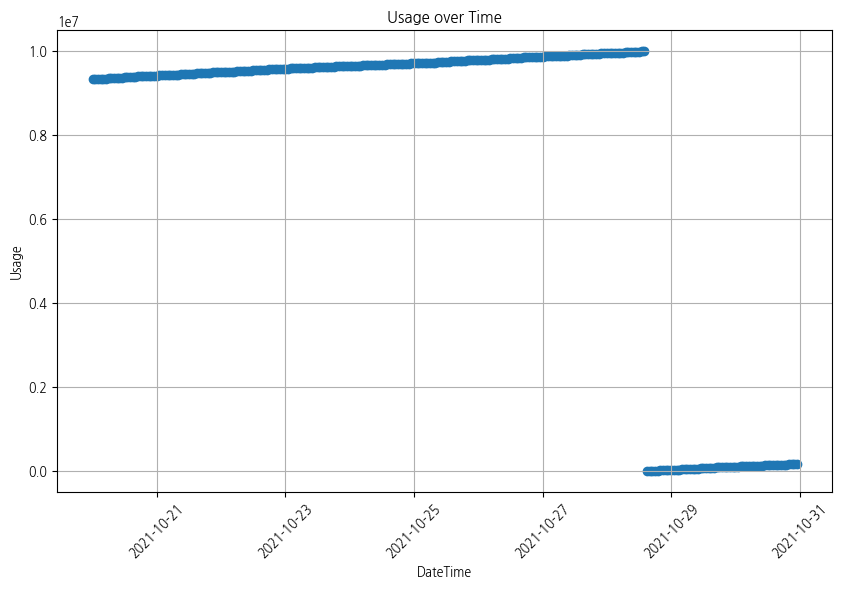

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(part1['DateTime'], part1['전력사용량'])
plt.xlabel('DateTime')
plt.ylabel('Usage')
plt.title('Usage over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
# 209번 2021/10/28 오후 3시에 끊김

In [ ]:
part1.loc[206]

일시          2021-10-28 PM 2:00:00
전력사용량                  9997040.00
DateTime      2021-10-28 14:00:00
Name: 206, dtype: object

In [ ]:
part1.loc[207]

일시          2021-10-28 PM 3:00:00
전력사용량                     1557.81
DateTime      2021-10-28 15:00:00
Name: 207, dtype: object

In [ ]:
part1.loc[263]

일시          2021-10-30 PM 11:00:00
전력사용량                    170529.80
DateTime       2021-10-30 23:00:00
Name: 263, dtype: object

In [ ]:
part1.loc[207]

일시          2021-10-28 PM 3:00:00
전력사용량                     1557.81
DateTime      2021-10-28 15:00:00
Name: 207, dtype: object

In [ ]:
part1.loc[207:, '전력사용량'] += 10000000

# 결과 확인
print(part1.iloc[205:263])

                         일시       전력사용량            DateTime
205   2021-10-28 PM 1:00:00  9992731.00 2021-10-28 13:00:00
206   2021-10-28 PM 2:00:00  9997040.00 2021-10-28 14:00:00
207   2021-10-28 PM 3:00:00 10001557.81 2021-10-28 15:00:00
208   2021-10-28 PM 4:00:00 10005979.90 2021-10-28 16:00:00
209   2021-10-28 PM 5:00:00 10010497.81 2021-10-28 17:00:00
210   2021-10-28 PM 6:00:00 10014310.50 2021-10-28 18:00:00
211   2021-10-28 PM 7:00:00 10018058.86 2021-10-28 19:00:00
212   2021-10-28 PM 8:00:00 10021537.00 2021-10-28 20:00:00
213   2021-10-28 PM 9:00:00 10024584.11 2021-10-28 21:00:00
214  2021-10-28 PM 10:00:00 10027473.69 2021-10-28 22:00:00
215  2021-10-28 PM 11:00:00 10030132.66 2021-10-28 23:00:00
216  2021-10-29 AM 12:00:00 10032730.93 2021-10-29 00:00:00
217   2021-10-29 AM 1:00:00 10035359.15 2021-10-29 01:00:00
218   2021-10-29 AM 2:00:00 10037975.84 2021-10-29 02:00:00
219   2021-10-29 AM 3:00:00 10040449.82 2021-10-29 03:00:00
220   2021-10-29 AM 4:00:00 10042845.76 

In [ ]:
part1

일시       전력사용량            DateTime
0    2021-10-20 AM 12:00:00  9334835.00 2021-10-20 00:00:00
1     2021-10-20 AM 1:00:00  9337298.00 2021-10-20 01:00:00
2     2021-10-20 AM 2:00:00  9339817.00 2021-10-20 02:00:00
3     2021-10-20 AM 3:00:00  9342287.00 2021-10-20 03:00:00
4     2021-10-20 AM 4:00:00  9344706.00 2021-10-20 04:00:00
..                      ...         ...                 ...
259   2021-10-30 PM 7:00:00 10160361.69 2021-10-30 19:00:00
260   2021-10-30 PM 8:00:00 10162955.58 2021-10-30 20:00:00
261   2021-10-30 PM 9:00:00 10165454.84 2021-10-30 21:00:00
262  2021-10-30 PM 10:00:00 10167997.47 2021-10-30 22:00:00
263  2021-10-30 PM 11:00:00 10170529.80 2021-10-30 23:00:00

[264 rows x 3 columns]

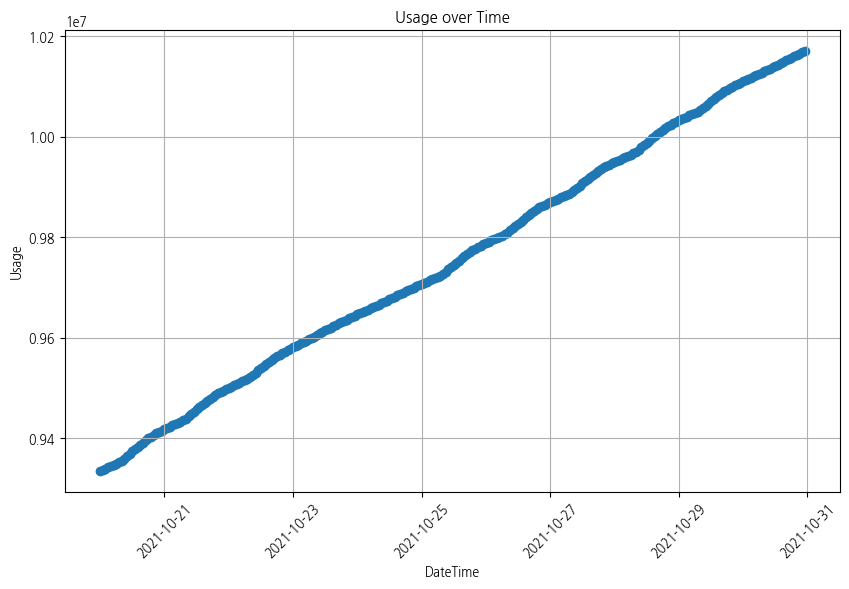

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(part1['DateTime'], part1['전력사용량'])
plt.xlabel('DateTime')
plt.ylabel('Usage')
plt.title('Usage over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


### 61번 데이터_part2

In [ ]:
part2

일시     전력사용량
0                2021-10-20  31438992
1     2021-10-20 오전 1:00:00  31440164
2     2021-10-20 오전 2:00:00  31441352
3     2021-10-20 오전 3:00:00  31442548
4     2021-10-20 오전 4:00:00  31443736
..                      ...       ...
259   2021-10-30 오후 7:00:00  31790478
260   2021-10-30 오후 8:00:00  31791390
261   2021-10-30 오후 9:00:00  31792268
262  2021-10-30 오후 10:00:00  31793152
263  2021-10-30 오후 11:00:00  31794032

[264 rows x 2 columns]

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)
# '오전'과 '오후'를 AM, PM으로 변환
part2['일시'] = part2['일시'].str.replace('오전', 'AM').str.replace('오후', 'PM')

In [ ]:
part2['DateTime'] = pd.to_datetime(part2['일시'], format='%Y-%m-%d %p %I:%M:%S', errors='coerce')

In [ ]:
part2

일시     전력사용량            DateTime
0                2021-10-20  31438992                 NaT
1     2021-10-20 AM 1:00:00  31440164 2021-10-20 01:00:00
2     2021-10-20 AM 2:00:00  31441352 2021-10-20 02:00:00
3     2021-10-20 AM 3:00:00  31442548 2021-10-20 03:00:00
4     2021-10-20 AM 4:00:00  31443736 2021-10-20 04:00:00
..                      ...       ...                 ...
259   2021-10-30 PM 7:00:00  31790478 2021-10-30 19:00:00
260   2021-10-30 PM 8:00:00  31791390 2021-10-30 20:00:00
261   2021-10-30 PM 9:00:00  31792268 2021-10-30 21:00:00
262  2021-10-30 PM 10:00:00  31793152 2021-10-30 22:00:00
263  2021-10-30 PM 11:00:00  31794032 2021-10-30 23:00:00

[264 rows x 3 columns]

In [ ]:
import pandas as pd
import re
def convert_date_format(date_str):
    if re.match(r'^\d{4}-\d{2}-\d{2}$', date_str):
        date = pd.to_datetime(date_str)
        return date.strftime('%Y-%m-%d AM 12:00:00')
    return date_str

part2['일시'] = part2['일시'].apply(convert_date_format)

# 결과 확인
print(part2)

                         일시     전력사용량            DateTime
0    2021-10-20 AM 12:00:00  31438992                 NaT
1     2021-10-20 AM 1:00:00  31440164 2021-10-20 01:00:00
2     2021-10-20 AM 2:00:00  31441352 2021-10-20 02:00:00
3     2021-10-20 AM 3:00:00  31442548 2021-10-20 03:00:00
4     2021-10-20 AM 4:00:00  31443736 2021-10-20 04:00:00
..                      ...       ...                 ...
259   2021-10-30 PM 7:00:00  31790478 2021-10-30 19:00:00
260   2021-10-30 PM 8:00:00  31791390 2021-10-30 20:00:00
261   2021-10-30 PM 9:00:00  31792268 2021-10-30 21:00:00
262  2021-10-30 PM 10:00:00  31793152 2021-10-30 22:00:00
263  2021-10-30 PM 11:00:00  31794032 2021-10-30 23:00:00

[264 rows x 3 columns]


In [ ]:
part2['DateTime'] = pd.to_datetime(part2['일시'], format='%Y-%m-%d %p %I:%M:%S', errors='coerce')
part2

일시     전력사용량            DateTime
0    2021-10-20 AM 12:00:00  31438992 2021-10-20 00:00:00
1     2021-10-20 AM 1:00:00  31440164 2021-10-20 01:00:00
2     2021-10-20 AM 2:00:00  31441352 2021-10-20 02:00:00
3     2021-10-20 AM 3:00:00  31442548 2021-10-20 03:00:00
4     2021-10-20 AM 4:00:00  31443736 2021-10-20 04:00:00
..                      ...       ...                 ...
259   2021-10-30 PM 7:00:00  31790478 2021-10-30 19:00:00
260   2021-10-30 PM 8:00:00  31791390 2021-10-30 20:00:00
261   2021-10-30 PM 9:00:00  31792268 2021-10-30 21:00:00
262  2021-10-30 PM 10:00:00  31793152 2021-10-30 22:00:00
263  2021-10-30 PM 11:00:00  31794032 2021-10-30 23:00:00

[264 rows x 3 columns]

In [ ]:
'''# '일시' 열을 datetime 형식으로 변환한 후, 오전 12시 형식으로 변경
part1['일시'] = pd.to_datetime(part1['일시'], errors='coerce')
part1['일시'] = part1['일시'].dt.strftime('%Y-%m-%d AM 00:00:00')

# 결과 확인
print(part1)'''

"# '일시' 열을 datetime 형식으로 변환한 후, 오전 12시 형식으로 변경\npart1['일시'] = pd.to_datetime(part1['일시'], errors='coerce')\npart1['일시'] = part1['일시'].dt.strftime('%Y-%m-%d AM 00:00:00')\n\n# 결과 확인\nprint(part1)"

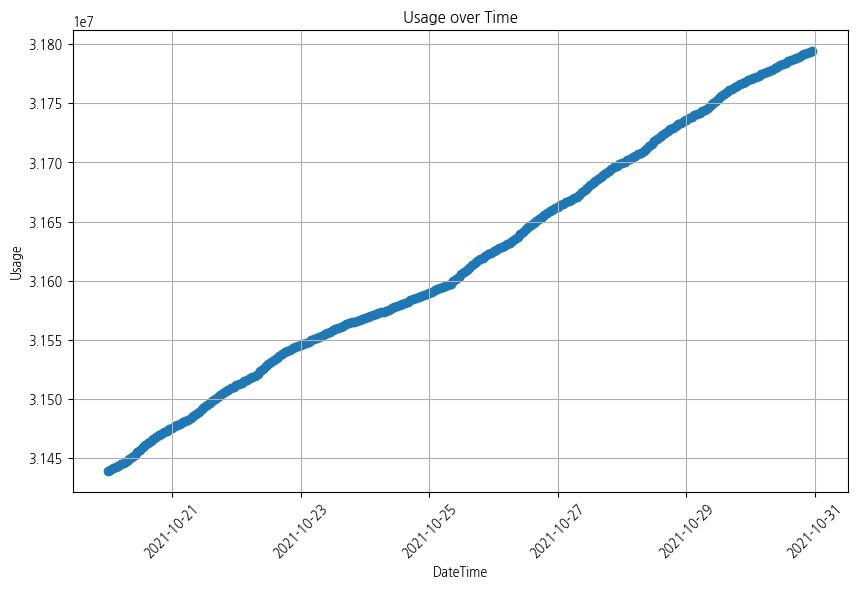

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(part2['DateTime'], part2['전력사용량'])
plt.xlabel('DateTime')
plt.ylabel('Usage')
plt.title('Usage over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


### 61번 데이터_main

In [ ]:
main

일시     전력사용량
0                2021-10-20  42783392
1     2021-10-20 오전 1:00:00  42787024
2     2021-10-20 오전 2:00:00  42790732
3     2021-10-20 오전 3:00:00  42794400
4     2021-10-20 오전 4:00:00  42798000
..                      ...       ...
259   2021-10-30 오후 7:00:00  33987524
260   2021-10-30 오후 8:00:00  33991024
261   2021-10-30 오후 9:00:00  33994408
262  2021-10-30 오후 10:00:00  33997836
263  2021-10-30 오후 11:00:00  34001248

[264 rows x 2 columns]

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)
# '오전'과 '오후'를 AM, PM으로 변환
main['일시'] = main['일시'].str.replace('오전', 'AM').str.replace('오후', 'PM')

In [ ]:
main['DateTime'] = pd.to_datetime(part2['일시'], format='%Y-%m-%d %p %I:%M:%S', errors='coerce')

In [ ]:
main

일시     전력사용량            DateTime
0                2021-10-20  42783392 2021-10-20 00:00:00
1     2021-10-20 AM 1:00:00  42787024 2021-10-20 01:00:00
2     2021-10-20 AM 2:00:00  42790732 2021-10-20 02:00:00
3     2021-10-20 AM 3:00:00  42794400 2021-10-20 03:00:00
4     2021-10-20 AM 4:00:00  42798000 2021-10-20 04:00:00
..                      ...       ...                 ...
259   2021-10-30 PM 7:00:00  33987524 2021-10-30 19:00:00
260   2021-10-30 PM 8:00:00  33991024 2021-10-30 20:00:00
261   2021-10-30 PM 9:00:00  33994408 2021-10-30 21:00:00
262  2021-10-30 PM 10:00:00  33997836 2021-10-30 22:00:00
263  2021-10-30 PM 11:00:00  34001248 2021-10-30 23:00:00

[264 rows x 3 columns]

In [ ]:
import pandas as pd
import re
def convert_date_format(date_str):
    if re.match(r'^\d{4}-\d{2}-\d{2}$', date_str):
        date = pd.to_datetime(date_str)
        return date.strftime('%Y-%m-%d AM 12:00:00')
    return date_str

main['일시'] = main['일시'].apply(convert_date_format)

# 결과 확인
print(main)

                         일시     전력사용량            DateTime
0    2021-10-20 AM 12:00:00  42783392 2021-10-20 00:00:00
1     2021-10-20 AM 1:00:00  42787024 2021-10-20 01:00:00
2     2021-10-20 AM 2:00:00  42790732 2021-10-20 02:00:00
3     2021-10-20 AM 3:00:00  42794400 2021-10-20 03:00:00
4     2021-10-20 AM 4:00:00  42798000 2021-10-20 04:00:00
..                      ...       ...                 ...
259   2021-10-30 PM 7:00:00  33987524 2021-10-30 19:00:00
260   2021-10-30 PM 8:00:00  33991024 2021-10-30 20:00:00
261   2021-10-30 PM 9:00:00  33994408 2021-10-30 21:00:00
262  2021-10-30 PM 10:00:00  33997836 2021-10-30 22:00:00
263  2021-10-30 PM 11:00:00  34001248 2021-10-30 23:00:00

[264 rows x 3 columns]


In [ ]:
'''# '일시' 열을 datetime 형식으로 변환한 후, 오전 12시 형식으로 변경
part1['일시'] = pd.to_datetime(part1['일시'], errors='coerce')
part1['일시'] = part1['일시'].dt.strftime('%Y-%m-%d AM 00:00:00')

# 결과 확인
print(part1)'''

"# '일시' 열을 datetime 형식으로 변환한 후, 오전 12시 형식으로 변경\npart1['일시'] = pd.to_datetime(part1['일시'], errors='coerce')\npart1['일시'] = part1['일시'].dt.strftime('%Y-%m-%d AM 00:00:00')\n\n# 결과 확인\nprint(part1)"

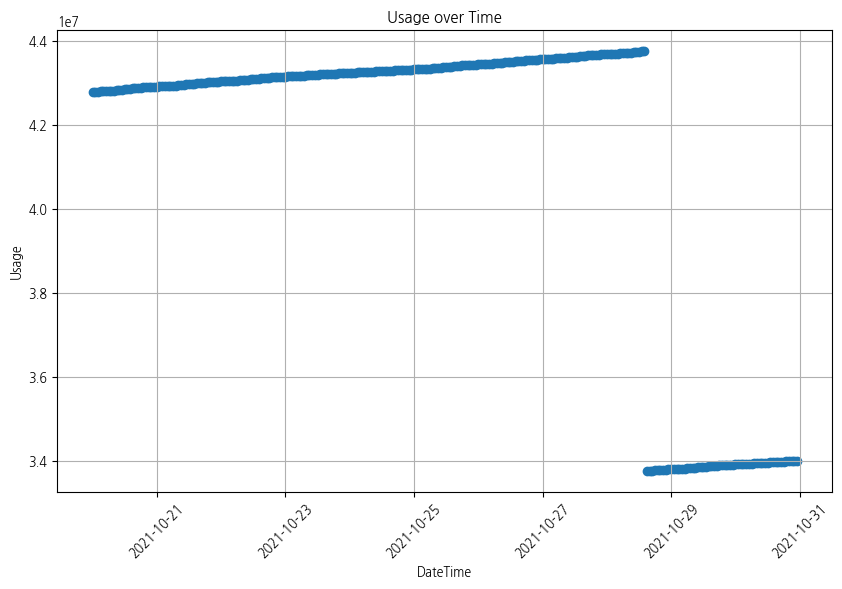

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(main['DateTime'], main['전력사용량'])
plt.xlabel('DateTime')
plt.ylabel('Usage')
plt.title('Usage over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
main.loc[206]

일시          2021-10-28 PM 2:00:00
전력사용량                    43749552
DateTime      2021-10-28 14:00:00
Name: 206, dtype: object

In [ ]:
main.loc[207]

일시          2021-10-28 PM 3:00:00
전력사용량                    33756400
DateTime      2021-10-28 15:00:00
Name: 207, dtype: object

In [ ]:
main.loc[263]

일시          2021-10-30 PM 11:00:00
전력사용량                     34001248
DateTime       2021-10-30 23:00:00
Name: 263, dtype: object

In [ ]:
main.loc[207:, '전력사용량'] += 10000000

# 결과 확인
print(part1.iloc[205:263])

                         일시       전력사용량            DateTime
205   2021-10-28 PM 1:00:00  9992731.00 2021-10-28 13:00:00
206   2021-10-28 PM 2:00:00  9997040.00 2021-10-28 14:00:00
207   2021-10-28 PM 3:00:00 10001557.81 2021-10-28 15:00:00
208   2021-10-28 PM 4:00:00 10005979.90 2021-10-28 16:00:00
209   2021-10-28 PM 5:00:00 10010497.81 2021-10-28 17:00:00
210   2021-10-28 PM 6:00:00 10014310.50 2021-10-28 18:00:00
211   2021-10-28 PM 7:00:00 10018058.86 2021-10-28 19:00:00
212   2021-10-28 PM 8:00:00 10021537.00 2021-10-28 20:00:00
213   2021-10-28 PM 9:00:00 10024584.11 2021-10-28 21:00:00
214  2021-10-28 PM 10:00:00 10027473.69 2021-10-28 22:00:00
215  2021-10-28 PM 11:00:00 10030132.66 2021-10-28 23:00:00
216  2021-10-29 AM 12:00:00 10032730.93 2021-10-29 00:00:00
217   2021-10-29 AM 1:00:00 10035359.15 2021-10-29 01:00:00
218   2021-10-29 AM 2:00:00 10037975.84 2021-10-29 02:00:00
219   2021-10-29 AM 3:00:00 10040449.82 2021-10-29 03:00:00
220   2021-10-29 AM 4:00:00 10042845.76 

In [ ]:
part1

일시       전력사용량            DateTime
0    2021-10-20 AM 12:00:00  9334835.00 2021-10-20 00:00:00
1     2021-10-20 AM 1:00:00  9337298.00 2021-10-20 01:00:00
2     2021-10-20 AM 2:00:00  9339817.00 2021-10-20 02:00:00
3     2021-10-20 AM 3:00:00  9342287.00 2021-10-20 03:00:00
4     2021-10-20 AM 4:00:00  9344706.00 2021-10-20 04:00:00
..                      ...         ...                 ...
259   2021-10-30 PM 7:00:00 10160361.69 2021-10-30 19:00:00
260   2021-10-30 PM 8:00:00 10162955.58 2021-10-30 20:00:00
261   2021-10-30 PM 9:00:00 10165454.84 2021-10-30 21:00:00
262  2021-10-30 PM 10:00:00 10167997.47 2021-10-30 22:00:00
263  2021-10-30 PM 11:00:00 10170529.80 2021-10-30 23:00:00

[264 rows x 3 columns]

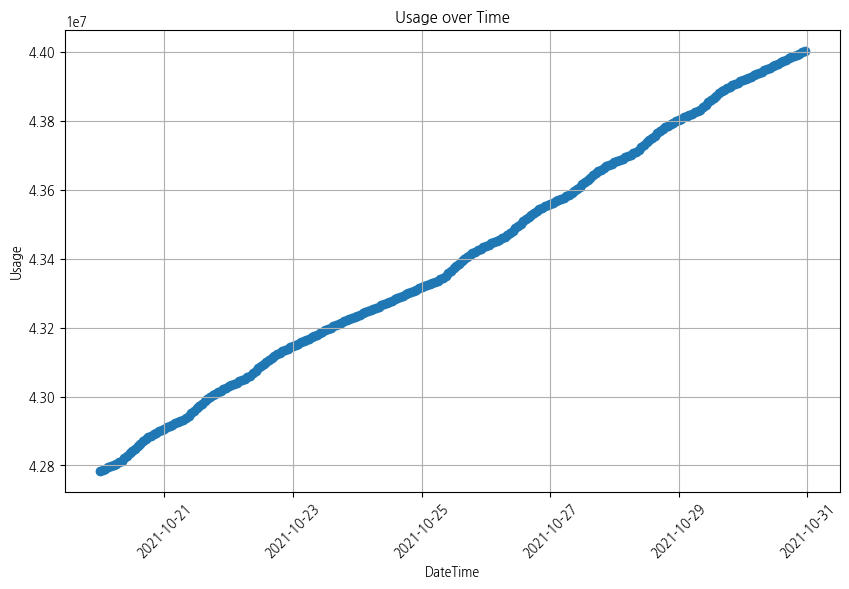

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(main['DateTime'], main['전력사용량'])
plt.xlabel('DateTime')
plt.ylabel('Usage')
plt.title('Usage over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


#### 누적데이터 개별데이터로 변환

In [ ]:
# 전력 사용량을 개별 데이터로 변환
part1['개별전력사용량'] = part1['전력사용량'].diff()

# 첫 번째 값은 NaN이 되므로 0으로 대체 (혹은 다른 적절한 값으로 대체 가능)
part1['개별전력사용량'].fillna(part1['전력사용량'].iloc[0], inplace=True)

# 결과 확인
print(part1)

                         일시       전력사용량            DateTime    개별전력사용량
0    2021-10-20 AM 12:00:00  9334835.00 2021-10-20 00:00:00 9334835.00
1     2021-10-20 AM 1:00:00  9337298.00 2021-10-20 01:00:00    2463.00
2     2021-10-20 AM 2:00:00  9339817.00 2021-10-20 02:00:00    2519.00
3     2021-10-20 AM 3:00:00  9342287.00 2021-10-20 03:00:00    2470.00
4     2021-10-20 AM 4:00:00  9344706.00 2021-10-20 04:00:00    2419.00
..                      ...         ...                 ...        ...
259   2021-10-30 PM 7:00:00 10160361.69 2021-10-30 19:00:00    2664.25
260   2021-10-30 PM 8:00:00 10162955.58 2021-10-30 20:00:00    2593.89
261   2021-10-30 PM 9:00:00 10165454.84 2021-10-30 21:00:00    2499.27
262  2021-10-30 PM 10:00:00 10167997.47 2021-10-30 22:00:00    2542.62
263  2021-10-30 PM 11:00:00 10170529.80 2021-10-30 23:00:00    2532.33

[264 rows x 4 columns]


In [ ]:
part1

일시       전력사용량            DateTime    개별전력사용량
0    2021-10-20 AM 12:00:00  9334835.00 2021-10-20 00:00:00 9334835.00
1     2021-10-20 AM 1:00:00  9337298.00 2021-10-20 01:00:00    2463.00
2     2021-10-20 AM 2:00:00  9339817.00 2021-10-20 02:00:00    2519.00
3     2021-10-20 AM 3:00:00  9342287.00 2021-10-20 03:00:00    2470.00
4     2021-10-20 AM 4:00:00  9344706.00 2021-10-20 04:00:00    2419.00
..                      ...         ...                 ...        ...
259   2021-10-30 PM 7:00:00 10160361.69 2021-10-30 19:00:00    2664.25
260   2021-10-30 PM 8:00:00 10162955.58 2021-10-30 20:00:00    2593.89
261   2021-10-30 PM 9:00:00 10165454.84 2021-10-30 21:00:00    2499.27
262  2021-10-30 PM 10:00:00 10167997.47 2021-10-30 22:00:00    2542.62
263  2021-10-30 PM 11:00:00 10170529.80 2021-10-30 23:00:00    2532.33

[264 rows x 4 columns]

In [ ]:
# 첫 번째 값은 두 번째 값으로 대체
part1['개별전력사용량'].iloc[0] = part1['개별전력사용량'].iloc[1]


In [ ]:
part1

일시       전력사용량            DateTime  개별전력사용량
0    2021-10-20 AM 12:00:00  9334835.00 2021-10-20 00:00:00  2463.00
1     2021-10-20 AM 1:00:00  9337298.00 2021-10-20 01:00:00  2463.00
2     2021-10-20 AM 2:00:00  9339817.00 2021-10-20 02:00:00  2519.00
3     2021-10-20 AM 3:00:00  9342287.00 2021-10-20 03:00:00  2470.00
4     2021-10-20 AM 4:00:00  9344706.00 2021-10-20 04:00:00  2419.00
..                      ...         ...                 ...      ...
259   2021-10-30 PM 7:00:00 10160361.69 2021-10-30 19:00:00  2664.25
260   2021-10-30 PM 8:00:00 10162955.58 2021-10-30 20:00:00  2593.89
261   2021-10-30 PM 9:00:00 10165454.84 2021-10-30 21:00:00  2499.27
262  2021-10-30 PM 10:00:00 10167997.47 2021-10-30 22:00:00  2542.62
263  2021-10-30 PM 11:00:00 10170529.80 2021-10-30 23:00:00  2532.33

[264 rows x 4 columns]

In [ ]:
part2

일시     전력사용량            DateTime
0    2021-10-20 AM 12:00:00  31438992 2021-10-20 00:00:00
1     2021-10-20 AM 1:00:00  31440164 2021-10-20 01:00:00
2     2021-10-20 AM 2:00:00  31441352 2021-10-20 02:00:00
3     2021-10-20 AM 3:00:00  31442548 2021-10-20 03:00:00
4     2021-10-20 AM 4:00:00  31443736 2021-10-20 04:00:00
..                      ...       ...                 ...
259   2021-10-30 PM 7:00:00  31790478 2021-10-30 19:00:00
260   2021-10-30 PM 8:00:00  31791390 2021-10-30 20:00:00
261   2021-10-30 PM 9:00:00  31792268 2021-10-30 21:00:00
262  2021-10-30 PM 10:00:00  31793152 2021-10-30 22:00:00
263  2021-10-30 PM 11:00:00  31794032 2021-10-30 23:00:00

[264 rows x 3 columns]

In [ ]:
# 전력 사용량을 개별 데이터로 변환
part2['개별전력사용량'] = part2['전력사용량'].diff()

# 첫 번째 값은 NaN이 되므로 0으로 대체 (혹은 다른 적절한 값으로 대체 가능)
part2['개별전력사용량'].fillna(part2['전력사용량'].iloc[0], inplace=True)

# 결과 확인
print(part2)

                         일시     전력사용량            DateTime     개별전력사용량
0    2021-10-20 AM 12:00:00  31438992 2021-10-20 00:00:00 31438992.00
1     2021-10-20 AM 1:00:00  31440164 2021-10-20 01:00:00     1172.00
2     2021-10-20 AM 2:00:00  31441352 2021-10-20 02:00:00     1188.00
3     2021-10-20 AM 3:00:00  31442548 2021-10-20 03:00:00     1196.00
4     2021-10-20 AM 4:00:00  31443736 2021-10-20 04:00:00     1188.00
..                      ...       ...                 ...         ...
259   2021-10-30 PM 7:00:00  31790478 2021-10-30 19:00:00     1002.00
260   2021-10-30 PM 8:00:00  31791390 2021-10-30 20:00:00      912.00
261   2021-10-30 PM 9:00:00  31792268 2021-10-30 21:00:00      878.00
262  2021-10-30 PM 10:00:00  31793152 2021-10-30 22:00:00      884.00
263  2021-10-30 PM 11:00:00  31794032 2021-10-30 23:00:00      880.00

[264 rows x 4 columns]


In [ ]:
part2

일시     전력사용량            DateTime     개별전력사용량
0    2021-10-20 AM 12:00:00  31438992 2021-10-20 00:00:00 31438992.00
1     2021-10-20 AM 1:00:00  31440164 2021-10-20 01:00:00     1172.00
2     2021-10-20 AM 2:00:00  31441352 2021-10-20 02:00:00     1188.00
3     2021-10-20 AM 3:00:00  31442548 2021-10-20 03:00:00     1196.00
4     2021-10-20 AM 4:00:00  31443736 2021-10-20 04:00:00     1188.00
..                      ...       ...                 ...         ...
259   2021-10-30 PM 7:00:00  31790478 2021-10-30 19:00:00     1002.00
260   2021-10-30 PM 8:00:00  31791390 2021-10-30 20:00:00      912.00
261   2021-10-30 PM 9:00:00  31792268 2021-10-30 21:00:00      878.00
262  2021-10-30 PM 10:00:00  31793152 2021-10-30 22:00:00      884.00
263  2021-10-30 PM 11:00:00  31794032 2021-10-30 23:00:00      880.00

[264 rows x 4 columns]

In [ ]:
# 첫 번째 값은 두 번째 값으로 대체
part2['개별전력사용량'].iloc[0] = part2['개별전력사용량'].iloc[1]


In [ ]:
part2

일시     전력사용량            DateTime  개별전력사용량
0    2021-10-20 AM 12:00:00  31438992 2021-10-20 00:00:00  1172.00
1     2021-10-20 AM 1:00:00  31440164 2021-10-20 01:00:00  1172.00
2     2021-10-20 AM 2:00:00  31441352 2021-10-20 02:00:00  1188.00
3     2021-10-20 AM 3:00:00  31442548 2021-10-20 03:00:00  1196.00
4     2021-10-20 AM 4:00:00  31443736 2021-10-20 04:00:00  1188.00
..                      ...       ...                 ...      ...
259   2021-10-30 PM 7:00:00  31790478 2021-10-30 19:00:00  1002.00
260   2021-10-30 PM 8:00:00  31791390 2021-10-30 20:00:00   912.00
261   2021-10-30 PM 9:00:00  31792268 2021-10-30 21:00:00   878.00
262  2021-10-30 PM 10:00:00  31793152 2021-10-30 22:00:00   884.00
263  2021-10-30 PM 11:00:00  31794032 2021-10-30 23:00:00   880.00

[264 rows x 4 columns]

In [ ]:
main

일시     전력사용량            DateTime
0    2021-10-20 AM 12:00:00  42783392 2021-10-20 00:00:00
1     2021-10-20 AM 1:00:00  42787024 2021-10-20 01:00:00
2     2021-10-20 AM 2:00:00  42790732 2021-10-20 02:00:00
3     2021-10-20 AM 3:00:00  42794400 2021-10-20 03:00:00
4     2021-10-20 AM 4:00:00  42798000 2021-10-20 04:00:00
..                      ...       ...                 ...
259   2021-10-30 PM 7:00:00  43987524 2021-10-30 19:00:00
260   2021-10-30 PM 8:00:00  43991024 2021-10-30 20:00:00
261   2021-10-30 PM 9:00:00  43994408 2021-10-30 21:00:00
262  2021-10-30 PM 10:00:00  43997836 2021-10-30 22:00:00
263  2021-10-30 PM 11:00:00  44001248 2021-10-30 23:00:00

[264 rows x 3 columns]

In [ ]:
# 전력 사용량을 개별 데이터로 변환
main['개별전력사용량'] = main['전력사용량'].diff()

# 첫 번째 값은 NaN이 되므로 0으로 대체 (혹은 다른 적절한 값으로 대체 가능)
main['개별전력사용량'].fillna(main['전력사용량'].iloc[0], inplace=True)

# 결과 확인
print(main)

                         일시     전력사용량            DateTime     개별전력사용량
0    2021-10-20 AM 12:00:00  42783392 2021-10-20 00:00:00 42783392.00
1     2021-10-20 AM 1:00:00  42787024 2021-10-20 01:00:00     3632.00
2     2021-10-20 AM 2:00:00  42790732 2021-10-20 02:00:00     3708.00
3     2021-10-20 AM 3:00:00  42794400 2021-10-20 03:00:00     3668.00
4     2021-10-20 AM 4:00:00  42798000 2021-10-20 04:00:00     3600.00
..                      ...       ...                 ...         ...
259   2021-10-30 PM 7:00:00  43987524 2021-10-30 19:00:00     3664.00
260   2021-10-30 PM 8:00:00  43991024 2021-10-30 20:00:00     3500.00
261   2021-10-30 PM 9:00:00  43994408 2021-10-30 21:00:00     3384.00
262  2021-10-30 PM 10:00:00  43997836 2021-10-30 22:00:00     3428.00
263  2021-10-30 PM 11:00:00  44001248 2021-10-30 23:00:00     3412.00

[264 rows x 4 columns]


In [ ]:
main

일시     전력사용량            DateTime     개별전력사용량
0    2021-10-20 AM 12:00:00  42783392 2021-10-20 00:00:00 42783392.00
1     2021-10-20 AM 1:00:00  42787024 2021-10-20 01:00:00     3632.00
2     2021-10-20 AM 2:00:00  42790732 2021-10-20 02:00:00     3708.00
3     2021-10-20 AM 3:00:00  42794400 2021-10-20 03:00:00     3668.00
4     2021-10-20 AM 4:00:00  42798000 2021-10-20 04:00:00     3600.00
..                      ...       ...                 ...         ...
259   2021-10-30 PM 7:00:00  43987524 2021-10-30 19:00:00     3664.00
260   2021-10-30 PM 8:00:00  43991024 2021-10-30 20:00:00     3500.00
261   2021-10-30 PM 9:00:00  43994408 2021-10-30 21:00:00     3384.00
262  2021-10-30 PM 10:00:00  43997836 2021-10-30 22:00:00     3428.00
263  2021-10-30 PM 11:00:00  44001248 2021-10-30 23:00:00     3412.00

[264 rows x 4 columns]

In [ ]:
# 첫 번째 값은 두 번째 값으로 대체
main['개별전력사용량'].iloc[0] = main['개별전력사용량'].iloc[1]


In [ ]:
main

일시     전력사용량            DateTime  개별전력사용량
0    2021-10-20 AM 12:00:00  42783392 2021-10-20 00:00:00  3632.00
1     2021-10-20 AM 1:00:00  42787024 2021-10-20 01:00:00  3632.00
2     2021-10-20 AM 2:00:00  42790732 2021-10-20 02:00:00  3708.00
3     2021-10-20 AM 3:00:00  42794400 2021-10-20 03:00:00  3668.00
4     2021-10-20 AM 4:00:00  42798000 2021-10-20 04:00:00  3600.00
..                      ...       ...                 ...      ...
259   2021-10-30 PM 7:00:00  43987524 2021-10-30 19:00:00  3664.00
260   2021-10-30 PM 8:00:00  43991024 2021-10-30 20:00:00  3500.00
261   2021-10-30 PM 9:00:00  43994408 2021-10-30 21:00:00  3384.00
262  2021-10-30 PM 10:00:00  43997836 2021-10-30 22:00:00  3428.00
263  2021-10-30 PM 11:00:00  44001248 2021-10-30 23:00:00  3412.00

[264 rows x 4 columns]

In [ ]:
part1

일시       전력사용량            DateTime  개별전력사용량
0    2021-10-20 AM 12:00:00  9334835.00 2021-10-20 00:00:00  2463.00
1     2021-10-20 AM 1:00:00  9337298.00 2021-10-20 01:00:00  2463.00
2     2021-10-20 AM 2:00:00  9339817.00 2021-10-20 02:00:00  2519.00
3     2021-10-20 AM 3:00:00  9342287.00 2021-10-20 03:00:00  2470.00
4     2021-10-20 AM 4:00:00  9344706.00 2021-10-20 04:00:00  2419.00
..                      ...         ...                 ...      ...
259   2021-10-30 PM 7:00:00 10160361.69 2021-10-30 19:00:00  2664.25
260   2021-10-30 PM 8:00:00 10162955.58 2021-10-30 20:00:00  2593.89
261   2021-10-30 PM 9:00:00 10165454.84 2021-10-30 21:00:00  2499.27
262  2021-10-30 PM 10:00:00 10167997.47 2021-10-30 22:00:00  2542.62
263  2021-10-30 PM 11:00:00 10170529.80 2021-10-30 23:00:00  2532.33

[264 rows x 4 columns]

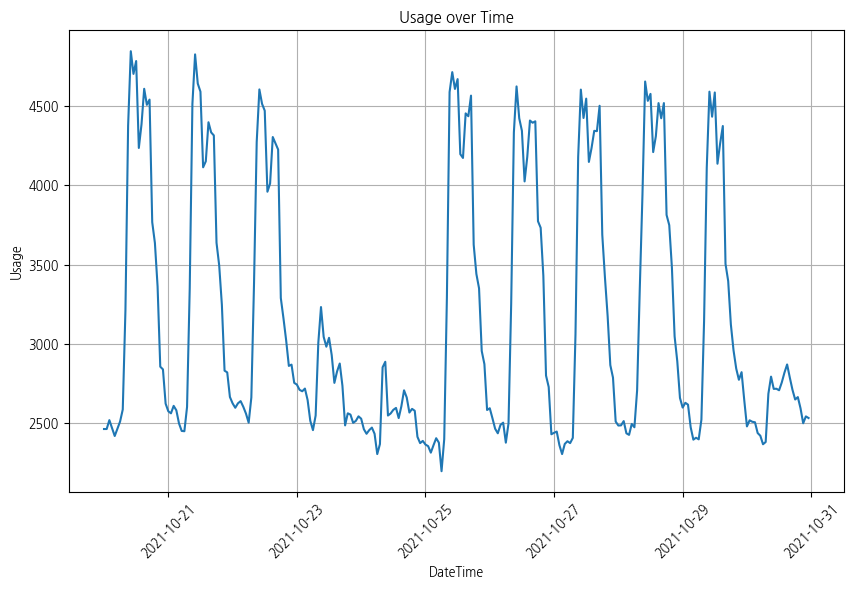

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.plot(part1['DateTime'], part1['개별전력사용량'])
plt.xlabel('DateTime')
plt.ylabel('Usage')
plt.title('Usage over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

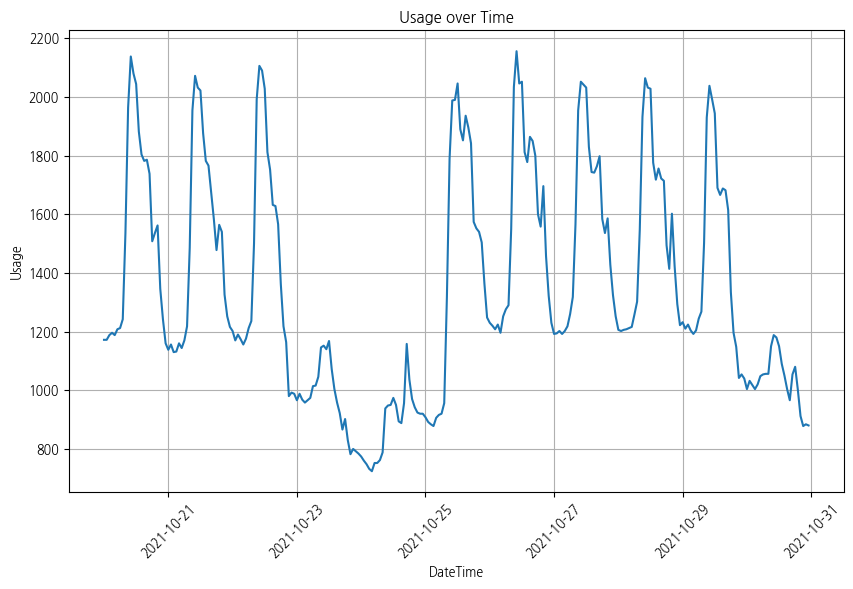

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.plot(part2['DateTime'], part2['개별전력사용량'])
plt.xlabel('DateTime')
plt.ylabel('Usage')
plt.title('Usage over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

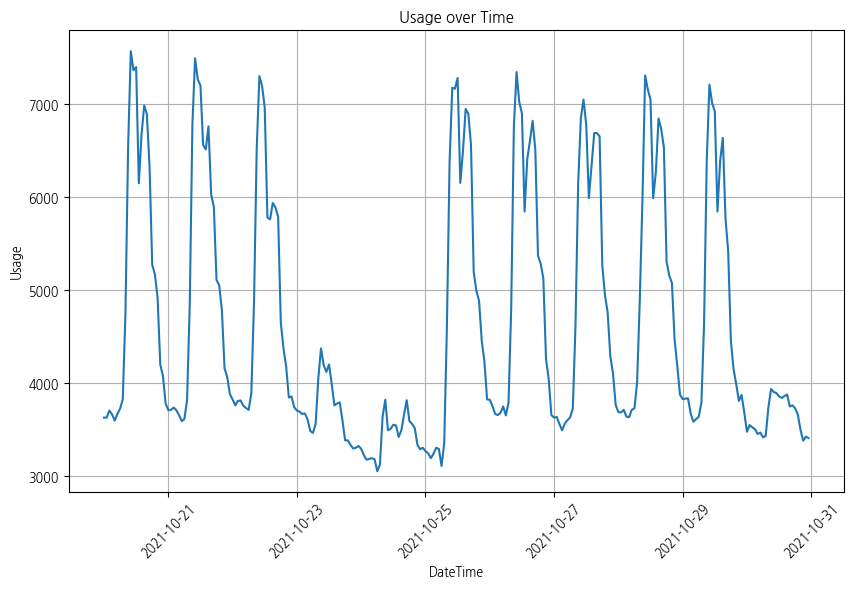

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.plot(main['DateTime'], main['개별전력사용량'])
plt.xlabel('DateTime')
plt.ylabel('Usage')
plt.title('Usage over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## 청주공장 예측

In [1]:
# DataFrame을 CSV 파일로 저장하기
df.to_csv('파일명.csv', index=False, encoding='utf-8')

NameError: name 'df' is not defined

In [ ]:
from tqdm import tqdm
import requests
import pandas as pd
import time

url = 'http://apis.data.go.kr/1360000/AsosHourlyInfoService/getWthrDataList'
key = '''YwY1c/ScYYhW+8TwGcwDQ+MFqMWaN+xkkNqSB0lHZAmxUxUayfCQvxD7nzNaRmxmZ7Ns/kdCMaigBKjOFBoOhA=='''

dfs = []

# start_end_date가 정의되어 있다고 가정합니다.
# 예시: start_end_date = [('20230101', '20230102'), ('20230102', '20230103')]

for i in tqdm(start_end_date):
    print(i)

    params = {
        'serviceKey': key,
        'pageNo': '1',
        'numOfRows': '999',
        'dataType': 'JSON',
        'dataCd': 'ASOS',  # 자료분류코드
        'dateCd': 'HR',  # 날짜분류코드
        'startDt': str(i[0]),  # 시작일
        'startHh': '00',  # 시작시간
        'endDt': str(i[1]),  # 종료일
        'endHh': '00',  # 종료시간
        'stnIds': '131'  # 청주지역코드
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()  # 요청이 성공했는지 확인
        result = response.json()  # JSON 디코딩 시도
        df = pd.DataFrame(result['response']['body']['items']['item'])
        dfs.append(df)
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
    except requests.exceptions.RequestException as req_err:
        print(f"Request error occurred: {req_err}")
    except requests.exceptions.JSONDecodeError:
        print("오류: 응답이 JSON 형식이 아닙니다")
        print(response.text)  # 실제 응답 내용 출력
    except KeyError:
        print("오류: 예상하지 못한 JSON 구조입니다")
        print(result)  # 받은 JSON 전체 출력

# 모든 데이터를 병합
if dfs:
    final_df = pd.concat(dfs, axis=0, ignore_index=True)
else:
    final_df = pd.DataFrame()  # 빈 데이터프레임 생성

# 10월 데이터만 필터링
final_df['date'] = pd.to_datetime(final_df['tm'], format='%Y-%m-%d %H:%M')  # 'tm' 열을 datetime 형식으로 변환
october_df = final_df[final_df['date'].dt.month == 10]  # 10월 데이터만 선택

# 필요한 컬럼만 선택하고 이름 변경
selected_columns = ['tm', 'ta', 'ws', 'hm', 'rn', 'ss']
october_df = october_df[selected_columns]
october_df.columns = ['date_time', '기온(°C)', '풍속(m/s)', '습도(%)', '강수량(mm)', '일조(hr)']

print(october_df)

In [2]:
# 10월 20일부터 10월 30일까지의 데이터 필터링
start_date = '2021-10-20'
end_date = '2021-10-31'
filtered_df = october_df[(october_df['date_time'] >= start_date) & (october_df['date_time'] <= end_date)]

print(filtered_df)

NameError: name 'october_df' is not defined

In [3]:
# DataFrame을 CSV 파일로 저장하기
filtered_df.to_csv('weather_data.csv', index=False, encoding='cp949', float_format='%.2f')

NameError: name 'filtered_df' is not defined

In [4]:
# 'date_time' 열을 datetime 형식으로 변환 (필요시)
part1['date_time'] = pd.to_datetime(part1['date_time'], format='%Y-%m-%d %H:%M:%S')
filtered_df['date_time'] = pd.to_datetime(filtered_df['date_time'], format='%Y-%m-%d %H:%M')


# 두 데이터프레임 병합
merged_df = pd.merge(part1, filtered_df, on='date_time', how='inner')

# 결과 출력
print("Merged DataFrame:")
print(merged_df.head())

# 병합된 데이터프레임을 CSV 파일로 저장 (원하는 파일명으로 저장)
merged_df.to_csv('merged_part1.csv', index=False, encoding='cp949')




# 'date_time' 열을 datetime 형식으로 변환 (필요시)
part2['date_time'] = pd.to_datetime(part2['date_time'], format='%Y-%m-%d %H:%M:%S')
filtered_df['date_time'] = pd.to_datetime(filtered_df['date_time'], format='%Y-%m-%d %H:%M')


# 두 데이터프레임 병합
merged_df = pd.merge(part2, filtered_df, on='date_time', how='inner')

# 결과 출력
print("Merged DataFrame:")
print(merged_df.head())

# 병합된 데이터프레임을 CSV 파일로 저장 (원하는 파일명으로 저장)
merged_df.to_csv('merged_part2.csv', index=False, encoding='cp949')



# 'date_time' 열을 datetime 형식으로 변환 (필요시)
main['date_time'] = pd.to_datetime(main['date_time'], format='%Y-%m-%d %H:%M:%S')
filtered_df['date_time'] = pd.to_datetime(filtered_df['date_time'], format='%Y-%m-%d %H:%M')


# 두 데이터프레임 병합
merged_df = pd.merge(main, filtered_df, on='date_time', how='inner')

# 결과 출력
print("Merged DataFrame:")
print(merged_df.head())

# 병합된 데이터프레임을 CSV 파일로 저장 (원하는 파일명으로 저장)
merged_df.to_csv('merged_main.csv', index=False, encoding='cp949')

NameError: name 'pd' is not defined

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 로드
data1 = part1
data2 = part2


# date_time 열을 datetime 형식으로 변환
data1['date_time'] = pd.to_datetime(data1['date_time'])
data2['date_time'] = pd.to_datetime(data2['date_time'])

# 두 데이터를 date_time을 기준으로 병합
merged_data = pd.merge(data1, data2, on='date_time', suffixes=('_1', '_2'))

# 전력 사용량 합산
merged_data['total_power_usage'] = merged_data['Individual power usage_1'] + merged_data['Individual power usage_2']

# 시각화
plt.figure(figsize=(14, 7))
plt.plot(merged_data['date_time'], merged_data['total_power_usage'], label='Total Power Usage')

plt.title('Total Power Usage Over Time')
plt.xlabel('Date Time')
plt.ylabel('Total Power Usage (kWh)')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'part1' is not defined

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 로드
# main 및 merged_data 데이터프레임이 이미 로드되어 있다고 가정합니다.

# date_time 열을 datetime 형식으로 변환
main['date_time'] = pd.to_datetime(main['date_time'])
merged_data['date_time'] = pd.to_datetime(merged_data['date_time'])

# 필요없는 열 삭제 (원본 데이터를 수정하지 않기 위해 복사본 사용)
data1 = main[['date_time', 'Individual power usage']].copy()
data2 = merged_data[['date_time', 'total_power_usage']].copy()

# 시각화
plt.figure(figsize=(14, 7))
plt.plot(data1['date_time'], data1['Individual power usage'], label='Main Power Usage', linestyle='--', alpha=1)
plt.plot(data2['date_time'], data2['total_power_usage'], label='Part1 + Part2 Power Usage', linestyle='-', alpha=0.7)

plt.title('Power Usage Comparison Over Time')
plt.xlabel('Date Time')
plt.ylabel('Power Usage (kWh)')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'main' is not defined

In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# 파일 경로
train_file_path = '/content/drive/MyDrive/lsda02/data/electricity_data/train.csv'

# 데이터 로드
train_df = pd.read_csv(train_file_path, encoding='cp949')

# 컬럼명 변경
cols = ['num', 'date_time', 'power', 'temp', 'wind', 'hum', 'prec', 'sun', 'non_elec', 'solar']
train_df.columns = cols

# 파생변수 생성
train_df['date_time'] = pd.to_datetime(train_df['date_time'])
train_df['month'] = train_df['date_time'].dt.month
train_df['day'] = train_df['date_time'].dt.day
train_df['hour'] = train_df['date_time'].dt.hour
train_df['weekday'] = train_df['date_time'].dt.weekday
train_df['weekend'] = train_df['weekday'].isin([5, 6]).astype(int)

# 사용하고자 하는 변수만 선택
train_df = train_df[['num', 'date_time', 'power', 'temp', 'wind', 'hum',  'hour', 'weekday', 'weekend']]

# 데이터 전처리 함수
def preprocess_data(df):
    df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')
    df = df.dropna(subset=['date_time'])
    df = df.drop_duplicates()
    df.set_index('date_time', inplace=True)
    df['power'] = df['power'].interpolate(method='linear')
    df = df[~df.index.duplicated(keep='first')]
    return df

# SMAPE 함수 정의
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

# Cluster 1의 데이터 선택
cluster_1_buildings = [2, 6, 7, 8, 13, 14, 16, 17, 18, 22, 23, 24, 25, 26, 27, 31, 32, 33, 35, 37, 39, 43, 44, 45, 46, 47, 48, 52, 53, 54, 55, 56, 57]
cluster_1_df = train_df[train_df['num'].isin(cluster_1_buildings)]
cluster_1_df = preprocess_data(cluster_1_df)

# 학습 데이터 준비
X = cluster_1_df.drop(['power', 'num'], axis=1)
y = cluster_1_df['power']

# 훈련 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 모델 훈련
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
smape_value = smape(y_test, y_pred)
print(f'SMAPE Cluster_1: {smape_value:.2f}%')

# 예측 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/lsda02/data/electricity_data/train.csv'

In [8]:
df = main

df = df.drop(columns=['Date', 'Electricity Usage', '강수량(mm)', '일조(hr)'])

# 컬럼명 변경
new_columns = {
    'Individual power usage': 'power',
    '기온(°C)': 'temp',
    '풍속(m/s)': 'wind',
    '습도(%)': 'hum',
}

df.rename(columns=new_columns, inplace=True)

df

NameError: name 'main' is not defined

In [9]:
# 새로운 데이터 로드 - 랜덤포레스트
new_data = df  # df는 새로운 데이터를 나타내는 DataFrame입니다. 필요에 따라 데이터 경로 등을 지정해야 합니다.

# 새로운 데이터 전처리
new_data['date_time'] = pd.to_datetime(new_data['date_time'])
new_data['month'] = new_data['date_time'].dt.month
new_data['day'] = new_data['date_time'].dt.day
new_data['hour'] = new_data['date_time'].dt.hour
new_data['weekday'] = new_data['date_time'].dt.weekday
new_data['weekend'] = new_data['weekday'].isin([5, 6]).astype(int)

# 필요한 변수만 선택 (전력 사용량 제외)
new_data = new_data[['date_time', 'temp', 'wind', 'hum', 'hour', 'weekday', 'weekend']]

# 모델에 입력하여 예측
predicted_power = model.predict(new_data.drop('date_time', axis=1))

# 예측 결과 출력
print(predicted_power)

NameError: name 'df' is not defined

In [10]:
#랜덤포레스트 정규화

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

new_data = df

# 예측된 전력 사용량 정규화
scaler = MinMaxScaler()
predicted_power_scaled = scaler.fit_transform(predicted_power.reshape(-1, 1))

# 새로운 데이터의 전력 사용량 정규화
new_data['power_scaled'] = scaler.fit_transform(new_data['power'].values.reshape(-1, 1))

# 시각화
plt.figure(figsize=(12, 6))

# 예측된 전력 사용량 시각화
plt.plot(new_data['date_time'], predicted_power_scaled, label='Predicted Power (Scaled)', color='blue')


# 새로운 데이터의 전력 사용량 시각화
plt.plot(new_data['date_time'], new_data['power_scaled'], label='Actual Data Power (Scaled)', color='orange')

plt.xlabel('Date Time')
plt.ylabel('Scaled Power')
plt.title('Predicted vs Actual Data Power Usage (Min-Max Scaled)')
plt.legend(fontsize=10, loc='upper right')
plt.grid(True)
plt.show()

NameError: name 'df' is not defined